## Imports

In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import datetime
warnings.filterwarnings('ignore')
#print(sns.__version__)

In [2]:
#Read file into a DataFrame and print head.
xword_data = pd.ExcelFile('../data/NYT_XWord_data.xlsx', engine='openpyxl')
print(xword_data.sheet_names)

['Sheet1']


In [3]:
df1 = xword_data.parse('Sheet1')

In [ ]:
df1.head(35)

In [ ]:
df1.info()

## Data Cleaning and Global Median Solver Feature Creation
A few generally useful operations for the exploratory analysis of the global median solver 

In [ ]:
# Delete weird columns at the back end of the imported data
#df2 = df1.drop(columns=df1.columns[-6:], axis=1)

In [4]:
# Drop other columns that, while potentially useful for predictive modeling, aren't necessary for the exploratory data analysis
df2 = df1.drop(['Difficulty', '1st_Constructor', '1st_Constuctor_Gender', '1st_Constructor_Puzzle_N', '1st_Constructor_Debut', '1st_Constructor_Scrabble_Avg', '1st_Constructor_Fresh%_Avg', '2nd_Constructor', '2nd_Constuctor_Gender', '2nd_Constructor_Puzzle_N', '2nd_Constructor_Debut', '2nd_Constructor_Scrabble_Avg', '2nd_Constructor_Fresh%_Avg', '3rd_Constructor', '3rd_Constuctor_Gender', '3rd_Constructor_Puzzle_N', '3rd_Constructor_Debut', '3rd_Constructor_Scrabble_Avg', '3rd_Constructor_Fresh%_Avg', 'Spans', '2_Stacks', '3_4_Stacks', 'Mirror_Sym', 'UD_Sym', 'Asym', 'Supersym', '90_180_Rot_Sym', 'LR_UD_Sym', 'Diag_Sym', 'Black_Square_Fill','Outside_Grid', 'Unchecked_Sq','Uniclue','Duplicate_Answers','Quantum'], axis=1)

In [5]:
# It will be useful generally to have puzzle dates as strings in other columns along with the datetimes 
df2['P_Date_str'] = df2['Puzzle_Date'].dt.strftime('%Y-%m-%d') #we want datetime as a string to index into here

In [6]:
# Convert global median solve times per puzzle to minutes and drop times in seconds
df2["GMST(m)"] = df2["Global_Median_Solver_Time(s)"]/60  #GMST = Global Median solve times
df2.drop(['Global_Median_Solver_Time(s)'], axis=1, inplace=True)

In [7]:
# Calculate 10-puzzle moving average for global solver raw solve times, within Day of Week
# Unlike for Individual Solvers (see below), we do not have completion dates for median solver per puzzle. It is therefor assumed that completion date tracks with puzzle date (obviously not always going to be true, but approximates true closely enough for our purposes)
df2 = df2.sort_values(by=['Day_of_Week','Puzzle_Date'], ascending = True)
df2['GMST(m)_10p_MA'] = df2.groupby('Day_of_Week')['GMST(m)'].transform(lambda x: x.rolling(10, 3).mean().reset_index(drop=True))
df2 = df2.sort_values(by=['Day_of_Week','Puzzle_Date'], ascending = False)

In [8]:
# Calculate 20-puzzle moving average for global solver raw solve times, within Day of Week
# Unlike for Individual Solvers (see below), we do not have completion dates for median solver per puzzle. It is therefor assumed that completion date tracks with puzzle date (obviously not always going to be true, but approximates true closely enough for our purposes)
df2 = df2.sort_values(by=['Day_of_Week','Puzzle_Date'], ascending = True)
df2['GMST(m)_20p_MA'] = df2.groupby('Day_of_Week')['GMST(m)'].transform(lambda x: x.rolling(20, 3).mean().reset_index(drop=True))
df2 = df2.sort_values(by=['Day_of_Week','Puzzle_Date'], ascending = False)

In [9]:
# It will be useful to have year of puzzle issue in a separate column for analysis below
df2['P_Yr'] = df2['Puzzle_Date'].dt.to_period('Y')
df2['P_Yr'].value_counts()

2020    366
2021    365
2019    365
2022    365
2018    365
2023    359
Freq: A-DEC, Name: P_Yr, dtype: int64

In [10]:
# Also, a column indicating pre-2023 puzzle issue date or 2023 puzzle issue date
df2.loc[(df2["P_Yr"] == "2023"), "2023_puzzle"] = 1 #2023 puzzle issue date
df2.loc[(df2["P_Yr"] != "2023"), "2023_puzzle"] = 0 #pre-2023 puzzle issue date

In [11]:
# Rename a few columns for brevity and clarity
df2.rename(columns={'Median_Solver%_AVG_PM':'Diff%_from_10pMA(GMS)', 'Day_of_Week': 'DOW', 'Puzzle_Date': 'P_Date'}, inplace=True)

In [12]:
# A numerical column for puzzle day that starts with Sunday and ends with Saturday
df2.loc[(df2["DOW"] == "Sunday"), "DOW_num"] = 1 
df2.loc[(df2["DOW"] == "Monday"), "DOW_num"] = 2
df2.loc[(df2["DOW"] == "Tuesday"), "DOW_num"] = 3
df2.loc[(df2["DOW"] == "Wednesday"), "DOW_num"] = 4
df2.loc[(df2["DOW"] == "Thursday"), "DOW_num"] = 5
df2.loc[(df2["DOW"] == "Friday"), "DOW_num"] = 6
df2.loc[(df2["DOW"] == "Saturday"), "DOW_num"] = 7

In [13]:
# Move new columns to logical places in dataframe
col = df2.pop('P_Date_str')
df2.insert(1, col.name, col)

col = df2.pop('P_Yr')
df2.insert(2, col.name, col)

col = df2.pop('2023_puzzle')
df2.insert(3, col.name, col)

col = df2.pop('DOW')
df2.insert(4, col.name, col)

col = df2.pop('DOW_num')
df2.insert(5, col.name, col)

col = df2.pop('GMST(m)')
df2.insert(10, col.name, col)

col = df2.pop('GMST(m)_10p_MA')
df2.insert(11, col.name, col)

col = df2.pop('GMST(m)_20p_MA')
df2.insert(12, col.name, col)

In [ ]:
df2.info()

In [14]:
# Computes mean global median solve times per puzzle day, per year. These will be used later on when making difficulty of "schedule" adjustments to past individual solver performance
mean_Sat_2023 = df2.loc[(df2["DOW"] == "Saturday") & (df2["P_Yr"] == "2023"), "GMST(m)"].mean()
mean_Sat_2022 = df2.loc[(df2["DOW"] == "Saturday") & (df2["P_Yr"] == "2022"), "GMST(m)"].mean()
mean_Sat_2021 = df2.loc[(df2["DOW"] == "Saturday") & (df2["P_Yr"] == "2021"), "GMST(m)"].mean()
mean_Sat_2020 = df2.loc[(df2["DOW"] == "Saturday") & (df2["P_Yr"] == "2020"), "GMST(m)"].mean()
mean_Sat_2019 = df2.loc[(df2["DOW"] == "Saturday") & (df2["P_Yr"] == "2019"), "GMST(m)"].mean()
mean_Sat_2018 = df2.loc[(df2["DOW"] == "Saturday") & (df2["P_Yr"] == "2018"), "GMST(m)"].mean()

mean_Fri_2023 = df2.loc[(df2["DOW"] == "Friday") & (df2["P_Yr"] == "2023"), "GMST(m)"].mean()
mean_Fri_2022 = df2.loc[(df2["DOW"] == "Friday") & (df2["P_Yr"] == "2022"), "GMST(m)"].mean()
mean_Fri_2021 = df2.loc[(df2["DOW"] == "Friday") & (df2["P_Yr"] == "2021"), "GMST(m)"].mean()
mean_Fri_2020 = df2.loc[(df2["DOW"] == "Friday") & (df2["P_Yr"] == "2020"), "GMST(m)"].mean()
mean_Fri_2019 = df2.loc[(df2["DOW"] == "Friday") & (df2["P_Yr"] == "2019"), "GMST(m)"].mean()
mean_Fri_2018 = df2.loc[(df2["DOW"] == "Friday") & (df2["P_Yr"] == "2018"), "GMST(m)"].mean()

mean_Thu_2023 = df2.loc[(df2["DOW"] == "Thursday") & (df2["P_Yr"] == "2023"), "GMST(m)"].mean()
mean_Thu_2022 = df2.loc[(df2["DOW"] == "Thursday") & (df2["P_Yr"] == "2022"), "GMST(m)"].mean()
mean_Thu_2021 = df2.loc[(df2["DOW"] == "Thursday") & (df2["P_Yr"] == "2021"), "GMST(m)"].mean()
mean_Thu_2020 = df2.loc[(df2["DOW"] == "Thursday") & (df2["P_Yr"] == "2020"), "GMST(m)"].mean()
mean_Thu_2019 = df2.loc[(df2["DOW"] == "Thursday") & (df2["P_Yr"] == "2019"), "GMST(m)"].mean()
mean_Thu_2018 = df2.loc[(df2["DOW"] == "Thursday") & (df2["P_Yr"] == "2018"), "GMST(m)"].mean()

mean_Wed_2023 = df2.loc[(df2["DOW"] == "Wednesday") & (df2["P_Yr"] == "2023"), "GMST(m)"].mean()
mean_Wed_2022 = df2.loc[(df2["DOW"] == "Wednesday") & (df2["P_Yr"] == "2022"), "GMST(m)"].mean()
mean_Wed_2021 = df2.loc[(df2["DOW"] == "Wednesday") & (df2["P_Yr"] == "2021"), "GMST(m)"].mean()
mean_Wed_2020 = df2.loc[(df2["DOW"] == "Wednesday") & (df2["P_Yr"] == "2020"), "GMST(m)"].mean()
mean_Wed_2019 = df2.loc[(df2["DOW"] == "Wednesday") & (df2["P_Yr"] == "2019"), "GMST(m)"].mean()
mean_Wed_2018 = df2.loc[(df2["DOW"] == "Wednesday") & (df2["P_Yr"] == "2018"), "GMST(m)"].mean()

mean_Tue_2023 = df2.loc[(df2["DOW"] == "Tuesday") & (df2["P_Yr"] == "2023"), "GMST(m)"].mean()
mean_Tue_2022 = df2.loc[(df2["DOW"] == "Tuesday") & (df2["P_Yr"] == "2022"), "GMST(m)"].mean()
mean_Tue_2021 = df2.loc[(df2["DOW"] == "Tuesday") & (df2["P_Yr"] == "2021"), "GMST(m)"].mean()
mean_Tue_2020 = df2.loc[(df2["DOW"] == "Tuesday") & (df2["P_Yr"] == "2020"), "GMST(m)"].mean()
mean_Tue_2019 = df2.loc[(df2["DOW"] == "Tuesday") & (df2["P_Yr"] == "2019"), "GMST(m)"].mean()
mean_Tue_2018 = df2.loc[(df2["DOW"] == "Tuesday") & (df2["P_Yr"] == "2018"), "GMST(m)"].mean()

mean_Mon_2023 = df2.loc[(df2["DOW"] == "Monday") & (df2["P_Yr"] == "2023"), "GMST(m)"].mean()
mean_Mon_2022 = df2.loc[(df2["DOW"] == "Monday") & (df2["P_Yr"] == "2022"), "GMST(m)"].mean()
mean_Mon_2021 = df2.loc[(df2["DOW"] == "Monday") & (df2["P_Yr"] == "2021"), "GMST(m)"].mean()
mean_Mon_2020 = df2.loc[(df2["DOW"] == "Monday") & (df2["P_Yr"] == "2020"), "GMST(m)"].mean()
mean_Mon_2019 = df2.loc[(df2["DOW"] == "Monday") & (df2["P_Yr"] == "2019"), "GMST(m)"].mean()
mean_Mon_2018 = df2.loc[(df2["DOW"] == "Monday") & (df2["P_Yr"] == "2018"), "GMST(m)"].mean()

mean_Sun_2023 = df2.loc[(df2["DOW"] == "Sunday") & (df2["P_Yr"] == "2023"), "GMST(m)"].mean()
mean_Sun_2022 = df2.loc[(df2["DOW"] == "Sunday") & (df2["P_Yr"] == "2022"), "GMST(m)"].mean()
mean_Sun_2021 = df2.loc[(df2["DOW"] == "Sunday") & (df2["P_Yr"] == "2021"), "GMST(m)"].mean()
mean_Sun_2020 = df2.loc[(df2["DOW"] == "Sunday") & (df2["P_Yr"] == "2020"), "GMST(m)"].mean()
mean_Sun_2019 = df2.loc[(df2["DOW"] == "Sunday") & (df2["P_Yr"] == "2019"), "GMST(m)"].mean()
mean_Sun_2018 = df2.loc[(df2["DOW"] == "Sunday") & (df2["P_Yr"] == "2018"), "GMST(m)"].mean()


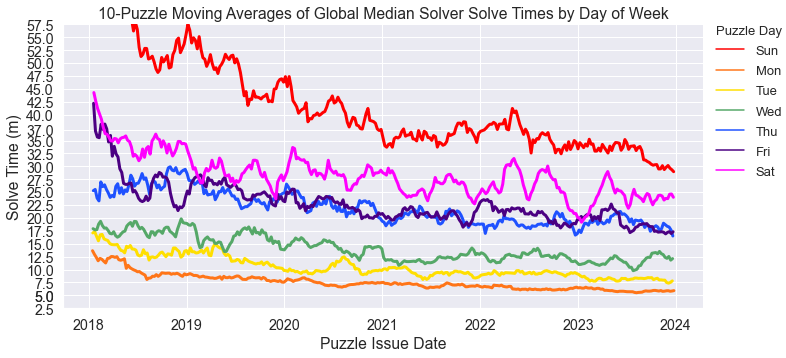

In [15]:
# Plot 10-puzzle moving average of Global Median Solve Times by Day of Week

sns.set(font_scale=1.3)

p = sns.relplot(
    data=df2, marker = "", x="P_Date", y="GMST(m)_10p_MA", hue="DOW", hue_order=["Sunday", "Monday", "Tuesday","Wednesday", "Thursday", "Friday", "Saturday"], height=5, aspect=2, palette = ["red", "#FF7518", "#ffdf00", "g", "#1F51FF", "indigo", "fuchsia"],
    kind="line", linewidth=3 
).set(title="10-Puzzle Moving Averages of Global Median Solver Solve Times by Day of Week", 
    ylabel="Solve Time (m)",
    xlabel= "Puzzle Issue Date", ylim=[2.5, 57.5], yticks = [2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5, 25, 27.5, 30, 32.5, 35, 37,5, 40, 42.5, 45, 47.5, 50, 52.5, 55, 57.5]
)

# Modify legend
leg = p._legend
leg.set_title("Puzzle Day")
leg.set_bbox_to_anchor([.83, .96])  # coordinates of lower left of bounding box
leg.get_title().set_fontsize(13)
leg._loc = 2  # if required you can set the loc
leg.get_texts()[0].set_fontsize(13)
leg.get_texts()[0].set_text('Sun')
leg.get_texts()[1].set_fontsize(13)
leg.get_texts()[1].set_text('Mon')
leg.get_texts()[2].set_fontsize(13)
leg.get_texts()[2].set_text('Tue')
leg.get_texts()[3].set_fontsize(13)
leg.get_texts()[3].set_text('Wed')
leg.get_texts()[4].set_fontsize(13)
leg.get_texts()[4].set_text('Thu')
leg.get_texts()[5].set_fontsize(13)
leg.get_texts()[5].set_text('Fri')
leg.get_texts()[6].set_fontsize(13)
leg.get_texts()[6].set_text('Sat')
leg._legend_box.align = "left"  # or left, or center

In [ ]:
df2.info()

In [ ]:
# Checkpoint
df2.to_csv('../data/df2.csv', index=False)

## Individual Solver 2 (IS2) Data Cleaning and Feature Creation

In [16]:
# Keep only puzzles for which IS2 has a solve time, and drop columns specific to Individual Solver 1 (IS1)
df_IS2 = df2.dropna(subset=['Time (s) (IS2)'])
df_IS2.drop(["Completed_Date (IS1)", "Time (s) (IS1)"], axis = 1, inplace=True)

In [ ]:
df_IS2.info()

In [ ]:
df_IS2.head()

In [17]:
# It will be useful to have IS2 puzzle completion dates as strings in other columns along with the datetimes 
df_IS2['Comp_Date_str'] = df_IS2['Completed_Date (IS2)'].dt.strftime('%Y-%m-%d') #we want datetime as a string to index into here

In [18]:
# Convert Individual Solver2 (IS2) solve times per puzzle to minutes and drop times in seconds
df_IS2["IST(m)"] = df_IS2["Time (s) (IS2)"]/60   #IST = Individual solver times 
df_IS2.drop(['Time (s) (IS2)'], axis=1, inplace=True)

In [19]:
# It will be useful to have year of puzzle completion for this solver in a separate column for analysis below
df_IS2['Comp_Yr'] = df_IS2['Completed_Date (IS2)'].dt.to_period('Y')
df_IS2['Comp_Yr'].value_counts()

2023    487
2020    282
2018     89
2022     79
2021     28
2019      9
Freq: A-DEC, Name: Comp_Yr, dtype: int64

In [20]:
# Also, a column indicating pre-2023 solve or 2023 solve
df_IS2.loc[(df_IS2["Comp_Yr"] == "2023"), "2023_solve"] = 1 #2023 solve
df_IS2.loc[(df_IS2["Comp_Yr"] != "2023"), "2023_solve"] = 0 #pre-2023 solve
df_IS2['2023_solve'].value_counts()

0.0    487
1.0    487
Name: 2023_solve, dtype: int64

In [21]:
# Rename a few columns for brevity and clarity
df_IS2.rename(columns={'Completed_Date (IS2)': 'Comp_Date', 'Constructors(by seniority)': 'Constructors'}, inplace=True)

In [22]:
# Move new columns to logical places in dataframe
col = df_IS2.pop('Comp_Date_str')
df_IS2.insert(7, col.name, col)

col = df_IS2.pop('Comp_Yr')
df_IS2.insert(8, col.name, col)

col = df_IS2.pop('2023_solve')
df_IS2.insert(9, col.name, col)

col = df_IS2.pop('IST(m)')
df_IS2.insert(10, col.name, col)

In [ ]:
df_IS2.info()

In [ ]:
df_IS2["Comp_Date"].head()

## Feature Calculations

In [23]:
# Calculate 10- and 20-puzzle moving average for individual solver (IS2) raw solve times, within Day of Week 
df_IS2 = df_IS2.sort_values(by=['DOW','Comp_Date'], ascending = True)

df_IS2['IST(m)_10p_MA'] = df_IS2.groupby('DOW')['IST(m)'].transform(lambda x: x.rolling(10, 3).mean().reset_index(drop=True))
df_IS2['IST(m)_20p_MA'] = df_IS2.groupby('DOW')['IST(m)'].transform(lambda x: x.rolling(20, 3).mean().reset_index(drop=True))

# Calculate deviation from 10- and 20- puzzle moving averages for individual solver
df_IS2['IS_Diff%_10pMA'] = (((df_IS2['IST(m)'] - df_IS2['IST(m)_10p_MA']))/((df_IS2['IST(m)'] + df_IS2['IST(m)_10p_MA'])/2)*100).round(2)
df_IS2['IS_Diff%_20pMA'] = (((df_IS2['IST(m)'] - df_IS2['IST(m)_20p_MA']))/((df_IS2['IST(m)'] + df_IS2['IST(m)_20p_MA'])/2)*100).round(2)

df_IS2 = df_IS2.sort_values(by=['DOW','Comp_Date'], ascending = False)

In [24]:
# Calculate solve time % difference from Global Median Solve Time, per solve
df_IS2['IS_Diff%_GMST'] = (((df_IS2['IST(m)'] - df_IS2['GMST(m)']))/((df_IS2['IST(m)'] + df_IS2['GMST(m)'])/2)*100).round(2)

# Now compute 10- and 20- puzzle moving averages for this difference from median solver
df_IS2 = df_IS2.sort_values(by=['DOW','Comp_Date'], ascending = True)
df_IS2['IS_Diff%_GMST_10pMA'] = df_IS2.groupby('DOW')['IS_Diff%_GMST'].transform(lambda x: x.rolling(10, 3).mean().reset_index(drop=True))

df_IS2 = df_IS2.sort_values(by=['DOW','Comp_Date'], ascending = True)
df_IS2['IS_Diff%_GMST_20pMA'] = df_IS2.groupby('DOW')['IS_Diff%_GMST'].transform(lambda x: x.rolling(20, 3).mean().reset_index(drop=True))

df_IS2 = df_IS2.sort_values(by=['DOW','Comp_Date'], ascending = False)

In [ ]:
df_IS2.info()

In [25]:
# Move new columns to logical places in dataframe
col = df_IS2.pop('IST(m)_10p_MA')
df_IS2.insert(11, col.name, col)

col = df_IS2.pop('IST(m)_20p_MA')
df_IS2.insert(12, col.name, col)

col = df_IS2.pop('IS_Diff%_10pMA')
df_IS2.insert(13, col.name, col)

col = df_IS2.pop('IS_Diff%_20pMA')
df_IS2.insert(14, col.name, col)

col = df_IS2.pop('IS_Diff%_GMST')
df_IS2.insert(15, col.name, col)

col = df_IS2.pop('IS_Diff%_GMST_10pMA')
df_IS2.insert(16, col.name, col)

col = df_IS2.pop('IS_Diff%_GMST_20pMA')
df_IS2.insert(17, col.name, col)

In [ ]:
# Checkpoint
df_IS2.to_csv('../data/df_IS2.csv', index=False)

## Individual Solver 2 (IS2) Figure Creation

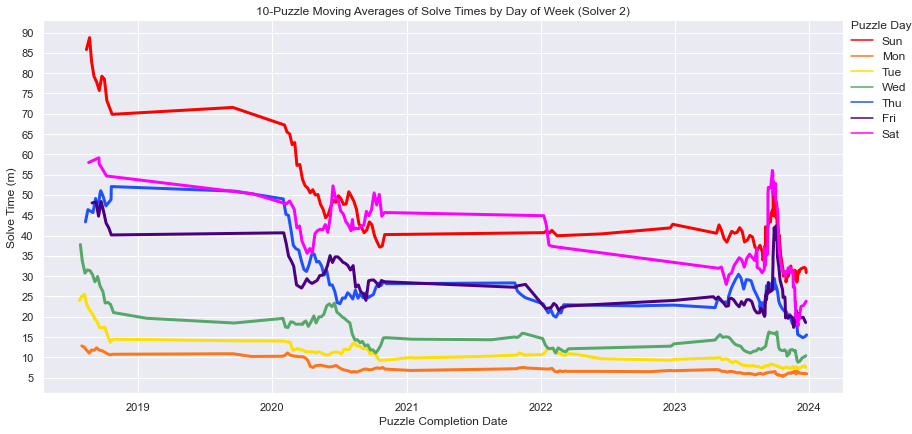

In [26]:
# Plot 10-puzzle moving average of Individual Solve Times by Day of Week

sns.set(font_scale= 1)

p = sns.relplot(
    data=df_IS2, marker = "", x="Comp_Date", y="IST(m)_10p_MA", hue="DOW", hue_order=["Sunday", "Monday", "Tuesday","Wednesday", "Thursday", "Friday", "Saturday"], height=6, aspect=2, palette = ["red", "#FF7518", "#ffdf00", "g", "#1F51FF", "indigo", "fuchsia"],
    kind="line", linewidth=3
).set(title="10-Puzzle Moving Averages of Solve Times by Day of Week (Solver 2)", 
    ylabel="Solve Time (m)",
    xlabel= "Puzzle Completion Date", yticks = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90]
)

# Modify legend
leg = p._legend
leg.set_title("Puzzle Day")
leg.set_bbox_to_anchor([.875, .98])  # coordinates of lower left of bounding box
leg.get_title().set_fontsize(12)
leg._loc = 2  # if required you can set the loc
leg.get_texts()[0].set_fontsize(12)
leg.get_texts()[0].set_text('Sun')
leg.get_texts()[1].set_fontsize(12)
leg.get_texts()[1].set_text('Mon')
leg.get_texts()[2].set_fontsize(12)
leg.get_texts()[2].set_text('Tue')
leg.get_texts()[3].set_fontsize(12)
leg.get_texts()[3].set_text('Wed')
leg.get_texts()[4].set_fontsize(12)
leg.get_texts()[4].set_text('Thu')
leg.get_texts()[5].set_fontsize(12)
leg.get_texts()[5].set_text('Fri')
leg.get_texts()[6].set_fontsize(12)
leg.get_texts()[6].set_text('Sat')
leg._legend_box.align = "left"  # or left, or center

In [ ]:
df_IS2_recent.info()

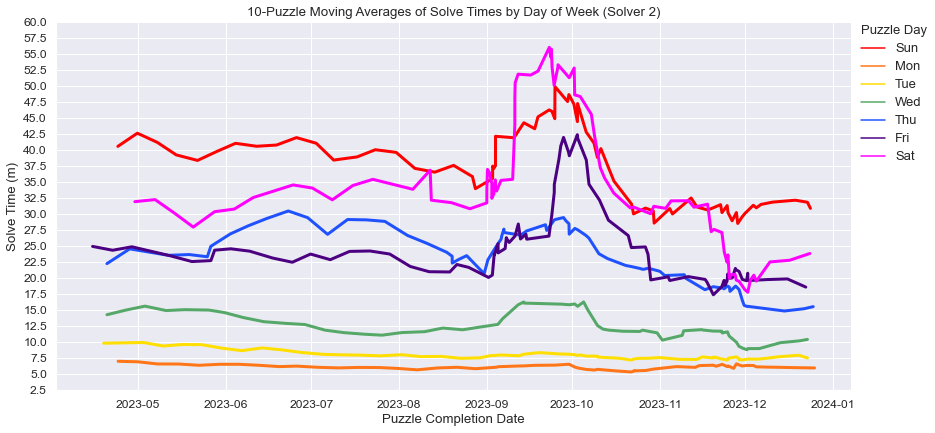

In [28]:
# Plot 10-puzzle moving average of Individual Solve Times by Day of Week -2022 and 2023 only
df_IS2_2023 = df_IS2.loc[(df_IS2["Comp_Yr"] == "2023")] 
sns.set(font_scale=1.1)

p = sns.relplot(
    data=df_IS2_2023, marker = "", x="Comp_Date", y="IST(m)_10p_MA", hue="DOW", hue_order=["Sunday", "Monday", "Tuesday","Wednesday", "Thursday", "Friday", "Saturday"], height=6, aspect=2, palette = ["red", "#FF7518", "#ffdf00", "g", "#1F51FF", "indigo", "fuchsia"],
    kind="line", linewidth=3
).set(title="10-Puzzle Moving Averages of Solve Times by Day of Week (Solver 2)", 
    ylabel="Solve Time (m)",
    xlabel= "Puzzle Completion Date", yticks = [2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5, 25, 27.5, 30, 32.5, 35, 37.5, 40, 42.5, 45, 47.5, 50, 52.5, 55, 57.5, 60]
)

# Modify legend
leg = p._legend
leg.set_title("Puzzle Day")
leg.set_bbox_to_anchor([.875, .97])  # coordinates of lower left of bounding box
leg.get_title().set_fontsize(13)
leg._loc = 2  # if required you can set the loc
leg.get_texts()[0].set_fontsize(13)
leg.get_texts()[0].set_text('Sun')
leg.get_texts()[1].set_fontsize(13)
leg.get_texts()[1].set_text('Mon')
leg.get_texts()[2].set_fontsize(13)
leg.get_texts()[2].set_text('Tue')
leg.get_texts()[3].set_fontsize(13)
leg.get_texts()[3].set_text('Wed')
leg.get_texts()[4].set_fontsize(13)
leg.get_texts()[4].set_text('Thu')
leg.get_texts()[5].set_fontsize(13)
leg.get_texts()[5].set_text('Fri')
leg.get_texts()[6].set_fontsize(13)
leg.get_texts()[6].set_text('Sat')
leg._legend_box.align = "left"  # or left, or center

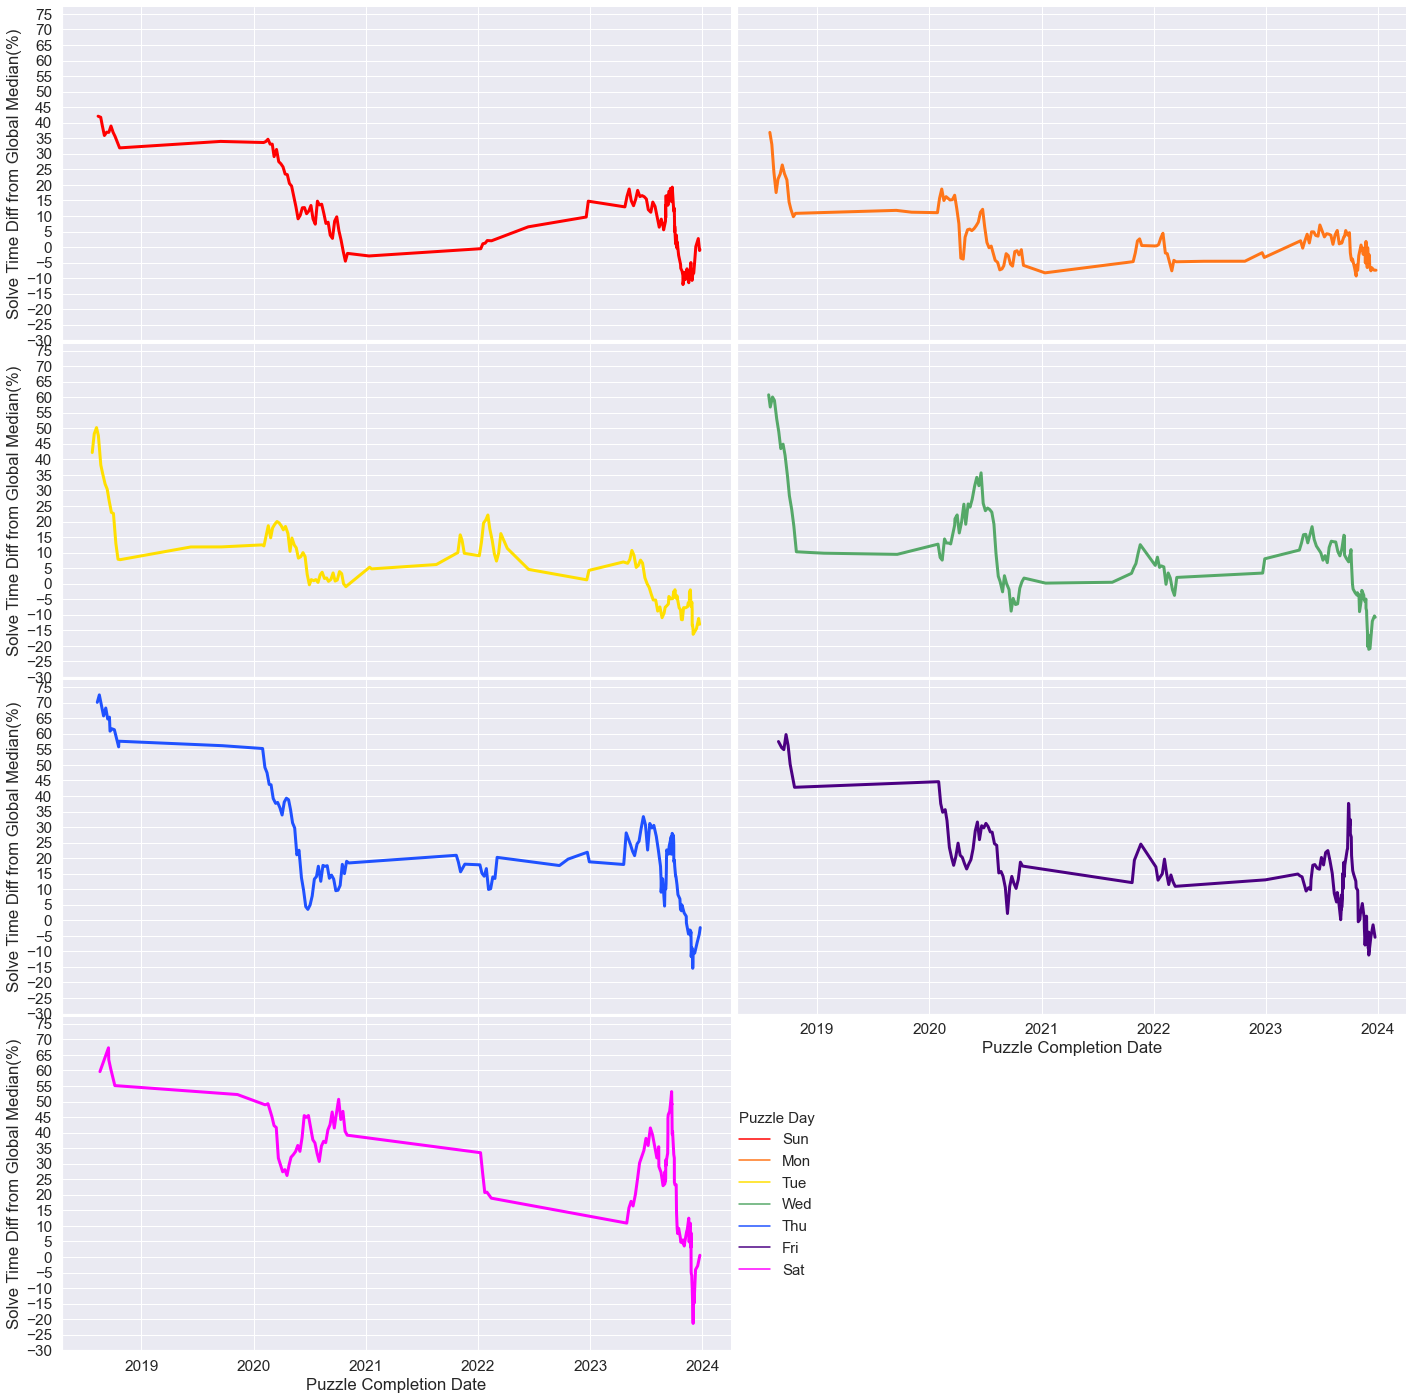

In [32]:
# Plot 10-puzzle moving average of % Difference in Individual Solve Times From Global Median Solve Times
# This normalizes for puzzle difficulty
sns.set(font_scale=1.4)
#sns.set(rc={'axes.facecolor':'gray',"axes.grid":True,'xtick.labelsize':14,'ytick.labelsize':14})

p = sns.relplot(
    data=df_IS2, marker = "", x="Comp_Date", y="IS_Diff%_GMST_10pMA", hue="DOW", hue_order=["Sunday", "Monday", "Tuesday","Wednesday", "Thursday", "Friday", "Saturday"], height=5, aspect=2, palette = ["red", "#FF7518", "#ffdf00", "g", "#1F51FF", "indigo", "fuchsia"],
    kind="line", linewidth=3, col="DOW", col_wrap=2, col_order=["Sunday", "Monday", "Tuesday","Wednesday", "Thursday", "Friday", "Saturday"]
).set(title="", ylabel="Solve Time Diff from Global Median(%)",
    xlabel= "Puzzle Completion Date", yticks = [-30, -25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75]
)

plt.subplots_adjust(wspace = 0.01) #decrease whitespace btwn subplot colums
plt.subplots_adjust(hspace = 0.01) #decrease whitespace btwn subplot rows

# # # Modify legend
leg = p._legend
leg.set_title("Puzzle Day")
leg.set_bbox_to_anchor([.46, .21])  # coordinates of lower left of bounding box
leg.get_title().set_fontsize(15)
leg._loc = 2  # if required you can set the loc
leg.get_texts()[0].set_fontsize(15)
leg.get_texts()[0].set_text('Sun')
leg.get_texts()[1].set_fontsize(15)
leg.get_texts()[1].set_text('Mon')
leg.get_texts()[2].set_fontsize(15)
leg.get_texts()[2].set_text('Tue')
leg.get_texts()[3].set_fontsize(15)
leg.get_texts()[3].set_text('Wed')
leg.get_texts()[4].set_fontsize(15)
leg.get_texts()[4].set_text('Thu')
leg.get_texts()[5].set_fontsize(15)
leg.get_texts()[5].set_text('Fri')
leg.get_texts()[6].set_fontsize(15)
leg.get_texts()[6].set_text('Sat')
leg._legend_box.align = "left"  # or left, or center

#title="10-Puzzle Moving Average of % Difference in Solve Times From Global Median Solve Times (Solver 1)", 

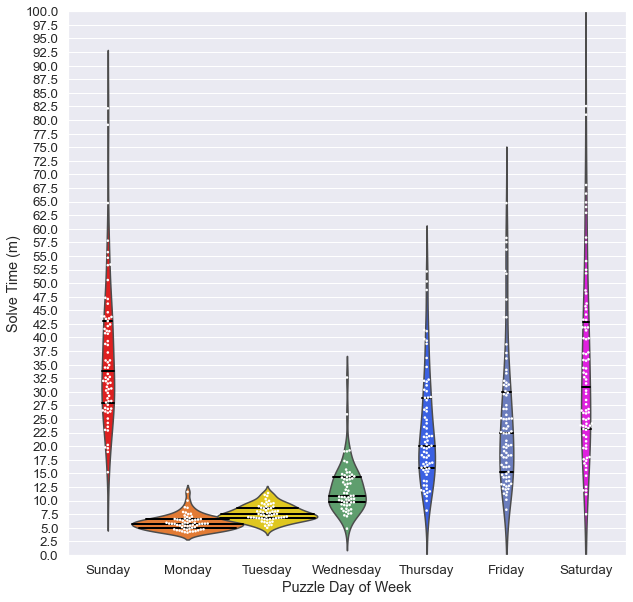

In [37]:
# Violin plots with swarm plot overlay by puzzle day -2023 only
sns.set(font_scale=1.2)
IS2_2023 = df_IS2.loc[df_IS2["Comp_Date_str"].str.contains("2023")]

plt.figure(figsize=(10,10))
sns.swarmplot(x="DOW" , y = "IST(m)",data=IS2_2023 , size=2.6, order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"], color="White")
ax = sns.violinplot(IS2_2023['DOW'], IS2_2023['IST(m)'], width = 1.4, inner = "quartile", order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"], palette = ["red", "#FF7518", "#ffdf00", "g", "#1F51FF", "#5d76cb", "fuchsia"])
plt.ylim(0, 100)
plt.yticks([0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5, 25, 27.5, 30, 32.5, 35, 37.5, 40, 42.5, 45, 47.5, 50, 52.5, 55, 57.5, 60, 62.5, 65, 67.5, 70, 72.5, 75, 77.5, 80, 82.5, 85, 87.5, 90, 92.5, 95, 97.5, 100])
ax.set_xlabel("Puzzle Day of Week")
ax.set_ylabel("Solve Time (m)")

for l in ax.lines:
    l.set_linestyle('-')
    l.set_linewidth(2)
    l.set_color('black')
    l.set_alpha(1)
plt.show()

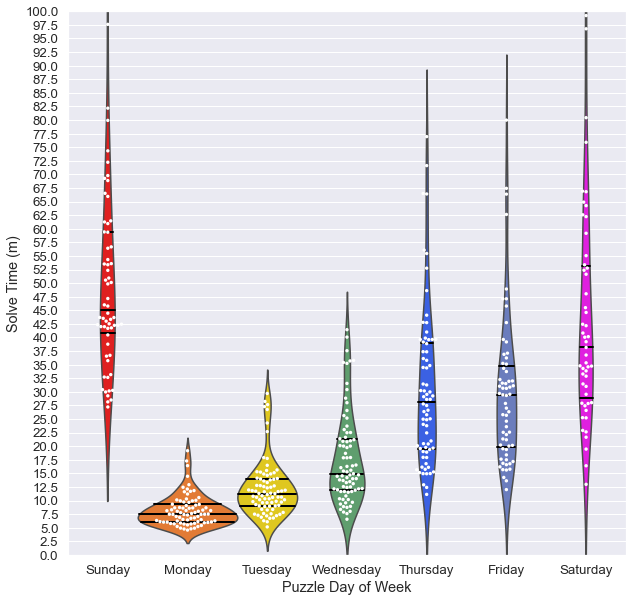

In [38]:
# Violin plots with swarm plot overlay by puzzle day pre-2023 solves only
sns.set(font_scale=1.2)
IS1_pre2023 = df_IS2.loc[df_IS2["Comp_Date_str"].str.contains("2022") | df_IS2["Comp_Date_str"].str.contains("2021") | df_IS2["Comp_Date_str"].str.contains("2020") | df_IS2["Comp_Date_str"].str.contains("2019") | df_IS2["Comp_Date_str"].str.contains("2018")]

plt.figure(figsize=(10,10))
sns.swarmplot(x="DOW" , y = "IST(m)",data=IS1_pre2023 , size=3.4 , order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"], color="White")
ax = sns.violinplot(IS1_pre2023['DOW'], IS1_pre2023['IST(m)'], width = 1.25, inner = "quartile", order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"], palette = ["red", "#FF7518", "#ffdf00", "g", "#1F51FF", "#5d76cb", "fuchsia"])
plt.ylim(0, 100)
plt.yticks([0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5, 25, 27.5, 30, 32.5, 35, 37.5, 40, 42.5, 45, 47.5, 50, 52.5, 55, 57.5, 60, 62.5, 65, 67.5, 70, 72.5, 75, 77.5, 80, 82.5, 85, 87.5, 90, 92.5, 95, 97.5, 100])
ax.set_xlabel("Puzzle Day of Week")
ax.set_ylabel("Solve Time (m)")

for l in ax.lines:
    l.set_linestyle('-')
    l.set_linewidth(2)
    l.set_color('black')
    l.set_alpha(1)
plt.show()

In [39]:
# Construct numerical categories in desired plotting sequence for combinations of puzzle day and pre-2023 or 2023
# This is a hack to be able to use lmplot with subplot split and get regression lines - need to figure out more elegant solution

# A numerical column for puzzle day that starts with Sunday and ends with Saturday
df_IS2.loc[(df_IS2["DOW"] == "Sunday") & (df_IS2["2023_solve"] == 0) , "plot_seq"] = 1 
df_IS2.loc[(df_IS2["DOW"] == "Sunday") & (df_IS2["2023_solve"] == 1) , "plot_seq"] = 2
df_IS2.loc[(df_IS2["DOW"] == "Monday") & (df_IS2["2023_solve"] == 0) , "plot_seq"] = 3 
df_IS2.loc[(df_IS2["DOW"] == "Monday") & (df_IS2["2023_solve"] == 1) , "plot_seq"] = 4
df_IS2.loc[(df_IS2["DOW"] == "Tuesday") & (df_IS2["2023_solve"] == 0) , "plot_seq"] = 5 
df_IS2.loc[(df_IS2["DOW"] == "Tuesday") & (df_IS2["2023_solve"] == 1) , "plot_seq"] = 6
df_IS2.loc[(df_IS2["DOW"] == "Wednesday") & (df_IS2["2023_solve"] == 0) , "plot_seq"] = 7 
df_IS2.loc[(df_IS2["DOW"] == "Wednesday") & (df_IS2["2023_solve"] == 1) , "plot_seq"] = 8
df_IS2.loc[(df_IS2["DOW"] == "Thursday") & (df_IS2["2023_solve"] == 0) , "plot_seq"] = 9 
df_IS2.loc[(df_IS2["DOW"] == "Thursday") & (df_IS2["2023_solve"] == 1) , "plot_seq"] = 10
df_IS2.loc[(df_IS2["DOW"] == "Friday") & (df_IS2["2023_solve"] == 0) , "plot_seq"] = 11 
df_IS2.loc[(df_IS2["DOW"] == "Friday") & (df_IS2["2023_solve"] == 1) , "plot_seq"] = 12
df_IS2.loc[(df_IS2["DOW"] == "Saturday") & (df_IS2["2023_solve"] == 0) , "plot_seq"] = 13 
df_IS2.loc[(df_IS2["DOW"] == "Saturday") & (df_IS2["2023_solve"] == 1) , "plot_seq"] = 14

In [ ]:
df_IS2["plot_seq"].unique()

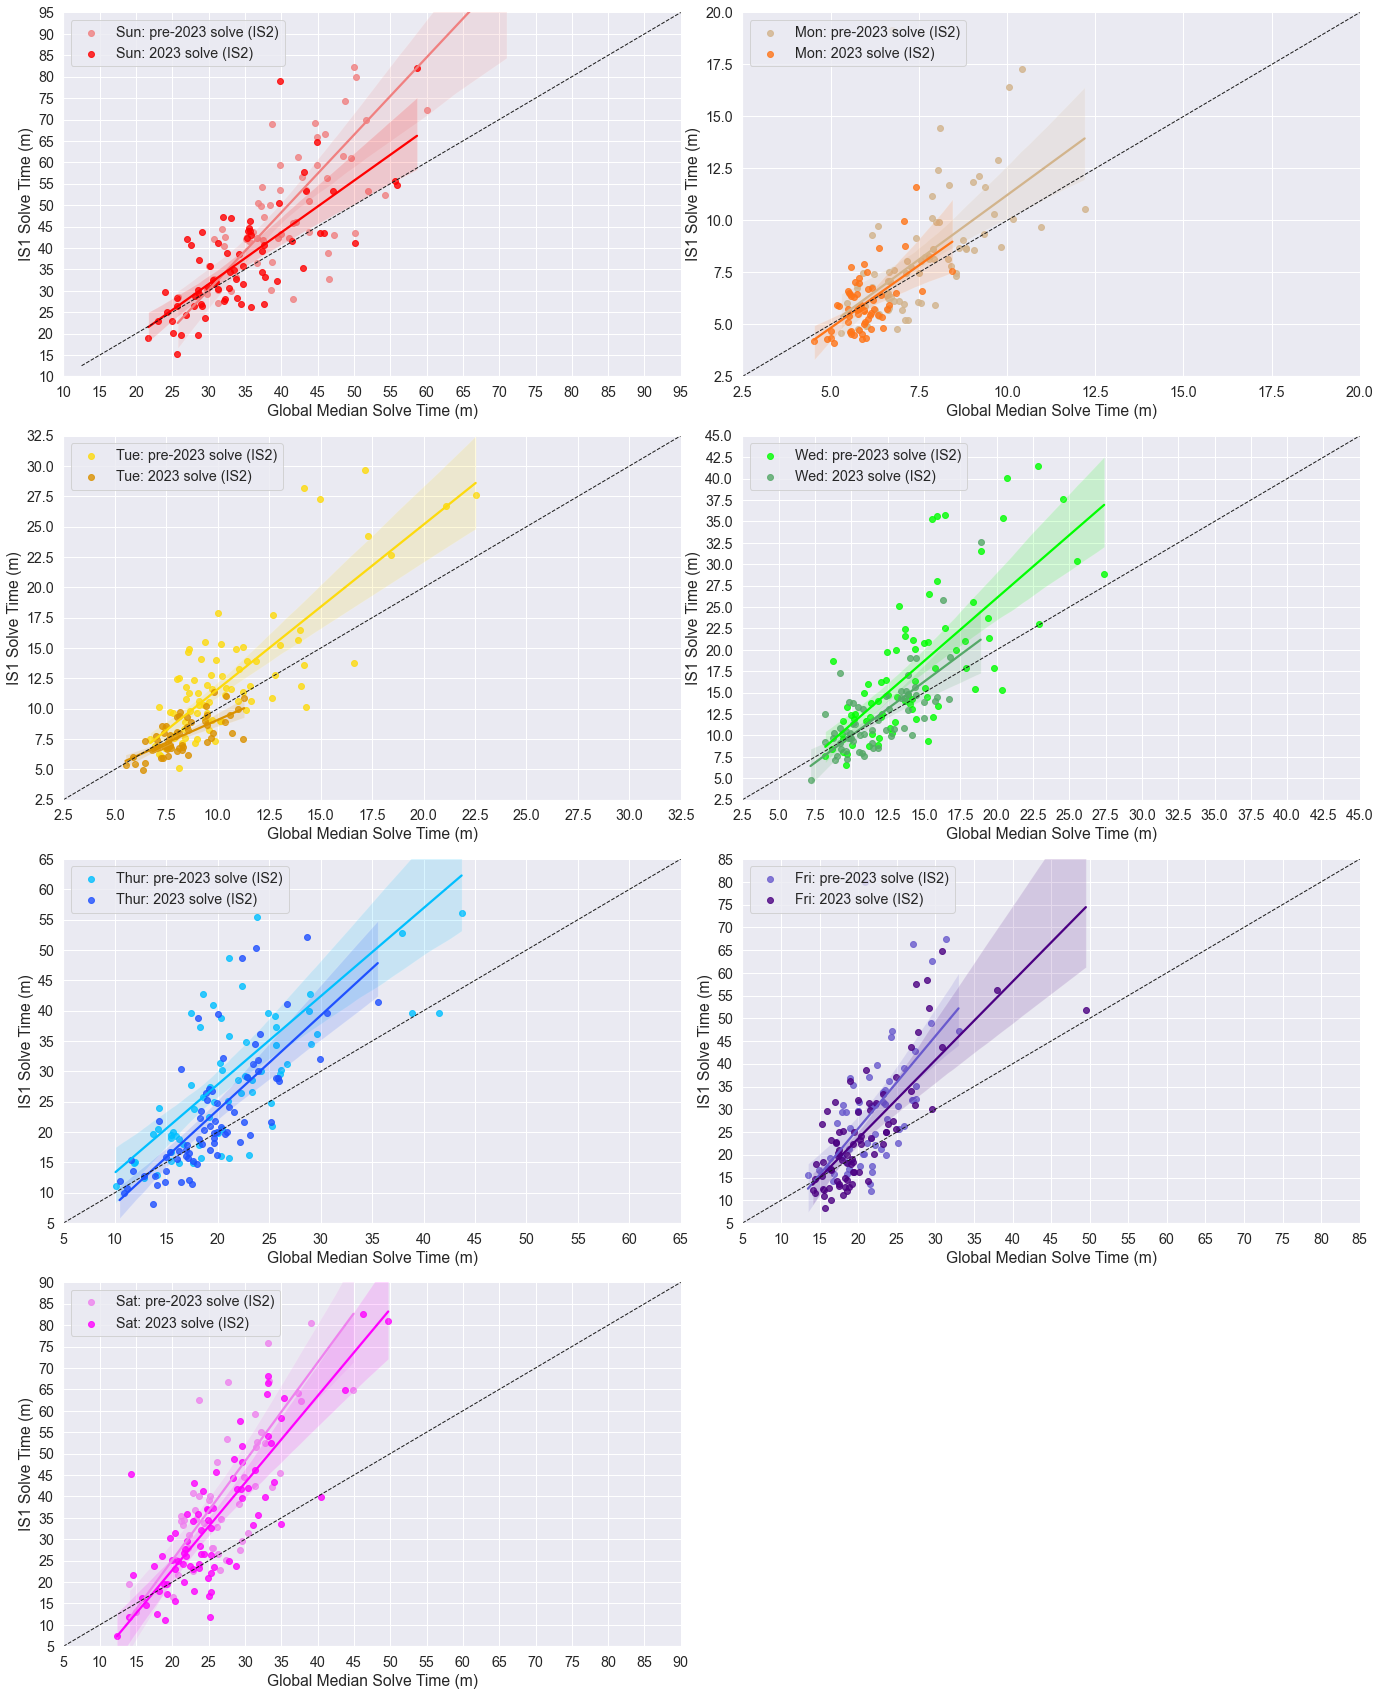

In [40]:
# Scatterplots of individual raw solve times vs global median solve times, per puzzle day

df_IS2 = df_IS2.sort_values(by=['plot_seq'], ascending = True)

sns.set(font_scale=1.3)

df_IS2['plot_seq_map'] = df_IS2['plot_seq'].map({1:'Sun: pre-2023 solve (IS2)', 2:'Sun: 2023 solve (IS2)', 3:'Mon: pre-2023 solve (IS2)', 4:'Mon: 2023 solve (IS2)', 5:'Tue: pre-2023 solve (IS2)', 6:'Tue: 2023 solve (IS2)', 7:'Wed: pre-2023 solve (IS2)', 8:'Wed: 2023 solve (IS2)', 9:'Thur: pre-2023 solve (IS2)', 10:'Thur: 2023 solve (IS2)', 11:'Fri: pre-2023 solve (IS2)', 12:'Fri: 2023 solve (IS2)', 13:'Sat: pre-2023 solve (IS2)', 14:'Sat: 2023 solve (IS2)'})

#sequence = {0:'pre-2023 solve', 1:'2023 solve', 2:'pre-2023 solve', 3:'2023 solve', 4:'pre-2023 solve', 5:'2023 solve', 6:'pre-2023 solve', 7:'2023 solve', 8:'pre-2023 solve', 9:'2023 solve', 10:'pre-2023 solve', 11:'2023 solve', 12:'pre-2023 solve', 13:'2023 solve'}

p = sns.lmplot(
    data=df_IS2, x="GMST(m)", y="IST(m)", hue="plot_seq_map", col="DOW", col_order=["Sunday", "Monday", "Tuesday","Wednesday", "Thursday", "Friday", "Saturday"], col_wrap=2, palette=["lightcoral", "red", "tan", "#FF7518", "#FDDA0D", "#da9100", "lime", "g", "deepskyblue", "#1F51FF", "slateblue", "indigo", "violet", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False
).set(title="", xlabel= "Global Median Solve Time (m)",
    ylabel="IS1 Solve Time (m)", xticks = [2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5, 25, 27.5, 30, 32.5, 35, 37.5, 40, 42.5, 45, 47.5, 50, 52.5, 55, 57.5, 60, 62.5, 65, 67.5, 70, 72.5, 75, 77.5, 80, 82.5], yticks = [2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5, 25, 27.5, 30, 32.5, 35, 37.5, 40, 42.5, 45, 47.5, 50, 52.5, 55, 57.5, 60, 62.5, 65, 67.5, 70, 72.5, 75, 77.5, 80, 82.5]  
)

plt.subplots_adjust(wspace = 0.1) #increase whitespace btwn subplot colums

#Adjust subplots individually
p.axes[0].set_ylim((10,95))
p.axes[0].set_xlim((10,95))
p.axes[0].set_yticks([10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95])
p.axes[0].set_xticks([10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95])

p.axes[1].set_ylim((2.5,20))
p.axes[1].set_xlim((2.5,20))

p.axes[2].set_ylim((2.5,32.5))
p.axes[2].set_xlim((2.5,32.5))

p.axes[3].set_ylim((2.5,45))
p.axes[3].set_xlim((2.5,45))

p.axes[4].set_ylim((5,65))
p.axes[4].set_xlim((5,65))
p.axes[4].set_yticks([5,10,15,20,25,30,35,40,45,50,55,60,65])
p.axes[4].set_xticks([5,10,15,20,25,30,35,40,45,50,55,60,65])

p.axes[5].set_ylim((5,85))
p.axes[5].set_xlim((5,85))
p.axes[5].set_yticks([5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85])
p.axes[5].set_xticks([5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85])

p.axes[6].set_ylim((5,90))
p.axes[6].set_xlim((5,90))
p.axes[6].set_yticks([5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90])
p.axes[6].set_xticks([5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90])

p.axes[0].plot([12.5, 95], [12.5, 95], 'k', linestyle='dashed', linewidth=1)
p.axes[1].plot([2.5, 20], [2.5, 20], 'k', linestyle='dashed', linewidth=1)
p.axes[2].plot([2.5, 32.5], [2.5, 32.5], 'k', linestyle='dashed', linewidth=1)
p.axes[3].plot([2.5, 45], [2.5, 45], 'k', linestyle='dashed', linewidth=1)
p.axes[4].plot([5, 65], [5, 65], 'k', linestyle='dashed', linewidth=1)
p.axes[5].plot([5, 85], [5, 85], 'k', linestyle='dashed', linewidth=1)
p.axes[6].plot([5, 90], [5, 90], 'k', linestyle='dashed', linewidth=1)

_= p.axes[0].legend(loc ="upper left")
_= p.axes[1].legend(loc ="upper left")
_= p.axes[2].legend(loc ="upper left")
_= p.axes[3].legend(loc ="upper left")
_= p.axes[4].legend(loc ="upper left")
_= p.axes[5].legend(loc ="upper left")
_= p.axes[6].legend(loc ="upper left")

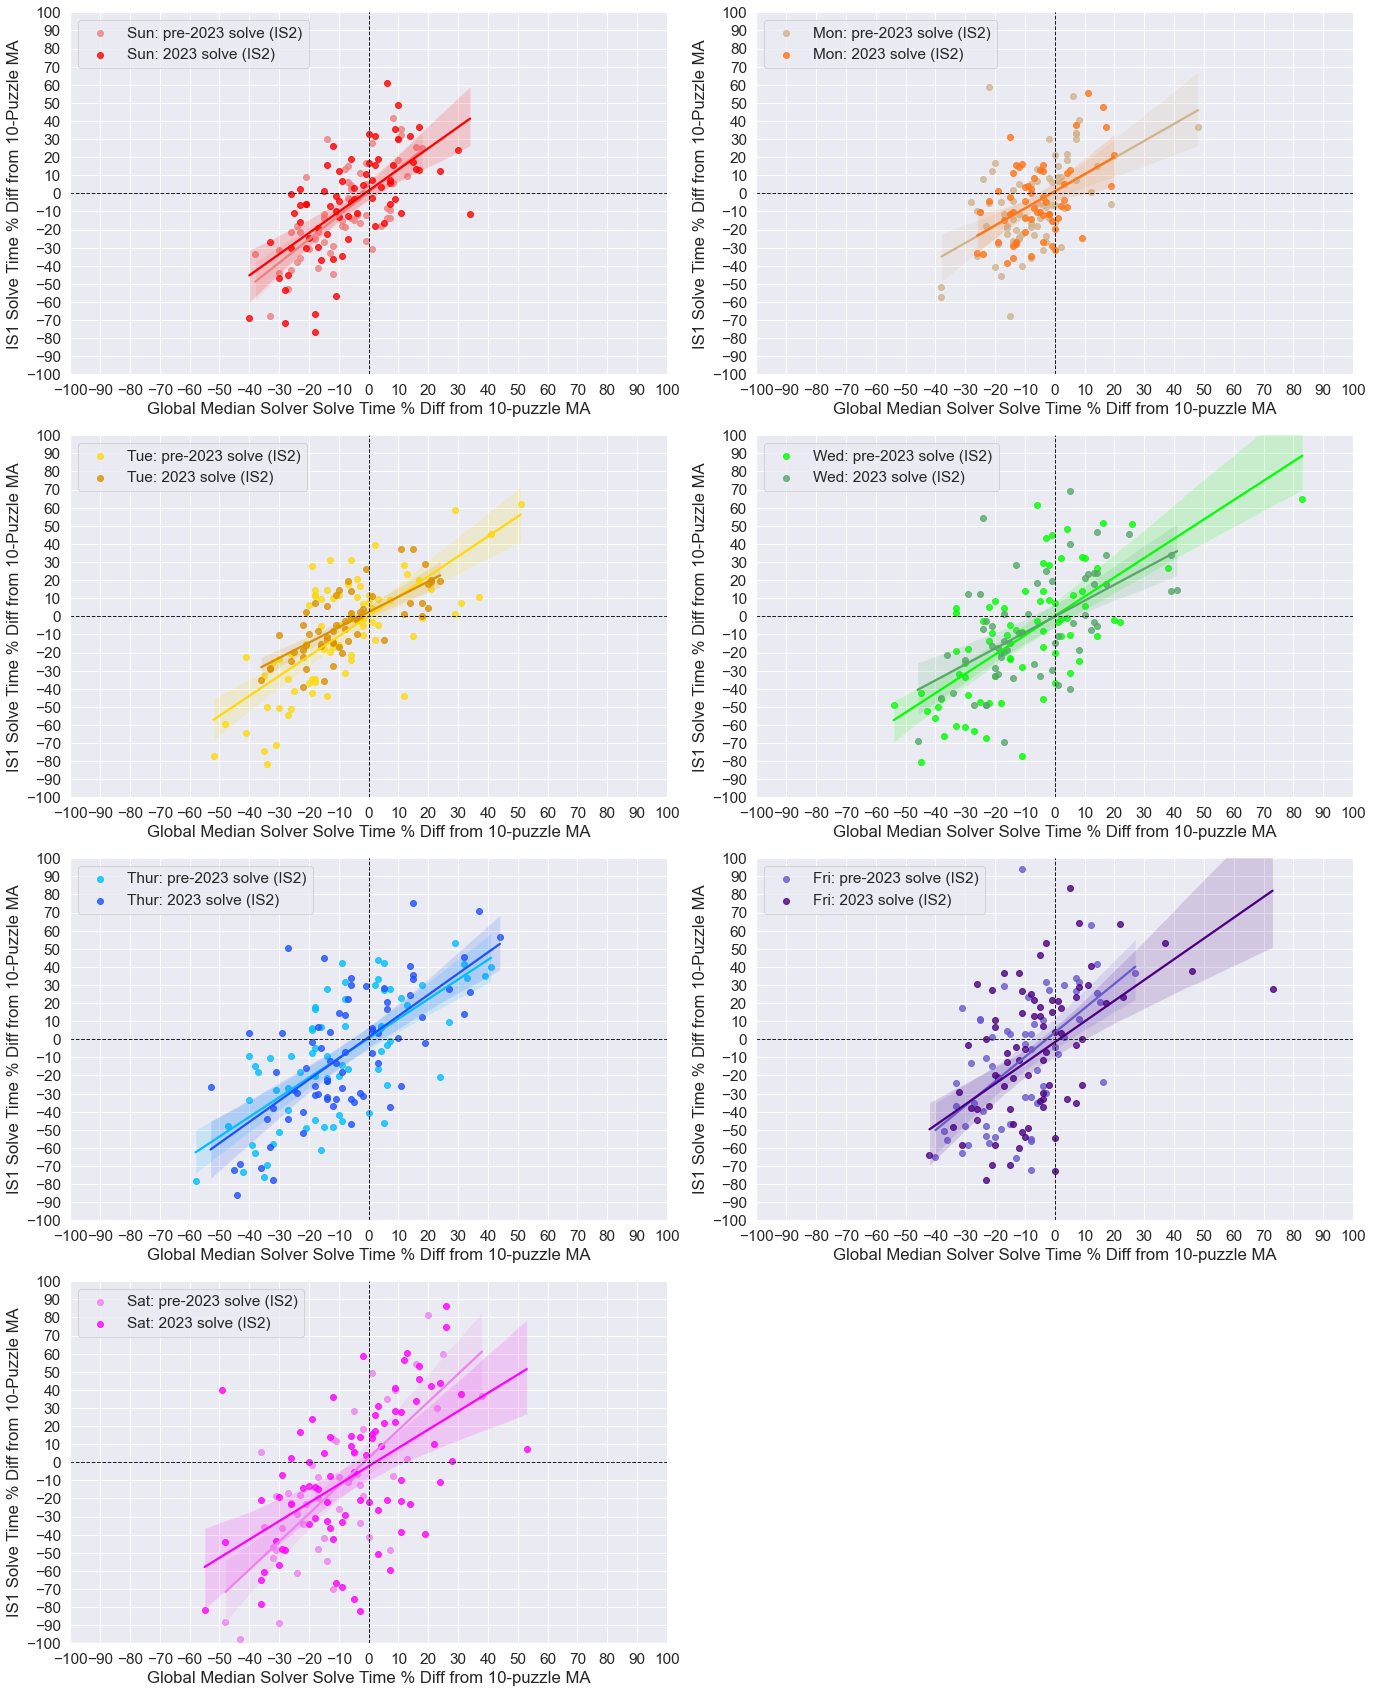

In [41]:
# Scatterplots of difference from 10-puzzle moving average for individual solver vs deviation from 10-puzzle moving average for global median solver, per puzzle day
# This isolates RELATIVE performance for the individual solver on a given puzzle vs their recent performance, and how that relative performance compares to that for the median solver

df_IS2 = df_IS2.sort_values(by=['plot_seq'], ascending = True)

sns.set(font_scale=1.4)

df_IS2['plot_seq_map'] = df_IS2['plot_seq'].map({1:'Sun: pre-2023 solve (IS2)', 2:'Sun: 2023 solve (IS2)', 3:'Mon: pre-2023 solve (IS2)', 4:'Mon: 2023 solve (IS2)', 5:'Tue: pre-2023 solve (IS2)', 6:'Tue: 2023 solve (IS2)', 7:'Wed: pre-2023 solve (IS2)', 8:'Wed: 2023 solve (IS2)', 9:'Thur: pre-2023 solve (IS2)', 10:'Thur: 2023 solve (IS2)', 11:'Fri: pre-2023 solve (IS2)', 12:'Fri: 2023 solve (IS2)', 13:'Sat: pre-2023 solve (IS2)', 14:'Sat: 2023 solve (IS2)'})

#sequence = {0:'pre-2023 solve', 1:'2023 solve', 2:'pre-2023 solve', 3:'2023 solve', 4:'pre-2023 solve', 5:'2023 solve', 6:'pre-2023 solve', 7:'2023 solve', 8:'pre-2023 solve', 9:'2023 solve', 10:'pre-2023 solve', 11:'2023 solve', 12:'pre-2023 solve', 13:'2023 solve'}

p = sns.lmplot(
    data=df_IS2, x="Diff%_from_10pMA(GMS)", y="IS_Diff%_10pMA", hue="plot_seq_map", col="DOW", col_order=["Sunday", "Monday", "Tuesday","Wednesday", "Thursday", "Friday", "Saturday"], col_wrap=2, palette=["lightcoral", "red", "tan", "#FF7518", "#FDDA0D", "#da9100", "lime", "g", "deepskyblue", "#1F51FF", "slateblue", "indigo", "violet", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False
).set(title="", xlabel= "Global Median Solver Solve Time % Diff from 10-puzzle MA",
    ylabel="IS1 Solve Time % Diff from 10-Puzzle MA", xticks = [-100,-90,-80,-70,-60,-50,-40,-30,-20,-10,0,10,20,30,40,50,60,70,80,90,100], yticks = [-100,-90,-80,-70,-60,-50,-40,-30,-20,-10,0,10,20,30,40,50,60,70,80,90,100]  
)

#Adjust subplots individually
p.axes[0].set_ylim((-100,100))
p.axes[0].set_xlim((-100,100))
p.axes[1].set_ylim((-100,100))
p.axes[1].set_xlim((-100,100))
p.axes[2].set_ylim((-100,100))
p.axes[2].set_xlim((-100,100))
p.axes[3].set_ylim((-100,100))
p.axes[3].set_xlim((-100,100))
p.axes[4].set_ylim((-100,100))
p.axes[4].set_xlim((-100,100))
p.axes[5].set_ylim((-100,100))
p.axes[5].set_xlim((-100,100))
p.axes[6].set_ylim((-100,100))
p.axes[6].set_xlim((-100,100))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

p.axes[0].plot([0, 0], [-100, 100], 'k', linestyle='dashed', linewidth=1)
p.axes[0].plot([-100, 100], [0, 0], 'k', linestyle='dashed', linewidth=1)
p.axes[1].plot([0, 0], [-100, 100], 'k', linestyle='dashed', linewidth=1)
p.axes[1].plot([-100, 100], [0, 0], 'k', linestyle='dashed', linewidth=1)
p.axes[2].plot([0, 0], [-100, 100], 'k', linestyle='dashed', linewidth=1)
p.axes[2].plot([-100, 100], [0, 0], 'k', linestyle='dashed', linewidth=1)
p.axes[3].plot([0, 0], [-100, 100], 'k', linestyle='dashed', linewidth=1)
p.axes[3].plot([-100, 100], [0, 0], 'k', linestyle='dashed', linewidth=1)
p.axes[4].plot([0, 0], [-100, 100], 'k', linestyle='dashed', linewidth=1)
p.axes[4].plot([-100, 100], [0, 0], 'k', linestyle='dashed', linewidth=1)
p.axes[5].plot([0, 0], [-100, 100], 'k', linestyle='dashed', linewidth=1)
p.axes[5].plot([-100, 100], [0, 0], 'k', linestyle='dashed', linewidth=1)
p.axes[6].plot([0, 0], [-100, 100], 'k', linestyle='dashed', linewidth=1)
p.axes[6].plot([-100, 100], [0, 0], 'k', linestyle='dashed', linewidth=1)

_= p.axes[0].legend(loc = 'upper left')
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')

In [42]:
df_IS2.drop(['plot_seq', 'plot_seq_map'], axis=1, inplace=True)

### Constructor Analysis
Which constructors does individual solver 2 (IS2) struggle against? Which ones does IS2 do well against? This analysis is with respect to average deviation from day-specific 10-puzzle moving average per constructor/constructor team (aligns with what we have available for the global median solver). 

In [43]:
# Get stats for Individual Solver
constructor_avgs_IS = df_IS2.groupby(['Constructors'])['IS_Diff%_10pMA'].agg(constructor_mean_IS=(np.mean), puzzle_count_IS=(np.count_nonzero))
constructor_avgs_IS["constructor_mean_IS"] = constructor_avgs_IS["constructor_mean_IS"].round(2)

#Get stats for Global Mean Solver
constructor_avgs_GMT = df_IS2.groupby(['Constructors'])['Diff%_from_10pMA(GMS)'].agg(constructor_mean_GMS=(np.mean), puzzle_count_GMS=(np.count_nonzero))
constructor_avgs_GMT["constructor_mean_GMS"] = constructor_avgs_GMT["constructor_mean_GMS"].round(2)

#Merge Individual and Global Mean stats into single df
constructor_avgs = constructor_avgs_IS.merge(constructor_avgs_GMT, on='Constructors', how='inner')

puzzle_min_threshold = 5 #min number of puzzles in sample for constructor/constructor team to be kept in the analysis 

# Pare down to only constructor(s) with at least n puzzles for which IS1 has completed
constructor_avgs_filter = constructor_avgs.loc[constructor_avgs['puzzle_count_IS'] >= puzzle_min_threshold] 

In [ ]:
constructor_avgs_filter.head(35)

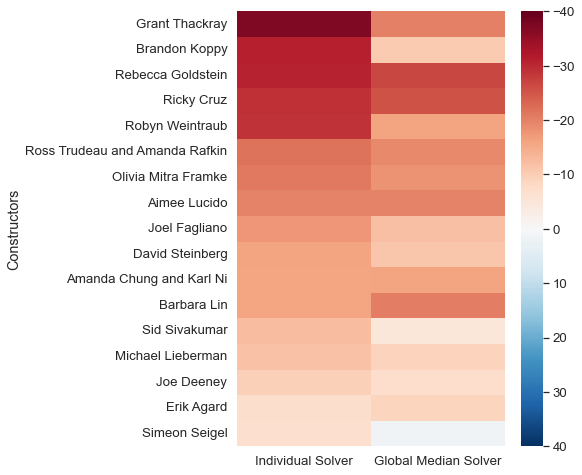

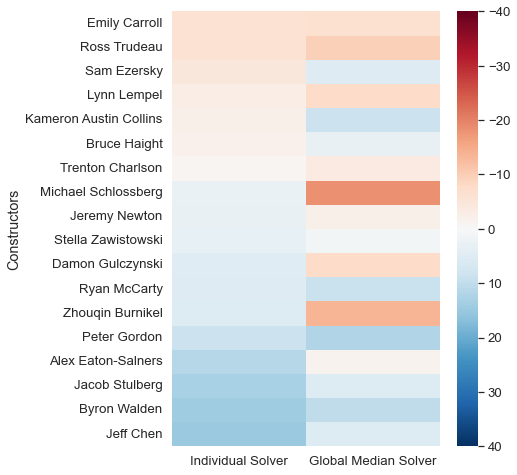

In [44]:
# Construct Heat Map sorted by fastest constructor relative to Individual solver 10 puzzle moving average to slowest

#Remove puzzle ns columns and sort for heatmapping
avgs = constructor_avgs_filter[["constructor_mean_IS", "constructor_mean_GMS"]]
avgs = avgs.sort_values(by=['constructor_mean_IS'], ascending = True)

first_half_end = int((len(avgs)/2)-1)
avgs_end = int(len(avgs))
first_half = avgs[0:first_half_end]
second_half = avgs[(first_half_end+1):avgs_end]

first_half = first_half.sort_values(by=['constructor_mean_IS'], ascending = True)
plt.figure(figsize=(6,8))
sns.set(font_scale=1.2)
ax = sns.heatmap(first_half, xticklabels=['Individual Solver', 'Global Median Solver'], cmap="RdBu", vmin=-40, vmax=40)
plt.gcf().axes[1].invert_yaxis() #flip color bar to show fastest at the top
# #plt.title("Mean % Solve Time Difference from 10-Puzzle Moving Average, Per Constructor")
plt.show()

second_half = second_half.sort_values(by=['constructor_mean_IS'], ascending = True)
plt.figure(figsize=(6,8))
sns.set(font_scale=1.2)
ax2 = sns.heatmap(second_half, xticklabels=['Individual Solver', 'Global Median Solver'], cmap="RdBu", vmin=-40, vmax=40)
plt.gcf().axes[1].invert_yaxis() #flip color bar to show fastest at the top
# plt.title("Mean % Solve Time Difference from 10-Puzzle Moving Average, Per Constructor")
plt.show()

In [45]:
#constructor_avgs_filter[["constructor_mean_IS"]].agg(['min', 'max'])
constructor_avgs_filter[["constructor_mean_GMS"]].agg(['min', 'max'])

constructor_mean_GMS
min                -26.67
max                 11.89

### Completion Time of Day Analysis

In [46]:
IS2_df2 = df_IS2.copy()

In [47]:
#Creates a column where Individual Solver completion timestamps are binned to the hour in 24-hour cycle
IS2_df2['Comp_Hr'] = IS2_df2['Comp_Date'].dt.hour
IS2_df2['Comp_Hr'].value_counts()
IS2_df2['Comp_Hr']= IS2_df2['Comp_Hr'].astype('int64')
IS2_df2 = IS2_df2.sort_values('Comp_Hr')

In [ ]:
IS2_df2.info()

In [48]:
col = IS2_df2.pop('Comp_Hr')
IS2_df2.insert(9, col.name, col)

In [49]:
# Construct numerical categories in desired plotting sequence for combinations of puzzle day and pre-2023 or 2023

IS2_df2.loc[(IS2_df2["DOW"] == "Sunday") & (IS2_df2["2023_solve"] == 0) , "plot_seq"] = 1 
IS2_df2.loc[(IS2_df2["DOW"] == "Sunday") & (IS2_df2["2023_solve"] == 1) , "plot_seq"] = 2
IS2_df2.loc[(IS2_df2["DOW"] == "Monday") & (IS2_df2["2023_solve"] == 0) , "plot_seq"] = 3 
IS2_df2.loc[(IS2_df2["DOW"] == "Monday") & (IS2_df2["2023_solve"] == 1) , "plot_seq"] = 4
IS2_df2.loc[(IS2_df2["DOW"] == "Tuesday") & (IS2_df2["2023_solve"] == 0) , "plot_seq"] = 5 
IS2_df2.loc[(IS2_df2["DOW"] == "Tuesday") & (IS2_df2["2023_solve"] == 1) , "plot_seq"] = 6
IS2_df2.loc[(IS2_df2["DOW"] == "Wednesday") & (IS2_df2["2023_solve"] == 0) , "plot_seq"] = 7 
IS2_df2.loc[(IS2_df2["DOW"] == "Wednesday") & (IS2_df2["2023_solve"] == 1) , "plot_seq"] = 8
IS2_df2.loc[(IS2_df2["DOW"] == "Thursday") & (IS2_df2["2023_solve"] == 0) , "plot_seq"] = 9 
IS2_df2.loc[(IS2_df2["DOW"] == "Thursday") & (IS2_df2["2023_solve"] == 1) , "plot_seq"] = 10
IS2_df2.loc[(IS2_df2["DOW"] == "Friday") & (IS2_df2["2023_solve"] == 0) , "plot_seq"] = 11 
IS2_df2.loc[(IS2_df2["DOW"] == "Friday") & (IS2_df2["2023_solve"] == 1) , "plot_seq"] = 12
IS2_df2.loc[(IS2_df2["DOW"] == "Saturday") & (IS2_df2["2023_solve"] == 0) , "plot_seq"] = 13 
IS2_df2.loc[(IS2_df2["DOW"] == "Saturday") & (IS2_df2["2023_solve"] == 1) , "plot_seq"] = 14

In [50]:
# For subplot collapsed across puzzle days for puzzle completions by hour of day, make a copy of all data, label it '0' and concatenate with
#main df

IS2_df2_copy = IS2_df2.copy()
IS2_df2_copy["DOW_num"] = 0

IS2_df2a = pd.concat([IS2_df2, IS2_df2_copy],ignore_index=True)

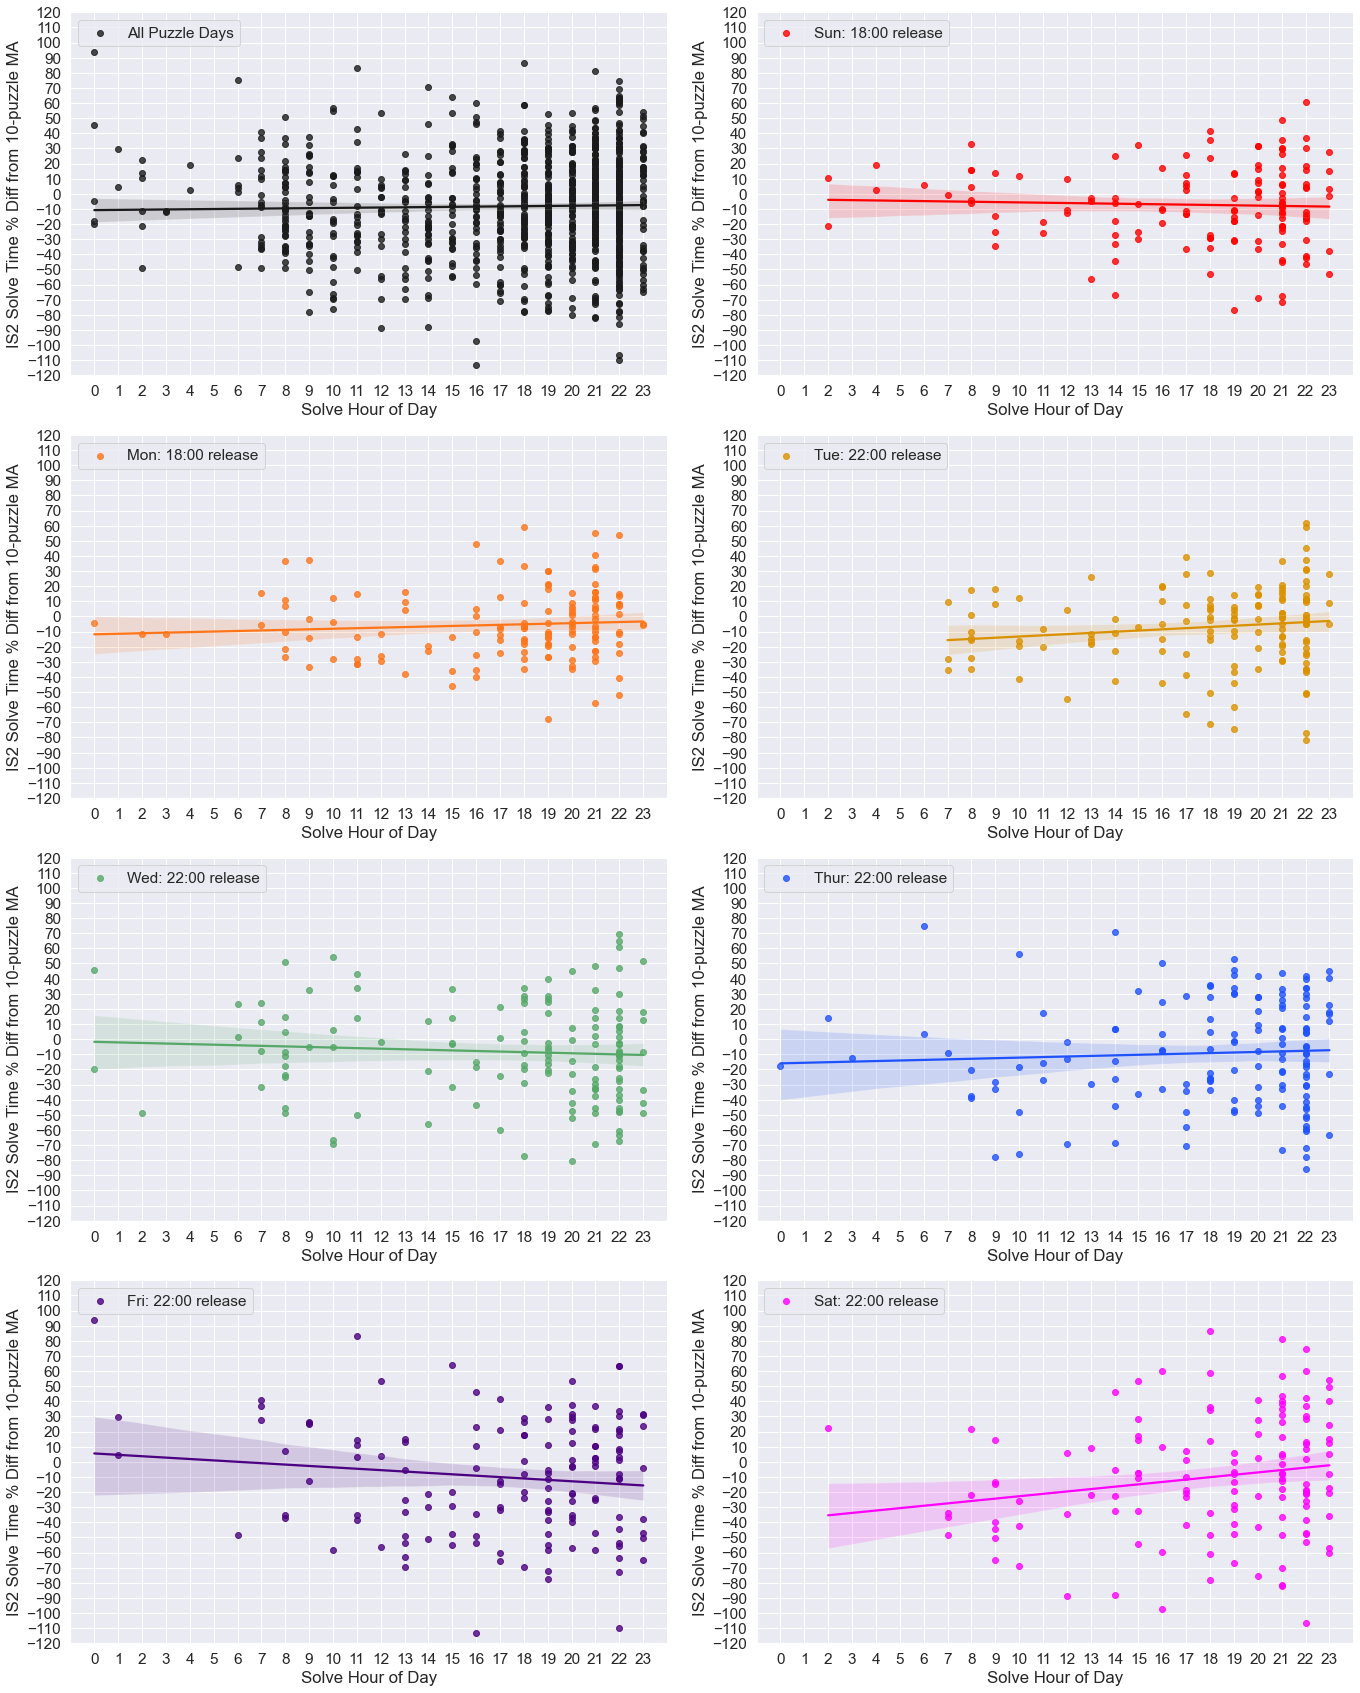

In [51]:
# Individual Solver 2 (IS2) Puzzle Completions by Solve Hour

IS2_df2a = IS2_df2a.sort_values(by=['DOW_num'], ascending = True)

IS2_df2a['plot_seq_map'] = IS2_df2a['DOW_num'].map({0: 'All Puzzle Days', 1:'Sun: 18:00 release', 2:'Mon: 18:00 release', 3:'Tue: 22:00 release', 4:'Wed: 22:00 release', 5: 'Thur: 22:00 release', 6:'Fri: 22:00 release', 7:'Sat: 22:00 release'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=IS2_df2a, x="Comp_Hr", y="IS_Diff%_10pMA", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], col_wrap=2, palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False
).set(title="", xlabel= "Solve Hour of Day",
    ylabel="Solve Time % Diff from 10-puzzle MA", yticks = [-120, -110, -100,-90,-80,-70,-60,-50,-40,-30,-20,-10,0,10,20,30,40,50,60,70,80,90,100, 110, 120], xticks = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]  
)

#Adjust subplots individually
p.axes[0].set_ylim((-120,120))
p.axes[0].set_xlim((-1,24))
p.axes[1].set_ylim((-120,120))
p.axes[1].set_xlim((-1,24))
p.axes[2].set_ylim((-120,120))
p.axes[2].set_xlim((-1,24))
p.axes[3].set_ylim((-120,120))
p.axes[3].set_xlim((-1,24))
p.axes[4].set_ylim((-120,120))
p.axes[4].set_xlim((-1,24))
p.axes[5].set_ylim((-120,120))
p.axes[5].set_xlim((-1,24))
p.axes[6].set_ylim((-120,120))
p.axes[6].set_xlim((-1,24))
p.axes[7].set_ylim((-120,120))
p.axes[7].set_xlim((-1,24))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

IS2_df2a.drop(['plot_seq_map'], axis=1, inplace=True)

### Puzzle and Answer-Features Correlation to Solve Times

In [52]:
# Make a deep copy of individual solver df
IS2_df3 = IS2_df2.copy()

In [112]:
IS2_df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 974 entries, 260 to 667
Data columns (total 57 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   P_Date                                  974 non-null    datetime64[ns]
 1   P_Date_str                              974 non-null    object        
 2   P_Yr                                    974 non-null    period[A-DEC] 
 3   2023_puzzle                             974 non-null    float64       
 4   DOW                                     974 non-null    object        
 5   DOW_num                                 974 non-null    float64       
 6   Comp_Date                               974 non-null    datetime64[ns]
 7   Comp_Date_str                           974 non-null    object        
 8   Comp_Yr                                 974 non-null    period[A-DEC] 
 9   Comp_Hr                                 974 non-null

Create a few new features for day-specific weighted solver past performance to use as frame of reference for the puzzle and answer-specific correlations

In [54]:
#IS_pds_l10_dw
#Provides decay-weighted(dw), puzzle day-specific (pds) mean solve time performance for the individual solver over the previous 10 puzzles

IS2_df3 = IS2_df3.sort_values(by=['DOW', 'Comp_Date'], ascending = False)

w = [10,9,8,7,6,5,4,3,2,1] #weight assigned to puzzle

IS2_df3["IS_pds_l10_dw_1"] = IS2_df3.groupby(['DOW'])['IST(m)'].shift(-1)*w[0]
IS2_df3["IS_pds_l10_dw_2"] = IS2_df3.groupby(['DOW'])['IST(m)'].shift(-2)*w[1]
IS2_df3["IS_pds_l10_dw_3"] = IS2_df3.groupby(['DOW'])['IST(m)'].shift(-3)*w[2]
IS2_df3["IS_pds_l10_dw_4"] = IS2_df3.groupby(['DOW'])['IST(m)'].shift(-4)*w[3]
IS2_df3["IS_pds_l10_dw_5"] = IS2_df3.groupby(['DOW'])['IST(m)'].shift(-5)*w[4]
IS2_df3["IS_pds_l10_dw_6"] = IS2_df3.groupby(['DOW'])['IST(m)'].shift(-6)*w[5]
IS2_df3["IS_pds_l10_dw_7"] = IS2_df3.groupby(['DOW'])['IST(m)'].shift(-7)*w[6]
IS2_df3["IS_pds_l10_dw_8"] = IS2_df3.groupby(['DOW'])['IST(m)'].shift(-8)*w[7]
IS2_df3["IS_pds_l10_dw_9"] = IS2_df3.groupby(['DOW'])['IST(m)'].shift(-9)*w[8]
IS2_df3["IS_pds_l10_dw_10"] = IS2_df3.groupby(['DOW'])['IST(m)'].shift(-10)*w[9]

IS2_df3["IS_pds_l10_dw_1_ct"] = (IS2_df3.groupby(['DOW'])['IST(m)'].shift(-1)/IS2_df3.groupby(['DOW'])['IST(m)'].shift(-1))*w[0]
IS2_df3["IS_pds_l10_dw_2_ct"] = (IS2_df3.groupby(['DOW'])['IST(m)'].shift(-2)/IS2_df3.groupby(['DOW'])['IST(m)'].shift(-2))*w[1]
IS2_df3["IS_pds_l10_dw_3_ct"] = (IS2_df3.groupby(['DOW'])['IST(m)'].shift(-3)/IS2_df3.groupby(['DOW'])['IST(m)'].shift(-3))*w[2]
IS2_df3["IS_pds_l10_dw_4_ct"] = (IS2_df3.groupby(['DOW'])['IST(m)'].shift(-4)/IS2_df3.groupby(['DOW'])['IST(m)'].shift(-4))*w[3]
IS2_df3["IS_pds_l10_dw_5_ct"] = (IS2_df3.groupby(['DOW'])['IST(m)'].shift(-5)/IS2_df3.groupby(['DOW'])['IST(m)'].shift(-5))*w[4]
IS2_df3["IS_pds_l10_dw_6_ct"] = (IS2_df3.groupby(['DOW'])['IST(m)'].shift(-6)/IS2_df3.groupby(['DOW'])['IST(m)'].shift(-6))*w[5]
IS2_df3["IS_pds_l10_dw_7_ct"] = (IS2_df3.groupby(['DOW'])['IST(m)'].shift(-7)/IS2_df3.groupby(['DOW'])['IST(m)'].shift(-7))*w[6]
IS2_df3["IS_pds_l10_dw_8_ct"] = (IS2_df3.groupby(['DOW'])['IST(m)'].shift(-8)/IS2_df3.groupby(['DOW'])['IST(m)'].shift(-8))*w[7]
IS2_df3["IS_pds_l10_dw_9_ct"] = (IS2_df3.groupby(['DOW'])['IST(m)'].shift(-9)/IS2_df3.groupby(['DOW'])['IST(m)'].shift(-9))*w[8]
IS2_df3["IS_pds_l10_dw_10_ct"] = (IS2_df3.groupby(['DOW'])['IST(m)'].shift(-10)/IS2_df3.groupby(['DOW'])['IST(m)'].shift(-10))*w[9]

IS2_df3["IS_pds_l10_ws"] = IS2_df3[["IS_pds_l10_dw_1", "IS_pds_l10_dw_2", "IS_pds_l10_dw_3", "IS_pds_l10_dw_4", "IS_pds_l10_dw_5", "IS_pds_l10_dw_6", "IS_pds_l10_dw_7", "IS_pds_l10_dw_8", "IS_pds_l10_dw_9", "IS_pds_l10_dw_10"]].sum(axis=1)
IS2_df3["IS_pds_l10_ws_ct"] = IS2_df3[["IS_pds_l10_dw_1_ct", "IS_pds_l10_dw_2_ct", "IS_pds_l10_dw_3_ct", "IS_pds_l10_dw_4_ct", "IS_pds_l10_dw_5_ct", "IS_pds_l10_dw_6_ct", "IS_pds_l10_dw_7_ct", "IS_pds_l10_dw_8_ct", "IS_pds_l10_dw_9_ct", "IS_pds_l10_dw_10_ct"]].sum(axis=1)
IS2_df3["IS_pds_l10_dw"] = IS2_df3["IS_pds_l10_ws"]/IS2_df3["IS_pds_l10_ws_ct"]

# Deleting transient columns
IS2_df3 = IS2_df3.drop(["IS_pds_l10_dw_1", "IS_pds_l10_dw_2", "IS_pds_l10_dw_3", "IS_pds_l10_dw_4", "IS_pds_l10_dw_5", "IS_pds_l10_dw_6", "IS_pds_l10_dw_7", "IS_pds_l10_dw_8", "IS_pds_l10_dw_9", "IS_pds_l10_dw_10", "IS_pds_l10_dw_1_ct", "IS_pds_l10_dw_2_ct", "IS_pds_l10_dw_3_ct", "IS_pds_l10_dw_4_ct", "IS_pds_l10_dw_5_ct", "IS_pds_l10_dw_6_ct", "IS_pds_l10_dw_7_ct", "IS_pds_l10_dw_8_ct", "IS_pds_l10_dw_9_ct", "IS_pds_l10_dw_10_ct", "IS_pds_l10_ws", "IS_pds_l10_ws_ct"], axis = 1)

In [55]:
#IS_pds_l20_dw
#Provides decay-weighted(dw), puzzle day-specific (pds) mean solve time performance for the individual solver over the previous 20 puzzles

IS2_df3 = IS2_df3.sort_values(by=['DOW', 'Comp_Date'], ascending = False)

w = [20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1] #weight assigned to puzzle

IS2_df3["IS_pds_l20_dw_1"] = IS2_df3.groupby(['DOW'])['IST(m)'].shift(-1)*w[0]
IS2_df3["IS_pds_l20_dw_2"] = IS2_df3.groupby(['DOW'])['IST(m)'].shift(-2)*w[1]
IS2_df3["IS_pds_l20_dw_3"] = IS2_df3.groupby(['DOW'])['IST(m)'].shift(-3)*w[2]
IS2_df3["IS_pds_l20_dw_4"] = IS2_df3.groupby(['DOW'])['IST(m)'].shift(-4)*w[3]
IS2_df3["IS_pds_l20_dw_5"] = IS2_df3.groupby(['DOW'])['IST(m)'].shift(-5)*w[4]
IS2_df3["IS_pds_l20_dw_6"] = IS2_df3.groupby(['DOW'])['IST(m)'].shift(-6)*w[5]
IS2_df3["IS_pds_l20_dw_7"] = IS2_df3.groupby(['DOW'])['IST(m)'].shift(-7)*w[6]
IS2_df3["IS_pds_l20_dw_8"] = IS2_df3.groupby(['DOW'])['IST(m)'].shift(-8)*w[7]
IS2_df3["IS_pds_l20_dw_9"] = IS2_df3.groupby(['DOW'])['IST(m)'].shift(-9)*w[8]
IS2_df3["IS_pds_l20_dw_10"] = IS2_df3.groupby(['DOW'])['IST(m)'].shift(-10)*w[9]
IS2_df3["IS_pds_l20_dw_11"] = IS2_df3.groupby(['DOW'])['IST(m)'].shift(-11)*w[10]
IS2_df3["IS_pds_l20_dw_12"] = IS2_df3.groupby(['DOW'])['IST(m)'].shift(-12)*w[11]
IS2_df3["IS_pds_l20_dw_13"] = IS2_df3.groupby(['DOW'])['IST(m)'].shift(-13)*w[12]
IS2_df3["IS_pds_l20_dw_14"] = IS2_df3.groupby(['DOW'])['IST(m)'].shift(-14)*w[13]
IS2_df3["IS_pds_l20_dw_15"] = IS2_df3.groupby(['DOW'])['IST(m)'].shift(-15)*w[14]
IS2_df3["IS_pds_l20_dw_16"] = IS2_df3.groupby(['DOW'])['IST(m)'].shift(-16)*w[15]
IS2_df3["IS_pds_l20_dw_17"] = IS2_df3.groupby(['DOW'])['IST(m)'].shift(-17)*w[16]
IS2_df3["IS_pds_l20_dw_18"] = IS2_df3.groupby(['DOW'])['IST(m)'].shift(-18)*w[17]
IS2_df3["IS_pds_l20_dw_19"] = IS2_df3.groupby(['DOW'])['IST(m)'].shift(-19)*w[18]
IS2_df3["IS_pds_l20_dw_20"] = IS2_df3.groupby(['DOW'])['IST(m)'].shift(-20)*w[19]

IS2_df3["IS_pds_l20_dw_1_ct"] = (IS2_df3.groupby(['DOW'])['IST(m)'].shift(-1)/IS2_df3.groupby(['DOW'])['IST(m)'].shift(-1))*w[0]
IS2_df3["IS_pds_l20_dw_2_ct"] = (IS2_df3.groupby(['DOW'])['IST(m)'].shift(-2)/IS2_df3.groupby(['DOW'])['IST(m)'].shift(-2))*w[1]
IS2_df3["IS_pds_l20_dw_3_ct"] = (IS2_df3.groupby(['DOW'])['IST(m)'].shift(-3)/IS2_df3.groupby(['DOW'])['IST(m)'].shift(-3))*w[2]
IS2_df3["IS_pds_l20_dw_4_ct"] = (IS2_df3.groupby(['DOW'])['IST(m)'].shift(-4)/IS2_df3.groupby(['DOW'])['IST(m)'].shift(-4))*w[3]
IS2_df3["IS_pds_l20_dw_5_ct"] = (IS2_df3.groupby(['DOW'])['IST(m)'].shift(-5)/IS2_df3.groupby(['DOW'])['IST(m)'].shift(-5))*w[4]
IS2_df3["IS_pds_l20_dw_6_ct"] = (IS2_df3.groupby(['DOW'])['IST(m)'].shift(-6)/IS2_df3.groupby(['DOW'])['IST(m)'].shift(-6))*w[5]
IS2_df3["IS_pds_l20_dw_7_ct"] = (IS2_df3.groupby(['DOW'])['IST(m)'].shift(-7)/IS2_df3.groupby(['DOW'])['IST(m)'].shift(-7))*w[6]
IS2_df3["IS_pds_l20_dw_8_ct"] = (IS2_df3.groupby(['DOW'])['IST(m)'].shift(-8)/IS2_df3.groupby(['DOW'])['IST(m)'].shift(-8))*w[7]
IS2_df3["IS_pds_l20_dw_9_ct"] = (IS2_df3.groupby(['DOW'])['IST(m)'].shift(-9)/IS2_df3.groupby(['DOW'])['IST(m)'].shift(-9))*w[8]
IS2_df3["IS_pds_l20_dw_10_ct"] = (IS2_df3.groupby(['DOW'])['IST(m)'].shift(-10)/IS2_df3.groupby(['DOW'])['IST(m)'].shift(-10))*w[9]
IS2_df3["IS_pds_l20_dw_11_ct"] = (IS2_df3.groupby(['DOW'])['IST(m)'].shift(-11)/IS2_df3.groupby(['DOW'])['IST(m)'].shift(-11))*w[10]
IS2_df3["IS_pds_l20_dw_12_ct"] = (IS2_df3.groupby(['DOW'])['IST(m)'].shift(-12)/IS2_df3.groupby(['DOW'])['IST(m)'].shift(-12))*w[11]
IS2_df3["IS_pds_l20_dw_13_ct"] = (IS2_df3.groupby(['DOW'])['IST(m)'].shift(-13)/IS2_df3.groupby(['DOW'])['IST(m)'].shift(-13))*w[12]
IS2_df3["IS_pds_l20_dw_14_ct"] = (IS2_df3.groupby(['DOW'])['IST(m)'].shift(-14)/IS2_df3.groupby(['DOW'])['IST(m)'].shift(-14))*w[13]
IS2_df3["IS_pds_l20_dw_15_ct"] = (IS2_df3.groupby(['DOW'])['IST(m)'].shift(-15)/IS2_df3.groupby(['DOW'])['IST(m)'].shift(-15))*w[14]
IS2_df3["IS_pds_l20_dw_16_ct"] = (IS2_df3.groupby(['DOW'])['IST(m)'].shift(-16)/IS2_df3.groupby(['DOW'])['IST(m)'].shift(-16))*w[15]
IS2_df3["IS_pds_l20_dw_17_ct"] = (IS2_df3.groupby(['DOW'])['IST(m)'].shift(-17)/IS2_df3.groupby(['DOW'])['IST(m)'].shift(-17))*w[16]
IS2_df3["IS_pds_l20_dw_18_ct"] = (IS2_df3.groupby(['DOW'])['IST(m)'].shift(-18)/IS2_df3.groupby(['DOW'])['IST(m)'].shift(-18))*w[17]
IS2_df3["IS_pds_l20_dw_19_ct"] = (IS2_df3.groupby(['DOW'])['IST(m)'].shift(-19)/IS2_df3.groupby(['DOW'])['IST(m)'].shift(-19))*w[18]
IS2_df3["IS_pds_l20_dw_20_ct"] = (IS2_df3.groupby(['DOW'])['IST(m)'].shift(-20)/IS2_df3.groupby(['DOW'])['IST(m)'].shift(-20))*w[19]

IS2_df3["IS_pds_l20_ws"] = IS2_df3[["IS_pds_l20_dw_1", "IS_pds_l20_dw_2", "IS_pds_l20_dw_3", "IS_pds_l20_dw_4", "IS_pds_l20_dw_5", "IS_pds_l20_dw_6", "IS_pds_l20_dw_7", "IS_pds_l20_dw_8", "IS_pds_l20_dw_9", "IS_pds_l20_dw_10", "IS_pds_l20_dw_11", "IS_pds_l20_dw_12", "IS_pds_l20_dw_13", "IS_pds_l20_dw_14", "IS_pds_l20_dw_15", "IS_pds_l20_dw_16", "IS_pds_l20_dw_17", "IS_pds_l20_dw_18", "IS_pds_l20_dw_19", "IS_pds_l20_dw_20"]].sum(axis=1)
IS2_df3["IS_pds_l20_ws_ct"] = IS2_df3[["IS_pds_l20_dw_1_ct", "IS_pds_l20_dw_2_ct", "IS_pds_l20_dw_3_ct", "IS_pds_l20_dw_4_ct", "IS_pds_l20_dw_5_ct", "IS_pds_l20_dw_6_ct", "IS_pds_l20_dw_7_ct", "IS_pds_l20_dw_8_ct", "IS_pds_l20_dw_9_ct", "IS_pds_l20_dw_10_ct", "IS_pds_l20_dw_11_ct", "IS_pds_l20_dw_12_ct", "IS_pds_l20_dw_13_ct", "IS_pds_l20_dw_14_ct", "IS_pds_l20_dw_15_ct", "IS_pds_l20_dw_16_ct", "IS_pds_l20_dw_17_ct", "IS_pds_l20_dw_18_ct", "IS_pds_l20_dw_19_ct", "IS_pds_l20_dw_20_ct"]].sum(axis=1)
IS2_df3["IS_pds_l20_dw"] = IS2_df3["IS_pds_l20_ws"]/IS2_df3["IS_pds_l20_ws_ct"]

# Deleting transient columns
IS2_df3 = IS2_df3.drop(["IS_pds_l20_dw_1", "IS_pds_l20_dw_2", "IS_pds_l20_dw_3", "IS_pds_l20_dw_4", "IS_pds_l20_dw_5", "IS_pds_l20_dw_6", "IS_pds_l20_dw_7", "IS_pds_l20_dw_8", "IS_pds_l20_dw_9", "IS_pds_l20_dw_10", "IS_pds_l20_dw_11", "IS_pds_l20_dw_12", "IS_pds_l20_dw_13", "IS_pds_l20_dw_14", "IS_pds_l20_dw_15", "IS_pds_l20_dw_16", "IS_pds_l20_dw_17", "IS_pds_l20_dw_18", "IS_pds_l20_dw_19", "IS_pds_l20_dw_20", "IS_pds_l20_dw_1_ct", "IS_pds_l20_dw_2_ct", "IS_pds_l20_dw_3_ct", "IS_pds_l20_dw_4_ct", "IS_pds_l20_dw_5_ct", "IS_pds_l20_dw_6_ct", "IS_pds_l20_dw_7_ct", "IS_pds_l20_dw_8_ct", "IS_pds_l20_dw_9_ct", "IS_pds_l20_dw_10_ct", "IS_pds_l20_dw_11_ct", "IS_pds_l20_dw_12_ct", "IS_pds_l20_dw_13_ct", "IS_pds_l20_dw_14_ct", "IS_pds_l20_dw_15_ct", "IS_pds_l20_dw_16_ct", "IS_pds_l20_dw_17_ct", "IS_pds_l20_dw_18_ct", "IS_pds_l20_dw_19_ct", "IS_pds_l20_dw_20_ct", "IS_pds_l20_ws", "IS_pds_l20_ws_ct"], axis = 1)

In [56]:
#IS_pds_l10_nndw
#Provides NON decay-weighted(ndw), puzzle day-specific (pds) mean solve time performance for the individual solver over the previous 10 puzzles

IS2_df3 = IS2_df3.sort_values(by=['DOW', 'Comp_Date'], ascending = False)

w = [1,1,1,1,1,1,1,1,1,1] #weight assigned to puzzle (equal for this variant)

IS2_df3["IS_pds_l10_ndw_1"] = IS2_df3.groupby(['DOW'])['IST(m)'].shift(-1)*w[0]
IS2_df3["IS_pds_l10_ndw_2"] = IS2_df3.groupby(['DOW'])['IST(m)'].shift(-2)*w[1]
IS2_df3["IS_pds_l10_ndw_3"] = IS2_df3.groupby(['DOW'])['IST(m)'].shift(-3)*w[2]
IS2_df3["IS_pds_l10_ndw_4"] = IS2_df3.groupby(['DOW'])['IST(m)'].shift(-4)*w[3]
IS2_df3["IS_pds_l10_ndw_5"] = IS2_df3.groupby(['DOW'])['IST(m)'].shift(-5)*w[4]
IS2_df3["IS_pds_l10_ndw_6"] = IS2_df3.groupby(['DOW'])['IST(m)'].shift(-6)*w[5]
IS2_df3["IS_pds_l10_ndw_7"] = IS2_df3.groupby(['DOW'])['IST(m)'].shift(-7)*w[6]
IS2_df3["IS_pds_l10_ndw_8"] = IS2_df3.groupby(['DOW'])['IST(m)'].shift(-8)*w[7]
IS2_df3["IS_pds_l10_ndw_9"] = IS2_df3.groupby(['DOW'])['IST(m)'].shift(-9)*w[8]
IS2_df3["IS_pds_l10_ndw_10"] = IS2_df3.groupby(['DOW'])['IST(m)'].shift(-10)*w[9]

IS2_df3["IS_pds_l10_ndw_1_ct"] = (IS2_df3.groupby(['DOW'])['IST(m)'].shift(-1)/IS2_df3.groupby(['DOW'])['IST(m)'].shift(-1))*w[0]
IS2_df3["IS_pds_l10_ndw_2_ct"] = (IS2_df3.groupby(['DOW'])['IST(m)'].shift(-2)/IS2_df3.groupby(['DOW'])['IST(m)'].shift(-2))*w[1]
IS2_df3["IS_pds_l10_ndw_3_ct"] = (IS2_df3.groupby(['DOW'])['IST(m)'].shift(-3)/IS2_df3.groupby(['DOW'])['IST(m)'].shift(-3))*w[2]
IS2_df3["IS_pds_l10_ndw_4_ct"] = (IS2_df3.groupby(['DOW'])['IST(m)'].shift(-4)/IS2_df3.groupby(['DOW'])['IST(m)'].shift(-4))*w[3]
IS2_df3["IS_pds_l10_ndw_5_ct"] = (IS2_df3.groupby(['DOW'])['IST(m)'].shift(-5)/IS2_df3.groupby(['DOW'])['IST(m)'].shift(-5))*w[4]
IS2_df3["IS_pds_l10_ndw_6_ct"] = (IS2_df3.groupby(['DOW'])['IST(m)'].shift(-6)/IS2_df3.groupby(['DOW'])['IST(m)'].shift(-6))*w[5]
IS2_df3["IS_pds_l10_ndw_7_ct"] = (IS2_df3.groupby(['DOW'])['IST(m)'].shift(-7)/IS2_df3.groupby(['DOW'])['IST(m)'].shift(-7))*w[6]
IS2_df3["IS_pds_l10_ndw_8_ct"] = (IS2_df3.groupby(['DOW'])['IST(m)'].shift(-8)/IS2_df3.groupby(['DOW'])['IST(m)'].shift(-8))*w[7]
IS2_df3["IS_pds_l10_ndw_9_ct"] = (IS2_df3.groupby(['DOW'])['IST(m)'].shift(-9)/IS2_df3.groupby(['DOW'])['IST(m)'].shift(-9))*w[8]
IS2_df3["IS_pds_l10_ndw_10_ct"] = (IS2_df3.groupby(['DOW'])['IST(m)'].shift(-10)/IS2_df3.groupby(['DOW'])['IST(m)'].shift(-10))*w[9]

IS2_df3["IS_pds_l10_ws"] = IS2_df3[["IS_pds_l10_ndw_1", "IS_pds_l10_ndw_2", "IS_pds_l10_ndw_3", "IS_pds_l10_ndw_4", "IS_pds_l10_ndw_5", "IS_pds_l10_ndw_6", "IS_pds_l10_ndw_7", "IS_pds_l10_ndw_8", "IS_pds_l10_ndw_9", "IS_pds_l10_ndw_10"]].sum(axis=1)
IS2_df3["IS_pds_l10_ws_ct"] = IS2_df3[["IS_pds_l10_ndw_1_ct", "IS_pds_l10_ndw_2_ct", "IS_pds_l10_ndw_3_ct", "IS_pds_l10_ndw_4_ct", "IS_pds_l10_ndw_5_ct", "IS_pds_l10_ndw_6_ct", "IS_pds_l10_ndw_7_ct", "IS_pds_l10_ndw_8_ct", "IS_pds_l10_ndw_9_ct", "IS_pds_l10_ndw_10_ct"]].sum(axis=1)
IS2_df3["IS_pds_l10_ndw"] = IS2_df3["IS_pds_l10_ws"]/IS2_df3["IS_pds_l10_ws_ct"]

# Deleting transient columns
IS2_df3 = IS2_df3.drop(["IS_pds_l10_ndw_1", "IS_pds_l10_ndw_2", "IS_pds_l10_ndw_3", "IS_pds_l10_ndw_4", "IS_pds_l10_ndw_5", "IS_pds_l10_ndw_6", "IS_pds_l10_ndw_7", "IS_pds_l10_ndw_8", "IS_pds_l10_ndw_9", "IS_pds_l10_ndw_10", "IS_pds_l10_ndw_1_ct", "IS_pds_l10_ndw_2_ct", "IS_pds_l10_ndw_3_ct", "IS_pds_l10_ndw_4_ct", "IS_pds_l10_ndw_5_ct", "IS_pds_l10_ndw_6_ct", "IS_pds_l10_ndw_7_ct", "IS_pds_l10_ndw_8_ct", "IS_pds_l10_ndw_9_ct", "IS_pds_l10_ndw_10_ct", "IS_pds_l10_ws", "IS_pds_l10_ws_ct"], axis = 1)

In [57]:
#IS_pds_l20_ndw
#Provides NON decay-weighted(ndw), puzzle day-specific (pds) mean solve time performance for the individual solver over the previous 20 puzzles

IS2_df3 = IS2_df3.sort_values(by=['DOW', 'Comp_Date'], ascending = False)

w = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1] #weight assigned to puzzle

IS2_df3["IS_pds_l20_ndw_1"] = IS2_df3.groupby(['DOW'])['IST(m)'].shift(-1)*w[0]
IS2_df3["IS_pds_l20_ndw_2"] = IS2_df3.groupby(['DOW'])['IST(m)'].shift(-2)*w[1]
IS2_df3["IS_pds_l20_ndw_3"] = IS2_df3.groupby(['DOW'])['IST(m)'].shift(-3)*w[2]
IS2_df3["IS_pds_l20_ndw_4"] = IS2_df3.groupby(['DOW'])['IST(m)'].shift(-4)*w[3]
IS2_df3["IS_pds_l20_ndw_5"] = IS2_df3.groupby(['DOW'])['IST(m)'].shift(-5)*w[4]
IS2_df3["IS_pds_l20_ndw_6"] = IS2_df3.groupby(['DOW'])['IST(m)'].shift(-6)*w[5]
IS2_df3["IS_pds_l20_ndw_7"] = IS2_df3.groupby(['DOW'])['IST(m)'].shift(-7)*w[6]
IS2_df3["IS_pds_l20_ndw_8"] = IS2_df3.groupby(['DOW'])['IST(m)'].shift(-8)*w[7]
IS2_df3["IS_pds_l20_ndw_9"] = IS2_df3.groupby(['DOW'])['IST(m)'].shift(-9)*w[8]
IS2_df3["IS_pds_l20_ndw_10"] = IS2_df3.groupby(['DOW'])['IST(m)'].shift(-10)*w[9]
IS2_df3["IS_pds_l20_ndw_11"] = IS2_df3.groupby(['DOW'])['IST(m)'].shift(-11)*w[10]
IS2_df3["IS_pds_l20_ndw_12"] = IS2_df3.groupby(['DOW'])['IST(m)'].shift(-12)*w[11]
IS2_df3["IS_pds_l20_ndw_13"] = IS2_df3.groupby(['DOW'])['IST(m)'].shift(-13)*w[12]
IS2_df3["IS_pds_l20_ndw_14"] = IS2_df3.groupby(['DOW'])['IST(m)'].shift(-14)*w[13]
IS2_df3["IS_pds_l20_ndw_15"] = IS2_df3.groupby(['DOW'])['IST(m)'].shift(-15)*w[14]
IS2_df3["IS_pds_l20_ndw_16"] = IS2_df3.groupby(['DOW'])['IST(m)'].shift(-16)*w[15]
IS2_df3["IS_pds_l20_ndw_17"] = IS2_df3.groupby(['DOW'])['IST(m)'].shift(-17)*w[16]
IS2_df3["IS_pds_l20_ndw_18"] = IS2_df3.groupby(['DOW'])['IST(m)'].shift(-18)*w[17]
IS2_df3["IS_pds_l20_ndw_19"] = IS2_df3.groupby(['DOW'])['IST(m)'].shift(-19)*w[18]
IS2_df3["IS_pds_l20_ndw_20"] = IS2_df3.groupby(['DOW'])['IST(m)'].shift(-20)*w[19]

IS2_df3["IS_pds_l20_ndw_1_ct"] = (IS2_df3.groupby(['DOW'])['IST(m)'].shift(-1)/IS2_df3.groupby(['DOW'])['IST(m)'].shift(-1))*w[0]
IS2_df3["IS_pds_l20_ndw_2_ct"] = (IS2_df3.groupby(['DOW'])['IST(m)'].shift(-2)/IS2_df3.groupby(['DOW'])['IST(m)'].shift(-2))*w[1]
IS2_df3["IS_pds_l20_ndw_3_ct"] = (IS2_df3.groupby(['DOW'])['IST(m)'].shift(-3)/IS2_df3.groupby(['DOW'])['IST(m)'].shift(-3))*w[2]
IS2_df3["IS_pds_l20_ndw_4_ct"] = (IS2_df3.groupby(['DOW'])['IST(m)'].shift(-4)/IS2_df3.groupby(['DOW'])['IST(m)'].shift(-4))*w[3]
IS2_df3["IS_pds_l20_ndw_5_ct"] = (IS2_df3.groupby(['DOW'])['IST(m)'].shift(-5)/IS2_df3.groupby(['DOW'])['IST(m)'].shift(-5))*w[4]
IS2_df3["IS_pds_l20_ndw_6_ct"] = (IS2_df3.groupby(['DOW'])['IST(m)'].shift(-6)/IS2_df3.groupby(['DOW'])['IST(m)'].shift(-6))*w[5]
IS2_df3["IS_pds_l20_ndw_7_ct"] = (IS2_df3.groupby(['DOW'])['IST(m)'].shift(-7)/IS2_df3.groupby(['DOW'])['IST(m)'].shift(-7))*w[6]
IS2_df3["IS_pds_l20_ndw_8_ct"] = (IS2_df3.groupby(['DOW'])['IST(m)'].shift(-8)/IS2_df3.groupby(['DOW'])['IST(m)'].shift(-8))*w[7]
IS2_df3["IS_pds_l20_ndw_9_ct"] = (IS2_df3.groupby(['DOW'])['IST(m)'].shift(-9)/IS2_df3.groupby(['DOW'])['IST(m)'].shift(-9))*w[8]
IS2_df3["IS_pds_l20_ndw_10_ct"] = (IS2_df3.groupby(['DOW'])['IST(m)'].shift(-10)/IS2_df3.groupby(['DOW'])['IST(m)'].shift(-10))*w[9]
IS2_df3["IS_pds_l20_ndw_11_ct"] = (IS2_df3.groupby(['DOW'])['IST(m)'].shift(-11)/IS2_df3.groupby(['DOW'])['IST(m)'].shift(-11))*w[10]
IS2_df3["IS_pds_l20_ndw_12_ct"] = (IS2_df3.groupby(['DOW'])['IST(m)'].shift(-12)/IS2_df3.groupby(['DOW'])['IST(m)'].shift(-12))*w[11]
IS2_df3["IS_pds_l20_ndw_13_ct"] = (IS2_df3.groupby(['DOW'])['IST(m)'].shift(-13)/IS2_df3.groupby(['DOW'])['IST(m)'].shift(-13))*w[12]
IS2_df3["IS_pds_l20_ndw_14_ct"] = (IS2_df3.groupby(['DOW'])['IST(m)'].shift(-14)/IS2_df3.groupby(['DOW'])['IST(m)'].shift(-14))*w[13]
IS2_df3["IS_pds_l20_ndw_15_ct"] = (IS2_df3.groupby(['DOW'])['IST(m)'].shift(-15)/IS2_df3.groupby(['DOW'])['IST(m)'].shift(-15))*w[14]
IS2_df3["IS_pds_l20_ndw_16_ct"] = (IS2_df3.groupby(['DOW'])['IST(m)'].shift(-16)/IS2_df3.groupby(['DOW'])['IST(m)'].shift(-16))*w[15]
IS2_df3["IS_pds_l20_ndw_17_ct"] = (IS2_df3.groupby(['DOW'])['IST(m)'].shift(-17)/IS2_df3.groupby(['DOW'])['IST(m)'].shift(-17))*w[16]
IS2_df3["IS_pds_l20_ndw_18_ct"] = (IS2_df3.groupby(['DOW'])['IST(m)'].shift(-18)/IS2_df3.groupby(['DOW'])['IST(m)'].shift(-18))*w[17]
IS2_df3["IS_pds_l20_ndw_19_ct"] = (IS2_df3.groupby(['DOW'])['IST(m)'].shift(-19)/IS2_df3.groupby(['DOW'])['IST(m)'].shift(-19))*w[18]
IS2_df3["IS_pds_l20_ndw_20_ct"] = (IS2_df3.groupby(['DOW'])['IST(m)'].shift(-20)/IS2_df3.groupby(['DOW'])['IST(m)'].shift(-20))*w[19]

IS2_df3["IS_pds_l20_ws"] = IS2_df3[["IS_pds_l20_ndw_1", "IS_pds_l20_ndw_2", "IS_pds_l20_ndw_3", "IS_pds_l20_ndw_4", "IS_pds_l20_ndw_5", "IS_pds_l20_ndw_6", "IS_pds_l20_ndw_7", "IS_pds_l20_ndw_8", "IS_pds_l20_ndw_9", "IS_pds_l20_ndw_10", "IS_pds_l20_ndw_11", "IS_pds_l20_ndw_12", "IS_pds_l20_ndw_13", "IS_pds_l20_ndw_14", "IS_pds_l20_ndw_15", "IS_pds_l20_ndw_16", "IS_pds_l20_ndw_17", "IS_pds_l20_ndw_18", "IS_pds_l20_ndw_19", "IS_pds_l20_ndw_20"]].sum(axis=1)
IS2_df3["IS_pds_l20_ws_ct"] = IS2_df3[["IS_pds_l20_ndw_1_ct", "IS_pds_l20_ndw_2_ct", "IS_pds_l20_ndw_3_ct", "IS_pds_l20_ndw_4_ct", "IS_pds_l20_ndw_5_ct", "IS_pds_l20_ndw_6_ct", "IS_pds_l20_ndw_7_ct", "IS_pds_l20_ndw_8_ct", "IS_pds_l20_ndw_9_ct", "IS_pds_l20_ndw_10_ct", "IS_pds_l20_ndw_11_ct", "IS_pds_l20_ndw_12_ct", "IS_pds_l20_ndw_13_ct", "IS_pds_l20_ndw_14_ct", "IS_pds_l20_ndw_15_ct", "IS_pds_l20_ndw_16_ct", "IS_pds_l20_ndw_17_ct", "IS_pds_l20_ndw_18_ct", "IS_pds_l20_ndw_19_ct", "IS_pds_l20_ndw_20_ct"]].sum(axis=1)
IS2_df3["IS_pds_l20_ndw"] = IS2_df3["IS_pds_l20_ws"]/IS2_df3["IS_pds_l20_ws_ct"]

# Deleting transient columns
IS2_df3 = IS2_df3.drop(["IS_pds_l20_ndw_1", "IS_pds_l20_ndw_2", "IS_pds_l20_ndw_3", "IS_pds_l20_ndw_4", "IS_pds_l20_ndw_5", "IS_pds_l20_ndw_6", "IS_pds_l20_ndw_7", "IS_pds_l20_ndw_8", "IS_pds_l20_ndw_9", "IS_pds_l20_ndw_10", "IS_pds_l20_ndw_11", "IS_pds_l20_ndw_12", "IS_pds_l20_ndw_13", "IS_pds_l20_ndw_14", "IS_pds_l20_ndw_15", "IS_pds_l20_ndw_16", "IS_pds_l20_ndw_17", "IS_pds_l20_ndw_18", "IS_pds_l20_ndw_19", "IS_pds_l20_ndw_20", "IS_pds_l20_ndw_1_ct", "IS_pds_l20_ndw_2_ct", "IS_pds_l20_ndw_3_ct", "IS_pds_l20_ndw_4_ct", "IS_pds_l20_ndw_5_ct", "IS_pds_l20_ndw_6_ct", "IS_pds_l20_ndw_7_ct", "IS_pds_l20_ndw_8_ct", "IS_pds_l20_ndw_9_ct", "IS_pds_l20_ndw_10_ct", "IS_pds_l20_ndw_11_ct", "IS_pds_l20_ndw_12_ct", "IS_pds_l20_ndw_13_ct", "IS_pds_l20_ndw_14_ct", "IS_pds_l20_ndw_15_ct", "IS_pds_l20_ndw_16_ct", "IS_pds_l20_ndw_17_ct", "IS_pds_l20_ndw_18_ct", "IS_pds_l20_ndw_19_ct", "IS_pds_l20_ndw_20_ct", "IS_pds_l20_ws", "IS_pds_l20_ws_ct"], axis = 1)

In [58]:
# IS_pds_l10_dw_da
# Puzzle Difficulty-Adjusted (da) previous 10-puzzle performance by puzzle day

IS2_df3 = IS2_df3.sort_values(by=['DOW', 'Comp_Date'], ascending = False)

w = [10,9,8,7,6,5,4,3,2,1] #weight assigned to puzzle

# Get time-weighted solve time performance of "opponents" (global median solve times) over the maximum interval of interest (10 puzzles) prior to the puzzle being predicted
IS2_df3["IS_pds_l10_GMST_dw_1"] = IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-1)*w[0]
IS2_df3["IS_pds_l10_GMST_dw_2"] = IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-2)*w[1]
IS2_df3["IS_pds_l10_GMST_dw_3"] = IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-3)*w[2]
IS2_df3["IS_pds_l10_GMST_dw_4"] = IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-4)*w[3]
IS2_df3["IS_pds_l10_GMST_dw_5"] = IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-5)*w[4]
IS2_df3["IS_pds_l10_GMST_dw_6"] = IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-6)*w[5]
IS2_df3["IS_pds_l10_GMST_dw_7"] = IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-7)*w[6]
IS2_df3["IS_pds_l10_GMST_dw_8"] = IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-8)*w[7]
IS2_df3["IS_pds_l10_GMST_dw_9"] = IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-9)*w[8]
IS2_df3["IS_pds_l10_GMST_dw_10"] = IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-10)*w[9]

IS2_df3["IS_pds_l10_GMST_dw_1_ct"] = (IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-1)/IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-1))*w[0]
IS2_df3["IS_pds_l10_GMST_dw_2_ct"] = (IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-2)/IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-2))*w[1]
IS2_df3["IS_pds_l10_GMST_dw_3_ct"] = (IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-3)/IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-3))*w[2]
IS2_df3["IS_pds_l10_GMST_dw_4_ct"] = (IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-4)/IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-4))*w[3]
IS2_df3["IS_pds_l10_GMST_dw_5_ct"] = (IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-5)/IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-5))*w[4]
IS2_df3["IS_pds_l10_GMST_dw_6_ct"] = (IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-6)/IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-6))*w[5]
IS2_df3["IS_pds_l10_GMST_dw_7_ct"] = (IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-7)/IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-7))*w[6]
IS2_df3["IS_pds_l10_GMST_dw_8_ct"] = (IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-8)/IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-8))*w[7]
IS2_df3["IS_pds_l10_GMST_dw_9_ct"] = (IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-9)/IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-9))*w[8]
IS2_df3["IS_pds_l10_GMST_dw_10_ct"] = (IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-10)/IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-10))*w[9]

IS2_df3["IS_pds_l10_ws"] = IS2_df3[["IS_pds_l10_GMST_dw_1", "IS_pds_l10_GMST_dw_2", "IS_pds_l10_GMST_dw_3", "IS_pds_l10_GMST_dw_4", "IS_pds_l10_GMST_dw_5", "IS_pds_l10_GMST_dw_6", "IS_pds_l10_GMST_dw_7", "IS_pds_l10_GMST_dw_8", "IS_pds_l10_GMST_dw_9", "IS_pds_l10_GMST_dw_10"]].sum(axis=1)
IS2_df3["IS_pds_l10_ws_ct"] = IS2_df3[["IS_pds_l10_GMST_dw_1_ct", "IS_pds_l10_GMST_dw_2_ct", "IS_pds_l10_GMST_dw_3_ct", "IS_pds_l10_GMST_dw_4_ct", "IS_pds_l10_GMST_dw_5_ct", "IS_pds_l10_GMST_dw_6_ct", "IS_pds_l10_GMST_dw_7_ct", "IS_pds_l10_GMST_dw_8_ct", "IS_pds_l10_GMST_dw_9_ct", "IS_pds_l10_GMST_dw_10_ct"]].sum(axis=1)
IS2_df3["IS_pds_l10_GMST_dw"] = IS2_df3["IS_pds_l10_ws"]/IS2_df3["IS_pds_l10_ws_ct"]

#Mean GMST time across ALL day-specific puzzles, by puzzle year
#These were computed in the first section, before the main df was filtered down to only puzzles completed by the individual solver

# Puts together the above- factors the player's actual performance over the last 10 puzzles by "schedule of opponents'" aggregrate performance over THEIR l10 prior to the puzzle being predicted.
IS2_df3.loc[(IS2_df3["DOW"] == "Saturday") & (IS2_df3["P_Yr"] == "2023"), "IS_pds_l10_dw_da"] = ((IS2_df3["IS_pds_l10_dw"])*(mean_Sat_2023/IS2_df3["IS_pds_l10_GMST_dw"])).round(2)
IS2_df3.loc[(IS2_df3["DOW"] == "Saturday") & (IS2_df3["P_Yr"] == "2022"), "IS_pds_l10_dw_da"] = ((IS2_df3["IS_pds_l10_dw"])*(mean_Sat_2022/IS2_df3["IS_pds_l10_GMST_dw"])).round(2)
IS2_df3.loc[(IS2_df3["DOW"] == "Saturday") & (IS2_df3["P_Yr"] == "2021"), "IS_pds_l10_dw_da"] = ((IS2_df3["IS_pds_l10_dw"])*(mean_Sat_2021/IS2_df3["IS_pds_l10_GMST_dw"])).round(2)
IS2_df3.loc[(IS2_df3["DOW"] == "Saturday") & (IS2_df3["P_Yr"] == "2020"), "IS_pds_l10_dw_da"] = ((IS2_df3["IS_pds_l10_dw"])*(mean_Sat_2020/IS2_df3["IS_pds_l10_GMST_dw"])).round(2)
IS2_df3.loc[(IS2_df3["DOW"] == "Saturday") & (IS2_df3["P_Yr"] == "2019"), "IS_pds_l10_dw_da"] = ((IS2_df3["IS_pds_l10_dw"])*(mean_Sat_2019/IS2_df3["IS_pds_l10_GMST_dw"])).round(2)
IS2_df3.loc[(IS2_df3["DOW"] == "Saturday") & (IS2_df3["P_Yr"] == "2018"), "IS_pds_l10_dw_da"] = ((IS2_df3["IS_pds_l10_dw"])*(mean_Sat_2018/IS2_df3["IS_pds_l10_GMST_dw"])).round(2)

IS2_df3.loc[(IS2_df3["DOW"] == "Friday") & (IS2_df3["P_Yr"] == "2023"), "IS_pds_l10_dw_da"] = ((IS2_df3["IS_pds_l10_dw"])*(mean_Fri_2023/IS2_df3["IS_pds_l10_GMST_dw"])).round(2)
IS2_df3.loc[(IS2_df3["DOW"] == "Friday") & (IS2_df3["P_Yr"] == "2022"), "IS_pds_l10_dw_da"] = ((IS2_df3["IS_pds_l10_dw"])*(mean_Fri_2022/IS2_df3["IS_pds_l10_GMST_dw"])).round(2)
IS2_df3.loc[(IS2_df3["DOW"] == "Friday") & (IS2_df3["P_Yr"] == "2021"), "IS_pds_l10_dw_da"] = ((IS2_df3["IS_pds_l10_dw"])*(mean_Fri_2021/IS2_df3["IS_pds_l10_GMST_dw"])).round(2)
IS2_df3.loc[(IS2_df3["DOW"] == "Friday") & (IS2_df3["P_Yr"] == "2020"), "IS_pds_l10_dw_da"] = ((IS2_df3["IS_pds_l10_dw"])*(mean_Fri_2020/IS2_df3["IS_pds_l10_GMST_dw"])).round(2)
IS2_df3.loc[(IS2_df3["DOW"] == "Friday") & (IS2_df3["P_Yr"] == "2019"), "IS_pds_l10_dw_da"] = ((IS2_df3["IS_pds_l10_dw"])*(mean_Fri_2019/IS2_df3["IS_pds_l10_GMST_dw"])).round(2)
IS2_df3.loc[(IS2_df3["DOW"] == "Friday") & (IS2_df3["P_Yr"] == "2018"), "IS_pds_l10_dw_da"] = ((IS2_df3["IS_pds_l10_dw"])*(mean_Fri_2018/IS2_df3["IS_pds_l10_GMST_dw"])).round(2)

IS2_df3.loc[(IS2_df3["DOW"] == "Thursday") & (IS2_df3["P_Yr"] == "2023"), "IS_pds_l10_dw_da"] = ((IS2_df3["IS_pds_l10_dw"])*(mean_Thu_2023/IS2_df3["IS_pds_l10_GMST_dw"])).round(2)
IS2_df3.loc[(IS2_df3["DOW"] == "Thursday") & (IS2_df3["P_Yr"] == "2022"), "IS_pds_l10_dw_da"] = ((IS2_df3["IS_pds_l10_dw"])*(mean_Thu_2022/IS2_df3["IS_pds_l10_GMST_dw"])).round(2)
IS2_df3.loc[(IS2_df3["DOW"] == "Thursday") & (IS2_df3["P_Yr"] == "2021"), "IS_pds_l10_dw_da"] = ((IS2_df3["IS_pds_l10_dw"])*(mean_Thu_2021/IS2_df3["IS_pds_l10_GMST_dw"])).round(2)
IS2_df3.loc[(IS2_df3["DOW"] == "Thursday") & (IS2_df3["P_Yr"] == "2020"), "IS_pds_l10_dw_da"] = ((IS2_df3["IS_pds_l10_dw"])*(mean_Thu_2020/IS2_df3["IS_pds_l10_GMST_dw"])).round(2)
IS2_df3.loc[(IS2_df3["DOW"] == "Thursday") & (IS2_df3["P_Yr"] == "2019"), "IS_pds_l10_dw_da"] = ((IS2_df3["IS_pds_l10_dw"])*(mean_Thu_2019/IS2_df3["IS_pds_l10_GMST_dw"])).round(2)
IS2_df3.loc[(IS2_df3["DOW"] == "Thursday") & (IS2_df3["P_Yr"] == "2018"), "IS_pds_l10_dw_da"] = ((IS2_df3["IS_pds_l10_dw"])*(mean_Thu_2018/IS2_df3["IS_pds_l10_GMST_dw"])).round(2)

IS2_df3.loc[(IS2_df3["DOW"] == "Wednesday") & (IS2_df3["P_Yr"] == "2023"), "IS_pds_l10_dw_da"] = ((IS2_df3["IS_pds_l10_dw"])*(mean_Wed_2023/IS2_df3["IS_pds_l10_GMST_dw"])).round(2)
IS2_df3.loc[(IS2_df3["DOW"] == "Wednesday") & (IS2_df3["P_Yr"] == "2022"), "IS_pds_l10_dw_da"] = ((IS2_df3["IS_pds_l10_dw"])*(mean_Wed_2022/IS2_df3["IS_pds_l10_GMST_dw"])).round(2)
IS2_df3.loc[(IS2_df3["DOW"] == "Wednesday") & (IS2_df3["P_Yr"] == "2021"), "IS_pds_l10_dw_da"] = ((IS2_df3["IS_pds_l10_dw"])*(mean_Wed_2021/IS2_df3["IS_pds_l10_GMST_dw"])).round(2)
IS2_df3.loc[(IS2_df3["DOW"] == "Wednesday") & (IS2_df3["P_Yr"] == "2020"), "IS_pds_l10_dw_da"] = ((IS2_df3["IS_pds_l10_dw"])*(mean_Wed_2020/IS2_df3["IS_pds_l10_GMST_dw"])).round(2)
IS2_df3.loc[(IS2_df3["DOW"] == "Wednesday") & (IS2_df3["P_Yr"] == "2019"), "IS_pds_l10_dw_da"] = ((IS2_df3["IS_pds_l10_dw"])*(mean_Wed_2019/IS2_df3["IS_pds_l10_GMST_dw"])).round(2)
IS2_df3.loc[(IS2_df3["DOW"] == "Wednesday") & (IS2_df3["P_Yr"] == "2018"), "IS_pds_l10_dw_da"] = ((IS2_df3["IS_pds_l10_dw"])*(mean_Wed_2018/IS2_df3["IS_pds_l10_GMST_dw"])).round(2)

IS2_df3.loc[(IS2_df3["DOW"] == "Tuesday") & (IS2_df3["P_Yr"] == "2023"), "IS_pds_l10_dw_da"] = ((IS2_df3["IS_pds_l10_dw"])*(mean_Tue_2023/IS2_df3["IS_pds_l10_GMST_dw"])).round(2)
IS2_df3.loc[(IS2_df3["DOW"] == "Tuesday") & (IS2_df3["P_Yr"] == "2022"), "IS_pds_l10_dw_da"] = ((IS2_df3["IS_pds_l10_dw"])*(mean_Tue_2022/IS2_df3["IS_pds_l10_GMST_dw"])).round(2)
IS2_df3.loc[(IS2_df3["DOW"] == "Tuesday") & (IS2_df3["P_Yr"] == "2021"), "IS_pds_l10_dw_da"] = ((IS2_df3["IS_pds_l10_dw"])*(mean_Tue_2021/IS2_df3["IS_pds_l10_GMST_dw"])).round(2)
IS2_df3.loc[(IS2_df3["DOW"] == "Tuesday") & (IS2_df3["P_Yr"] == "2020"), "IS_pds_l10_dw_da"] = ((IS2_df3["IS_pds_l10_dw"])*(mean_Tue_2020/IS2_df3["IS_pds_l10_GMST_dw"])).round(2)
IS2_df3.loc[(IS2_df3["DOW"] == "Tuesday") & (IS2_df3["P_Yr"] == "2019"), "IS_pds_l10_dw_da"] = ((IS2_df3["IS_pds_l10_dw"])*(mean_Tue_2019/IS2_df3["IS_pds_l10_GMST_dw"])).round(2)
IS2_df3.loc[(IS2_df3["DOW"] == "Tuesday") & (IS2_df3["P_Yr"] == "2018"), "IS_pds_l10_dw_da"] = ((IS2_df3["IS_pds_l10_dw"])*(mean_Tue_2018/IS2_df3["IS_pds_l10_GMST_dw"])).round(2)

IS2_df3.loc[(IS2_df3["DOW"] == "Monday") & (IS2_df3["P_Yr"] == "2023"), "IS_pds_l10_dw_da"] = ((IS2_df3["IS_pds_l10_dw"])*(mean_Mon_2023/IS2_df3["IS_pds_l10_GMST_dw"])).round(2)
IS2_df3.loc[(IS2_df3["DOW"] == "Monday") & (IS2_df3["P_Yr"] == "2022"), "IS_pds_l10_dw_da"] = ((IS2_df3["IS_pds_l10_dw"])*(mean_Mon_2022/IS2_df3["IS_pds_l10_GMST_dw"])).round(2)
IS2_df3.loc[(IS2_df3["DOW"] == "Monday") & (IS2_df3["P_Yr"] == "2021"), "IS_pds_l10_dw_da"] = ((IS2_df3["IS_pds_l10_dw"])*(mean_Mon_2021/IS2_df3["IS_pds_l10_GMST_dw"])).round(2)
IS2_df3.loc[(IS2_df3["DOW"] == "Monday") & (IS2_df3["P_Yr"] == "2020"), "IS_pds_l10_dw_da"] = ((IS2_df3["IS_pds_l10_dw"])*(mean_Mon_2020/IS2_df3["IS_pds_l10_GMST_dw"])).round(2)
IS2_df3.loc[(IS2_df3["DOW"] == "Monday") & (IS2_df3["P_Yr"] == "2019"), "IS_pds_l10_dw_da"] = ((IS2_df3["IS_pds_l10_dw"])*(mean_Mon_2019/IS2_df3["IS_pds_l10_GMST_dw"])).round(2)
IS2_df3.loc[(IS2_df3["DOW"] == "Monday") & (IS2_df3["P_Yr"] == "2018"), "IS_pds_l10_dw_da"] = ((IS2_df3["IS_pds_l10_dw"])*(mean_Mon_2018/IS2_df3["IS_pds_l10_GMST_dw"])).round(2)

IS2_df3.loc[(IS2_df3["DOW"] == "Sunday") & (IS2_df3["P_Yr"] == "2023"), "IS_pds_l10_dw_da"] = ((IS2_df3["IS_pds_l10_dw"])*(mean_Sun_2023/IS2_df3["IS_pds_l10_GMST_dw"])).round(2)
IS2_df3.loc[(IS2_df3["DOW"] == "Sunday") & (IS2_df3["P_Yr"] == "2022"), "IS_pds_l10_dw_da"] = ((IS2_df3["IS_pds_l10_dw"])*(mean_Sun_2022/IS2_df3["IS_pds_l10_GMST_dw"])).round(2)
IS2_df3.loc[(IS2_df3["DOW"] == "Sunday") & (IS2_df3["P_Yr"] == "2021"), "IS_pds_l10_dw_da"] = ((IS2_df3["IS_pds_l10_dw"])*(mean_Sun_2021/IS2_df3["IS_pds_l10_GMST_dw"])).round(2)
IS2_df3.loc[(IS2_df3["DOW"] == "Sunday") & (IS2_df3["P_Yr"] == "2020"), "IS_pds_l10_dw_da"] = ((IS2_df3["IS_pds_l10_dw"])*(mean_Sun_2020/IS2_df3["IS_pds_l10_GMST_dw"])).round(2) 
IS2_df3.loc[(IS2_df3["DOW"] == "Sunday") & (IS2_df3["P_Yr"] == "2019"), "IS_pds_l10_dw_da"] = ((IS2_df3["IS_pds_l10_dw"])*(mean_Sun_2019/IS2_df3["IS_pds_l10_GMST_dw"])).round(2)
IS2_df3.loc[(IS2_df3["DOW"] == "Sunday") & (IS2_df3["P_Yr"] == "2018"), "IS_pds_l10_dw_da"] = ((IS2_df3["IS_pds_l10_dw"])*(mean_Sun_2018/IS2_df3["IS_pds_l10_GMST_dw"])).round(2)

IS2_df3 = IS2_df3.drop(["IS_pds_l10_GMST_dw_1", "IS_pds_l10_GMST_dw_2", "IS_pds_l10_GMST_dw_3", "IS_pds_l10_GMST_dw_4", "IS_pds_l10_GMST_dw_5", "IS_pds_l10_GMST_dw_6", "IS_pds_l10_GMST_dw_7", "IS_pds_l10_GMST_dw_8", "IS_pds_l10_GMST_dw_9", "IS_pds_l10_GMST_dw_10", "IS_pds_l10_GMST_dw_1_ct", "IS_pds_l10_GMST_dw_2_ct", "IS_pds_l10_GMST_dw_3_ct", "IS_pds_l10_GMST_dw_4_ct", "IS_pds_l10_GMST_dw_5_ct", "IS_pds_l10_GMST_dw_6_ct", "IS_pds_l10_GMST_dw_7_ct", "IS_pds_l10_GMST_dw_8_ct", "IS_pds_l10_GMST_dw_9_ct", "IS_pds_l10_GMST_dw_10_ct", "IS_pds_l10_ws", "IS_pds_l10_ws_ct"], axis=1)

In [59]:
 # IS_pds_l20_dw_da
# Puzzle Difficulty-Adjusted (da) previous 20-puzzle performance by puzzle day

IS2_df3 = IS2_df3.sort_values(by=['DOW', 'Comp_Date'], ascending = False)

w = [20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1] #weight assigned to puzzle

# Get time-weighted solve time performance of "opponents" (global median solve times) over the maximum interval of interest (20 puzzles) prior to the puzzle being predicted
IS2_df3["IS_pds_l20_GMST_dw_1"] = IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-1)*w[0]
IS2_df3["IS_pds_l20_GMST_dw_2"] = IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-2)*w[1]
IS2_df3["IS_pds_l20_GMST_dw_3"] = IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-3)*w[2]
IS2_df3["IS_pds_l20_GMST_dw_4"] = IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-4)*w[3]
IS2_df3["IS_pds_l20_GMST_dw_5"] = IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-5)*w[4]
IS2_df3["IS_pds_l20_GMST_dw_6"] = IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-6)*w[5]
IS2_df3["IS_pds_l20_GMST_dw_7"] = IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-7)*w[6]
IS2_df3["IS_pds_l20_GMST_dw_8"] = IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-8)*w[7]
IS2_df3["IS_pds_l20_GMST_dw_9"] = IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-9)*w[8]
IS2_df3["IS_pds_l20_GMST_dw_10"] = IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-10)*w[9]
IS2_df3["IS_pds_l20_GMST_dw_11"] = IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-11)*w[10]
IS2_df3["IS_pds_l20_GMST_dw_12"] = IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-12)*w[11]
IS2_df3["IS_pds_l20_GMST_dw_13"] = IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-13)*w[12]
IS2_df3["IS_pds_l20_GMST_dw_14"] = IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-14)*w[13]
IS2_df3["IS_pds_l20_GMST_dw_15"] = IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-15)*w[14]
IS2_df3["IS_pds_l20_GMST_dw_16"] = IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-16)*w[15]
IS2_df3["IS_pds_l20_GMST_dw_17"] = IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-17)*w[16]
IS2_df3["IS_pds_l20_GMST_dw_18"] = IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-18)*w[17]
IS2_df3["IS_pds_l20_GMST_dw_19"] = IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-19)*w[18]
IS2_df3["IS_pds_l20_GMST_dw_20"] = IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-20)*w[19]

IS2_df3["IS_pds_l20_GMST_dw_1_ct"] = (IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-1)/IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-1))*w[0]
IS2_df3["IS_pds_l20_GMST_dw_2_ct"] = (IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-2)/IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-2))*w[1]
IS2_df3["IS_pds_l20_GMST_dw_3_ct"] = (IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-3)/IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-3))*w[2]
IS2_df3["IS_pds_l20_GMST_dw_4_ct"] = (IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-4)/IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-4))*w[3]
IS2_df3["IS_pds_l20_GMST_dw_5_ct"] = (IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-5)/IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-5))*w[4]
IS2_df3["IS_pds_l20_GMST_dw_6_ct"] = (IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-6)/IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-6))*w[5]
IS2_df3["IS_pds_l20_GMST_dw_7_ct"] = (IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-7)/IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-7))*w[6]
IS2_df3["IS_pds_l20_GMST_dw_8_ct"] = (IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-8)/IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-8))*w[7]
IS2_df3["IS_pds_l20_GMST_dw_9_ct"] = (IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-9)/IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-9))*w[8]
IS2_df3["IS_pds_l20_GMST_dw_10_ct"] = (IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-10)/IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-10))*w[9]
IS2_df3["IS_pds_l20_GMST_dw_11_ct"] = (IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-11)/IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-1))*w[10]
IS2_df3["IS_pds_l20_GMST_dw_12_ct"] = (IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-12)/IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-2))*w[11]
IS2_df3["IS_pds_l20_GMST_dw_13_ct"] = (IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-13)/IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-3))*w[12]
IS2_df3["IS_pds_l20_GMST_dw_14_ct"] = (IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-14)/IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-4))*w[13]
IS2_df3["IS_pds_l20_GMST_dw_15_ct"] = (IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-15)/IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-5))*w[14]
IS2_df3["IS_pds_l20_GMST_dw_16_ct"] = (IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-16)/IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-6))*w[15]
IS2_df3["IS_pds_l20_GMST_dw_17_ct"] = (IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-17)/IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-7))*w[16]
IS2_df3["IS_pds_l20_GMST_dw_18_ct"] = (IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-18)/IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-8))*w[17]
IS2_df3["IS_pds_l20_GMST_dw_19_ct"] = (IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-19)/IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-9))*w[18]
IS2_df3["IS_pds_l20_GMST_dw_20_ct"] = (IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-20)/IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-10))*w[19]

IS2_df3["IS_pds_l20_ws"] = IS2_df3[["IS_pds_l20_GMST_dw_1", "IS_pds_l20_GMST_dw_2", "IS_pds_l20_GMST_dw_3", "IS_pds_l20_GMST_dw_4", "IS_pds_l20_GMST_dw_5", "IS_pds_l20_GMST_dw_6", "IS_pds_l20_GMST_dw_7", "IS_pds_l20_GMST_dw_8", "IS_pds_l20_GMST_dw_9", "IS_pds_l20_GMST_dw_10", "IS_pds_l20_GMST_dw_11", "IS_pds_l20_GMST_dw_12", "IS_pds_l20_GMST_dw_13", "IS_pds_l20_GMST_dw_14", "IS_pds_l20_GMST_dw_15", "IS_pds_l20_GMST_dw_16", "IS_pds_l20_GMST_dw_17", "IS_pds_l20_GMST_dw_18", "IS_pds_l20_GMST_dw_19", "IS_pds_l20_GMST_dw_20"]].sum(axis=1)
IS2_df3["IS_pds_l20_ws_ct"] = IS2_df3[["IS_pds_l20_GMST_dw_1_ct", "IS_pds_l20_GMST_dw_2_ct", "IS_pds_l20_GMST_dw_3_ct", "IS_pds_l20_GMST_dw_4_ct", "IS_pds_l20_GMST_dw_5_ct", "IS_pds_l20_GMST_dw_6_ct", "IS_pds_l20_GMST_dw_7_ct", "IS_pds_l20_GMST_dw_8_ct", "IS_pds_l20_GMST_dw_9_ct", "IS_pds_l20_GMST_dw_10_ct", "IS_pds_l20_GMST_dw_11_ct", "IS_pds_l20_GMST_dw_12_ct", "IS_pds_l20_GMST_dw_13_ct", "IS_pds_l20_GMST_dw_14_ct", "IS_pds_l20_GMST_dw_15_ct", "IS_pds_l20_GMST_dw_16_ct", "IS_pds_l20_GMST_dw_17_ct", "IS_pds_l20_GMST_dw_18_ct", "IS_pds_l20_GMST_dw_19_ct", "IS_pds_l20_GMST_dw_20_ct"]].sum(axis=1)
IS2_df3["IS_pds_l20_GMST_dw"] = IS2_df3["IS_pds_l20_ws"]/IS2_df3["IS_pds_l20_ws_ct"]

#Mean GMST time across ALL day-specific puzzles, by puzzle year
#These were computed in the first section, before the main df was filtered down to only puzzles completed by the individual solver

# Puts together the above- factors the player's actual performance over the last 10 puzzles by "schedule of opponents'" aggregrate performance over THEIR l20 prior to the puzzle being predicted.
IS2_df3.loc[(IS2_df3["DOW"] == "Saturday") & (IS2_df3["P_Yr"] == "2023"), "IS_pds_l20_dw_da"] = ((IS2_df3["IS_pds_l20_dw"])*(mean_Sat_2023/IS2_df3["IS_pds_l20_GMST_dw"])).round(2)
IS2_df3.loc[(IS2_df3["DOW"] == "Saturday") & (IS2_df3["P_Yr"] == "2022"), "IS_pds_l20_dw_da"] = ((IS2_df3["IS_pds_l20_dw"])*(mean_Sat_2022/IS2_df3["IS_pds_l20_GMST_dw"])).round(2)
IS2_df3.loc[(IS2_df3["DOW"] == "Saturday") & (IS2_df3["P_Yr"] == "2021"), "IS_pds_l20_dw_da"] = ((IS2_df3["IS_pds_l20_dw"])*(mean_Sat_2021/IS2_df3["IS_pds_l20_GMST_dw"])).round(2)
IS2_df3.loc[(IS2_df3["DOW"] == "Saturday") & (IS2_df3["P_Yr"] == "2020"), "IS_pds_l20_dw_da"] = ((IS2_df3["IS_pds_l20_dw"])*(mean_Sat_2020/IS2_df3["IS_pds_l20_GMST_dw"])).round(2)
IS2_df3.loc[(IS2_df3["DOW"] == "Saturday") & (IS2_df3["P_Yr"] == "2019"), "IS_pds_l20_dw_da"] = ((IS2_df3["IS_pds_l20_dw"])*(mean_Sat_2019/IS2_df3["IS_pds_l20_GMST_dw"])).round(2)
IS2_df3.loc[(IS2_df3["DOW"] == "Saturday") & (IS2_df3["P_Yr"] == "2018"), "IS_pds_l20_dw_da"] = ((IS2_df3["IS_pds_l20_dw"])*(mean_Sat_2018/IS2_df3["IS_pds_l20_GMST_dw"])).round(2)

IS2_df3.loc[(IS2_df3["DOW"] == "Friday") & (IS2_df3["P_Yr"] == "2023"), "IS_pds_l20_dw_da"] = ((IS2_df3["IS_pds_l20_dw"])*(mean_Fri_2023/IS2_df3["IS_pds_l20_GMST_dw"])).round(2)
IS2_df3.loc[(IS2_df3["DOW"] == "Friday") & (IS2_df3["P_Yr"] == "2022"), "IS_pds_l20_dw_da"] = ((IS2_df3["IS_pds_l20_dw"])*(mean_Fri_2022/IS2_df3["IS_pds_l20_GMST_dw"])).round(2)
IS2_df3.loc[(IS2_df3["DOW"] == "Friday") & (IS2_df3["P_Yr"] == "2021"), "IS_pds_l20_dw_da"] = ((IS2_df3["IS_pds_l20_dw"])*(mean_Fri_2021/IS2_df3["IS_pds_l20_GMST_dw"])).round(2)
IS2_df3.loc[(IS2_df3["DOW"] == "Friday") & (IS2_df3["P_Yr"] == "2020"), "IS_pds_l20_dw_da"] = ((IS2_df3["IS_pds_l20_dw"])*(mean_Fri_2020/IS2_df3["IS_pds_l20_GMST_dw"])).round(2)
IS2_df3.loc[(IS2_df3["DOW"] == "Friday") & (IS2_df3["P_Yr"] == "2019"), "IS_pds_l20_dw_da"] = ((IS2_df3["IS_pds_l20_dw"])*(mean_Fri_2019/IS2_df3["IS_pds_l20_GMST_dw"])).round(2)
IS2_df3.loc[(IS2_df3["DOW"] == "Friday") & (IS2_df3["P_Yr"] == "2018"), "IS_pds_l20_dw_da"] = ((IS2_df3["IS_pds_l20_dw"])*(mean_Fri_2018/IS2_df3["IS_pds_l20_GMST_dw"])).round(2)

IS2_df3.loc[(IS2_df3["DOW"] == "Thursday") & (IS2_df3["P_Yr"] == "2023"), "IS_pds_l20_dw_da"] = ((IS2_df3["IS_pds_l20_dw"])*(mean_Thu_2023/IS2_df3["IS_pds_l20_GMST_dw"])).round(2)
IS2_df3.loc[(IS2_df3["DOW"] == "Thursday") & (IS2_df3["P_Yr"] == "2022"), "IS_pds_l20_dw_da"] = ((IS2_df3["IS_pds_l20_dw"])*(mean_Thu_2022/IS2_df3["IS_pds_l20_GMST_dw"])).round(2)
IS2_df3.loc[(IS2_df3["DOW"] == "Thursday") & (IS2_df3["P_Yr"] == "2021"), "IS_pds_l20_dw_da"] = ((IS2_df3["IS_pds_l20_dw"])*(mean_Thu_2021/IS2_df3["IS_pds_l20_GMST_dw"])).round(2)
IS2_df3.loc[(IS2_df3["DOW"] == "Thursday") & (IS2_df3["P_Yr"] == "2020"), "IS_pds_l20_dw_da"] = ((IS2_df3["IS_pds_l20_dw"])*(mean_Thu_2020/IS2_df3["IS_pds_l20_GMST_dw"])).round(2)
IS2_df3.loc[(IS2_df3["DOW"] == "Thursday") & (IS2_df3["P_Yr"] == "2019"), "IS_pds_l20_dw_da"] = ((IS2_df3["IS_pds_l20_dw"])*(mean_Thu_2019/IS2_df3["IS_pds_l20_GMST_dw"])).round(2)
IS2_df3.loc[(IS2_df3["DOW"] == "Thursday") & (IS2_df3["P_Yr"] == "2018"), "IS_pds_l20_dw_da"] = ((IS2_df3["IS_pds_l20_dw"])*(mean_Thu_2018/IS2_df3["IS_pds_l20_GMST_dw"])).round(2)

IS2_df3.loc[(IS2_df3["DOW"] == "Wednesday") & (IS2_df3["P_Yr"] == "2023"), "IS_pds_l20_dw_da"] = ((IS2_df3["IS_pds_l20_dw"])*(mean_Wed_2023/IS2_df3["IS_pds_l20_GMST_dw"])).round(2)
IS2_df3.loc[(IS2_df3["DOW"] == "Wednesday") & (IS2_df3["P_Yr"] == "2022"), "IS_pds_l20_dw_da"] = ((IS2_df3["IS_pds_l20_dw"])*(mean_Wed_2022/IS2_df3["IS_pds_l20_GMST_dw"])).round(2)
IS2_df3.loc[(IS2_df3["DOW"] == "Wednesday") & (IS2_df3["P_Yr"] == "2021"), "IS_pds_l20_dw_da"] = ((IS2_df3["IS_pds_l20_dw"])*(mean_Wed_2021/IS2_df3["IS_pds_l20_GMST_dw"])).round(2)
IS2_df3.loc[(IS2_df3["DOW"] == "Wednesday") & (IS2_df3["P_Yr"] == "2020"), "IS_pds_l20_dw_da"] = ((IS2_df3["IS_pds_l20_dw"])*(mean_Wed_2020/IS2_df3["IS_pds_l20_GMST_dw"])).round(2)
IS2_df3.loc[(IS2_df3["DOW"] == "Wednesday") & (IS2_df3["P_Yr"] == "2019"), "IS_pds_l20_dw_da"] = ((IS2_df3["IS_pds_l20_dw"])*(mean_Wed_2019/IS2_df3["IS_pds_l20_GMST_dw"])).round(2)
IS2_df3.loc[(IS2_df3["DOW"] == "Wednesday") & (IS2_df3["P_Yr"] == "2018"), "IS_pds_l20_dw_da"] = ((IS2_df3["IS_pds_l20_dw"])*(mean_Wed_2018/IS2_df3["IS_pds_l20_GMST_dw"])).round(2)

IS2_df3.loc[(IS2_df3["DOW"] == "Tuesday") & (IS2_df3["P_Yr"] == "2023"), "IS_pds_l20_dw_da"] = ((IS2_df3["IS_pds_l20_dw"])*(mean_Tue_2023/IS2_df3["IS_pds_l20_GMST_dw"])).round(2)
IS2_df3.loc[(IS2_df3["DOW"] == "Tuesday") & (IS2_df3["P_Yr"] == "2022"), "IS_pds_l20_dw_da"] = ((IS2_df3["IS_pds_l20_dw"])*(mean_Tue_2022/IS2_df3["IS_pds_l20_GMST_dw"])).round(2)
IS2_df3.loc[(IS2_df3["DOW"] == "Tuesday") & (IS2_df3["P_Yr"] == "2021"), "IS_pds_l20_dw_da"] = ((IS2_df3["IS_pds_l20_dw"])*(mean_Tue_2021/IS2_df3["IS_pds_l20_GMST_dw"])).round(2)
IS2_df3.loc[(IS2_df3["DOW"] == "Tuesday") & (IS2_df3["P_Yr"] == "2020"), "IS_pds_l20_dw_da"] = ((IS2_df3["IS_pds_l20_dw"])*(mean_Tue_2020/IS2_df3["IS_pds_l20_GMST_dw"])).round(2)
IS2_df3.loc[(IS2_df3["DOW"] == "Tuesday") & (IS2_df3["P_Yr"] == "2019"), "IS_pds_l20_dw_da"] = ((IS2_df3["IS_pds_l20_dw"])*(mean_Tue_2019/IS2_df3["IS_pds_l20_GMST_dw"])).round(2)
IS2_df3.loc[(IS2_df3["DOW"] == "Tuesday") & (IS2_df3["P_Yr"] == "2018"), "IS_pds_l20_dw_da"] = ((IS2_df3["IS_pds_l20_dw"])*(mean_Tue_2018/IS2_df3["IS_pds_l20_GMST_dw"])).round(2)

IS2_df3.loc[(IS2_df3["DOW"] == "Monday") & (IS2_df3["P_Yr"] == "2023"), "IS_pds_l20_dw_da"] = ((IS2_df3["IS_pds_l20_dw"])*(mean_Mon_2023/IS2_df3["IS_pds_l20_GMST_dw"])).round(2)
IS2_df3.loc[(IS2_df3["DOW"] == "Monday") & (IS2_df3["P_Yr"] == "2022"), "IS_pds_l20_dw_da"] = ((IS2_df3["IS_pds_l20_dw"])*(mean_Mon_2022/IS2_df3["IS_pds_l20_GMST_dw"])).round(2)
IS2_df3.loc[(IS2_df3["DOW"] == "Monday") & (IS2_df3["P_Yr"] == "2021"), "IS_pds_l20_dw_da"] = ((IS2_df3["IS_pds_l20_dw"])*(mean_Mon_2021/IS2_df3["IS_pds_l20_GMST_dw"])).round(2)
IS2_df3.loc[(IS2_df3["DOW"] == "Monday") & (IS2_df3["P_Yr"] == "2020"), "IS_pds_l20_dw_da"] = ((IS2_df3["IS_pds_l20_dw"])*(mean_Mon_2020/IS2_df3["IS_pds_l20_GMST_dw"])).round(2)
IS2_df3.loc[(IS2_df3["DOW"] == "Monday") & (IS2_df3["P_Yr"] == "2019"), "IS_pds_l20_dw_da"] = ((IS2_df3["IS_pds_l20_dw"])*(mean_Mon_2019/IS2_df3["IS_pds_l20_GMST_dw"])).round(2)
IS2_df3.loc[(IS2_df3["DOW"] == "Monday") & (IS2_df3["P_Yr"] == "2018"), "IS_pds_l20_dw_da"] = ((IS2_df3["IS_pds_l20_dw"])*(mean_Mon_2018/IS2_df3["IS_pds_l20_GMST_dw"])).round(2)

IS2_df3.loc[(IS2_df3["DOW"] == "Sunday") & (IS2_df3["P_Yr"] == "2023"), "IS_pds_l20_dw_da"] = ((IS2_df3["IS_pds_l20_dw"])*(mean_Sun_2023/IS2_df3["IS_pds_l20_GMST_dw"])).round(2)
IS2_df3.loc[(IS2_df3["DOW"] == "Sunday") & (IS2_df3["P_Yr"] == "2022"), "IS_pds_l20_dw_da"] = ((IS2_df3["IS_pds_l20_dw"])*(mean_Sun_2022/IS2_df3["IS_pds_l20_GMST_dw"])).round(2)
IS2_df3.loc[(IS2_df3["DOW"] == "Sunday") & (IS2_df3["P_Yr"] == "2021"), "IS_pds_l20_dw_da"] = ((IS2_df3["IS_pds_l20_dw"])*(mean_Sun_2021/IS2_df3["IS_pds_l20_GMST_dw"])).round(2)
IS2_df3.loc[(IS2_df3["DOW"] == "Sunday") & (IS2_df3["P_Yr"] == "2020"), "IS_pds_l20_dw_da"] = ((IS2_df3["IS_pds_l20_dw"])*(mean_Sun_2020/IS2_df3["IS_pds_l20_GMST_dw"])).round(2) 
IS2_df3.loc[(IS2_df3["DOW"] == "Sunday") & (IS2_df3["P_Yr"] == "2019"), "IS_pds_l20_dw_da"] = ((IS2_df3["IS_pds_l20_dw"])*(mean_Sun_2019/IS2_df3["IS_pds_l20_GMST_dw"])).round(2)
IS2_df3.loc[(IS2_df3["DOW"] == "Sunday") & (IS2_df3["P_Yr"] == "2018"), "IS_pds_l20_dw_da"] = ((IS2_df3["IS_pds_l20_dw"])*(mean_Sun_2018/IS2_df3["IS_pds_l20_GMST_dw"])).round(2)

IS2_df3 = IS2_df3.drop(["IS_pds_l20_GMST_dw_1", "IS_pds_l20_GMST_dw_2", "IS_pds_l20_GMST_dw_3", "IS_pds_l20_GMST_dw_4", "IS_pds_l20_GMST_dw_5", "IS_pds_l20_GMST_dw_6", "IS_pds_l20_GMST_dw_7", "IS_pds_l20_GMST_dw_8", "IS_pds_l20_GMST_dw_9", "IS_pds_l20_GMST_dw_10", "IS_pds_l20_GMST_dw_11", "IS_pds_l20_GMST_dw_12", "IS_pds_l20_GMST_dw_13", "IS_pds_l20_GMST_dw_14", "IS_pds_l20_GMST_dw_15", "IS_pds_l20_GMST_dw_16", "IS_pds_l20_GMST_dw_17", "IS_pds_l20_GMST_dw_18", "IS_pds_l20_GMST_dw_19", "IS_pds_l20_GMST_dw_20", "IS_pds_l20_GMST_dw_1_ct", "IS_pds_l20_GMST_dw_2_ct", "IS_pds_l20_GMST_dw_3_ct", "IS_pds_l20_GMST_dw_4_ct", "IS_pds_l20_GMST_dw_5_ct", "IS_pds_l20_GMST_dw_6_ct", "IS_pds_l20_GMST_dw_7_ct", "IS_pds_l20_GMST_dw_8_ct", "IS_pds_l20_GMST_dw_9_ct", "IS_pds_l20_GMST_dw_10_ct", "IS_pds_l20_GMST_dw_11_ct", "IS_pds_l20_GMST_dw_12_ct", "IS_pds_l20_GMST_dw_13_ct", "IS_pds_l20_GMST_dw_14_ct", "IS_pds_l20_GMST_dw_15_ct", "IS_pds_l20_GMST_dw_16_ct", "IS_pds_l20_GMST_dw_17_ct", "IS_pds_l20_GMST_dw_18_ct", "IS_pds_l20_GMST_dw_19_ct", "IS_pds_l20_GMST_dw_20_ct", "IS_pds_l20_ws", "IS_pds_l20_ws_ct"], axis=1)

In [ ]:
IS2_df3.info()

In [60]:
# Move new columns to logical places in dataframe

col = IS2_df3.pop('IS_pds_l10_ndw')
IS2_df3.insert(19, col.name, col)

col = IS2_df3.pop('IS_pds_l20_ndw')
IS2_df3.insert(20, col.name, col)

col = IS2_df3.pop('IS_pds_l10_dw')
IS2_df3.insert(21, col.name, col)

col = IS2_df3.pop('IS_pds_l20_dw')
IS2_df3.insert(22, col.name, col)

col = IS2_df3.pop('IS_pds_l10_dw_da')
IS2_df3.insert(23, col.name, col)

col = IS2_df3.pop('IS_pds_l20_dw_da')
IS2_df3.insert(24, col.name, col)

#And one puzzle feature to a more logical place
col = IS2_df3.pop('Open_Squares')
IS2_df3.insert(33, col.name, col)

col = IS2_df3.pop('IS_pds_l10_GMST_dw')
IS2_df3.insert(29, col.name, col)

col = IS2_df3.pop('IS_pds_l20_GMST_dw')
IS2_df3.insert(30, col.name, col)


In [61]:
# Individual Solver 1 mean past performance versus a given constructor(s), per puzzle. 
# This is calculated off of deviation from 10-puzzle moving average, so that it can be collapsed across puzzle days

IS2_df3 = IS2_df3.sort_values(by=['Constructors','Comp_Date'], ascending = False)

IS2_df3 = IS2_df3.iloc[::-1]
IS2_df3['IS_per_constr_avg_past_diff_from_10pMA'] = IS2_df3.groupby(['Constructors'])['IS_Diff%_10pMA'].transform(lambda x: x.rolling(window=100, min_periods = 1).mean().round(2).shift(1))
IS2_df3 = IS2_df3.iloc[::-1]

col = IS2_df3.pop('IS_per_constr_avg_past_diff_from_10pMA')
IS2_df3.insert(25, col.name, col)

In [ ]:
IS2_df3.to_csv('../data/IS2_df3.csv', index=False)

### Correlation of Puzzle and Answer Feature Parameters to Individual IS1 Puzzle Solve Times 

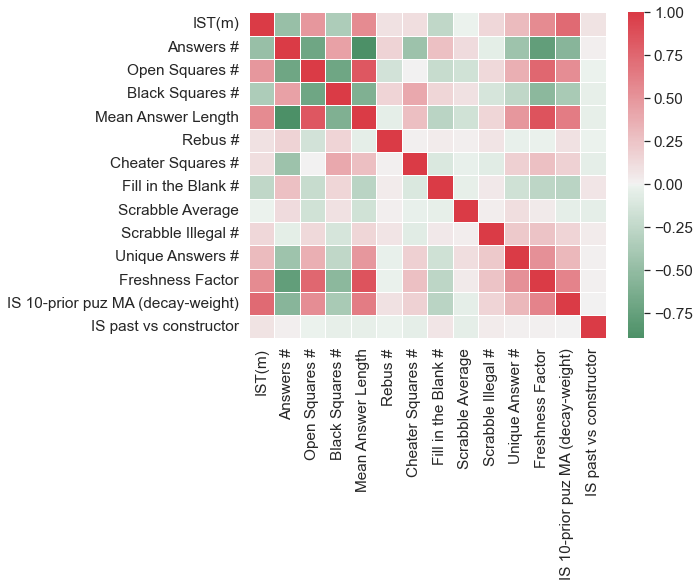

In [62]:
# 15x15 Puzzles Features Correlation to Individual Solver Raw Solve Times Heat Map

IS2_15x15 = IS2_df3.loc[IS2_df3["DOW"]!=("Sunday")]
puzzle_features = IS2_15x15[["IST(m)", "Words", "Open_Squares", "Blocks", "AWL", "Rebus_Count", "Cheater_Squares", "FITB", "Scrabble_Avg", "Scrabble_Illegal", "Unique_Answers", "Freshness_Factor", "IS_pds_l10_dw", 'IS_per_constr_avg_past_diff_from_10pMA']]

corr = puzzle_features.corr()

labels = {
'IST(m)':'IST(m)',  
'Words':'Answers #', 
'Open_Squares':'Open Squares #',
'Blocks': 'Black Squares #',
'AWL':'Mean Answer Length', 
'Rebus_Count':'Rebus #',    
'Cheater_Squares':'Cheater Squares #',
'FITB':'Fill in the Blank #',
'Scrabble_Avg':'Scrabble Average',
'Scrabble_Illegal':'Scrabble Illegal #',
'Unique_Answers':'Unique Answers #',
'Freshness_Factor':'Freshness Factor',
'IS_pds_l10_dw': 'IS 10-prior puz MA (decay-weight)',    
'IS_per_constr_avg_past_diff_from_10pMA':'IS past vs constructor'
}

corr = corr.rename(labels)

# remove the top right triange - duplicate information
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Colors
cmap = sns.diverging_palette(500, 10, as_cmap=True)

# uncomment this if want only the lower triangle matrix 
# ans=sns.heatmap(corr, mask=mask,  linewidths=1, cmap=cmap, center=0)
plt.figure(figsize=(8,6))
ans=sns.heatmap(corr,  linewidths=1, cmap=cmap, center=0, xticklabels=True, yticklabels=True)

_= ans.set_xticklabels(['IST(m)', 'Answers #', 'Open Squares #', 'Black Squares #', 'Mean Answer Length', 'Rebus #', 'Cheater Squares #', 'Fill in the Blank #', 'Scrabble Average', 'Scrabble Illegal #', 'Unique Answer #', 'Freshness Factor', 'IS 10-prior puz MA (decay-weight)', 'IS past vs constructor'])
#_= ans.set_yticklabels(['IST(m)', 'Answers #', 'Open Squares #', 'Black Squares #', 'Average Answer Length', 'Rebus #', 'Cheater Squares #', 'Fill in the Blank #', 'Scrabble Average', 'Scrabble Illegal #', 'Unique Answer #', 'Freshness Factor', 'Recent Adj Perf', 'Past Perf vs Constructor(s)'])

#save image 
# figure = ans.get_figure()    
# figure.savefig('correlations.png', dpi=800)

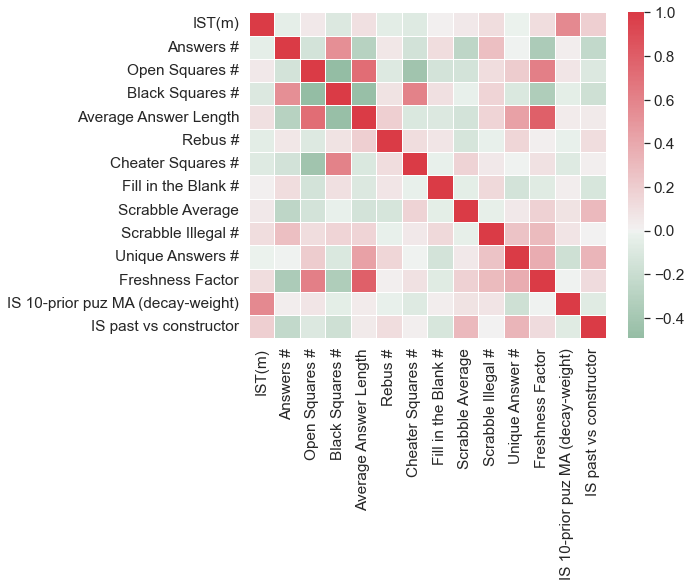

In [63]:
# 21x21 (Sunday) Puzzles Features Correlation to Individual Solver Raw Solve Times Heat Map

IS2_21x21 = IS2_df3.loc[IS2_df3["DOW"]==("Sunday")]
puzzle_features = IS2_21x21[["IST(m)", "Words", "Open_Squares", "Blocks", "AWL", "Rebus_Count", "Cheater_Squares", "FITB", "Scrabble_Avg", "Scrabble_Illegal", "Unique_Answers", "Freshness_Factor", "IS_pds_l10_dw", 'IS_per_constr_avg_past_diff_from_10pMA']]

corr = puzzle_features.corr()

labels = {
'IST(m)':'IST(m)',  
'Words':'Answers #', 
'Open_Squares':'Open Squares #',
'Blocks': 'Black Squares #',
'AWL':'Average Answer Length', 
'Rebus_Count':'Rebus #',    
'Cheater_Squares':'Cheater Squares #',
'FITB':'Fill in the Blank #',
'Scrabble_Avg':'Scrabble Average',
'Scrabble_Illegal':'Scrabble Illegal #',
'Unique_Answers':'Unique Answers #',
'Freshness_Factor':'Freshness Factor',
'IS_pds_l10_dw': 'IS 10-prior puz MA (decay-weight)',    
'IS_per_constr_avg_past_diff_from_10pMA':'IS past vs constructor'
}

corr = corr.rename(labels)

# remove the top right triange - duplicate information
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Colors
cmap = sns.diverging_palette(500, 10, as_cmap=True)

# uncomment this if want only the lower triangle matrix 
# ans=sns.heatmap(corr, mask=mask,  linewidths=1, cmap=cmap, center=0)
plt.figure(figsize=(8,6))
ans=sns.heatmap(corr,  linewidths=1, cmap=cmap, center=0, xticklabels=True, yticklabels=True)

_= ans.set_xticklabels(['IST(m)', 'Answers #', 'Open Squares #', 'Black Squares #', 'Average Answer Length', 'Rebus #', 'Cheater Squares #', 'Fill in the Blank #', 'Scrabble Average', 'Scrabble Illegal #', 'Unique Answer #', 'Freshness Factor', 'IS 10-prior puz MA (decay-weight)', 'IS past vs constructor'])

#save image 
# figure = ans.get_figure()    
# figure.savefig('correlations.png', dpi=800)

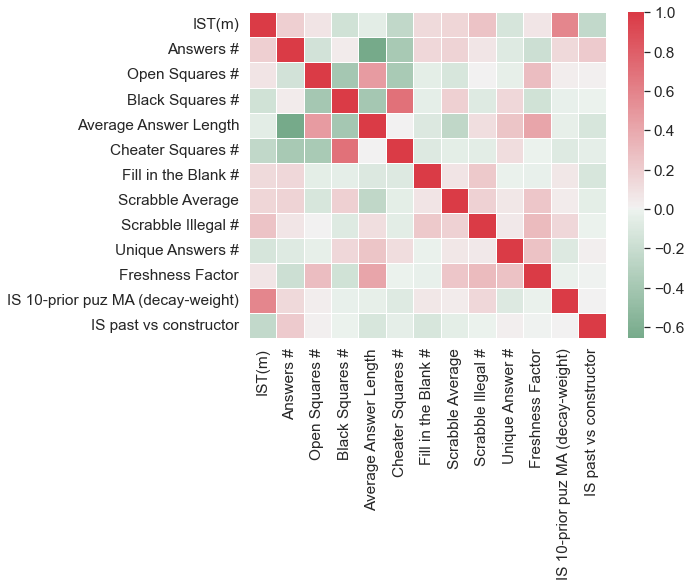

In [64]:
# Monday Puzzles Features Correlation to Individual Solver Raw Solve Times Heat Map

IS2_df3_Mon = IS2_df3.loc[IS2_df3["DOW"]==("Monday")]
puzzle_features = IS2_df3_Mon[["IST(m)", "Words", "Open_Squares", "Blocks", "AWL", "Cheater_Squares", "FITB", "Scrabble_Avg", "Scrabble_Illegal", "Unique_Answers", "Freshness_Factor", "IS_pds_l10_dw", 'IS_per_constr_avg_past_diff_from_10pMA']]

corr = puzzle_features.corr()

labels = {
'IST(m)':'IST(m)',  
'Words':'Answers #', 
'Open_Squares':'Open Squares #',
'Blocks': 'Black Squares #',
'AWL':'Average Answer Length',   
'Cheater_Squares':'Cheater Squares #',
'FITB':'Fill in the Blank #',
'Scrabble_Avg':'Scrabble Average',
'Scrabble_Illegal':'Scrabble Illegal #',
'Unique_Answers':'Unique Answers #',
'Freshness_Factor':'Freshness Factor',
'IS_pds_l10_dw': 'IS 10-prior puz MA (decay-weight)',    
'IS_per_constr_avg_past_diff_from_10pMA':'IS past vs constructor'
}

corr = corr.rename(labels)

# remove the top right triange - duplicate information
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Colors
cmap = sns.diverging_palette(500, 10, as_cmap=True)

# uncomment this if want only the lower triangle matrix 
# ans=sns.heatmap(corr, mask=mask,  linewidths=1, cmap=cmap, center=0)
plt.figure(figsize=(8,6))
ans=sns.heatmap(corr,  linewidths=1, cmap=cmap, center=0, xticklabels=True, yticklabels=True)

_= ans.set_xticklabels(['IST(m)', 'Answers #', 'Open Squares #', 'Black Squares #', 'Average Answer Length', 'Cheater Squares #', 'Fill in the Blank #', 'Scrabble Average', 'Scrabble Illegal #', 'Unique Answer #', 'Freshness Factor', 'IS 10-prior puz MA (decay-weight)', 'IS past vs constructor'])

#save image 
# figure = ans.get_figure()    
# figure.savefig('correlations.png', dpi=800)

In [ ]:
IS1_df3_Mon.info()

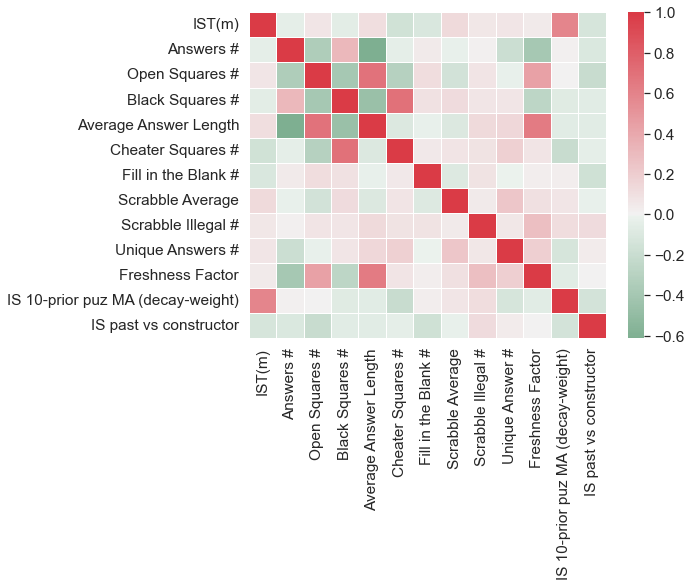

In [65]:
# Tuesday Puzzles Features Correlation to Individual Solver Raw Solve Times Heat Map

IS2_df3_Tue = IS2_df3.loc[IS2_df3["DOW"]==("Tuesday")]
puzzle_features = IS2_df3_Tue[["IST(m)", "Words", "Open_Squares", "Blocks", "AWL", "Cheater_Squares", "FITB", "Scrabble_Avg", "Scrabble_Illegal", "Unique_Answers", "Freshness_Factor", "IS_pds_l10_dw", 'IS_per_constr_avg_past_diff_from_10pMA']]

corr = puzzle_features.corr()

labels = {
'IST(m)':'IST(m)',  
'Words':'Answers #', 
'Open_Squares':'Open Squares #',
'Blocks': 'Black Squares #',
'AWL':'Average Answer Length',   
'Cheater_Squares':'Cheater Squares #',
'FITB':'Fill in the Blank #',
'Scrabble_Avg':'Scrabble Average',
'Scrabble_Illegal':'Scrabble Illegal #',
'Unique_Answers':'Unique Answers #',
'Freshness_Factor':'Freshness Factor',
'IS_pds_l10_dw': 'IS 10-prior puz MA (decay-weight)',    
'IS_per_constr_avg_past_diff_from_10pMA':'IS past vs constructor'
}

corr = corr.rename(labels)

# remove the top right triange - duplicate information
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Colors
cmap = sns.diverging_palette(500, 10, as_cmap=True)

# uncomment this if want only the lower triangle matrix 
# ans=sns.heatmap(corr, mask=mask,  linewidths=1, cmap=cmap, center=0)
plt.figure(figsize=(8,6))
ans=sns.heatmap(corr,  linewidths=1, cmap=cmap, center=0, xticklabels=True, yticklabels=True)

_= ans.set_xticklabels(['IST(m)', 'Answers #', 'Open Squares #', 'Black Squares #', 'Average Answer Length', 'Cheater Squares #', 'Fill in the Blank #', 'Scrabble Average', 'Scrabble Illegal #', 'Unique Answer #', 'Freshness Factor', 'IS 10-prior puz MA (decay-weight)', 'IS past vs constructor'])

#save image 
# figure = ans.get_figure()    
# figure.savefig('correlations.png', dpi=800)


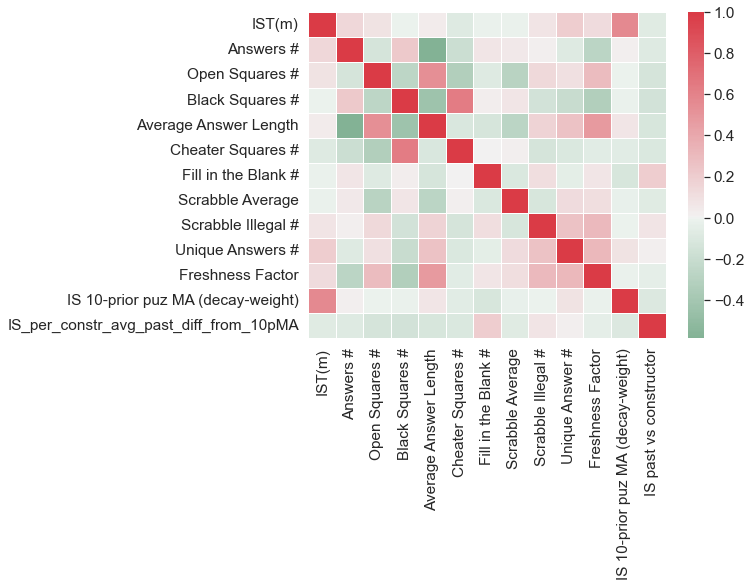

In [67]:
# Wednesday Puzzles Features Correlation to Individual Solver Raw Solve Times Heat Map

IS2_df3_Wed = IS2_df3.loc[IS2_df3["DOW"]==("Wednesday")]
puzzle_features = IS2_df3_Wed[["IST(m)", "Words", "Open_Squares", "Blocks", "AWL", "Cheater_Squares", "FITB", "Scrabble_Avg", "Scrabble_Illegal", "Unique_Answers", "Freshness_Factor", "IS_pds_l10_dw", 'IS_per_constr_avg_past_diff_from_10pMA']]

corr = puzzle_features.corr()

labels = {
'IST(m)':'IST(m)',  
'Words':'Answers #', 
'Open_Squares':'Open Squares #',
'Blocks': 'Black Squares #',
'AWL':'Average Answer Length',   
'Cheater_Squares':'Cheater Squares #',
'FITB':'Fill in the Blank #',
'Scrabble_Avg':'Scrabble Average',
'Scrabble_Illegal':'Scrabble Illegal #',
'Unique_Answers':'Unique Answers #',
'Freshness_Factor':'Freshness Factor',
'IS_pds_l10_dw': 'IS 10-prior puz MA (decay-weight)',    
'per_constr_avg_past_diff_from_10pMA':'IS past vs constructor'
}

corr = corr.rename(labels)

# remove the top right triange - duplicate information
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Colors
cmap = sns.diverging_palette(500, 10, as_cmap=True)

# uncomment this if want only the lower triangle matrix 
# ans=sns.heatmap(corr, mask=mask,  linewidths=1, cmap=cmap, center=0)
plt.figure(figsize=(8,6))
ans=sns.heatmap(corr,  linewidths=1, cmap=cmap, center=0, xticklabels=True, yticklabels=True)

_= ans.set_xticklabels(['IST(m)', 'Answers #', 'Open Squares #', 'Black Squares #', 'Average Answer Length', 'Cheater Squares #', 'Fill in the Blank #', 'Scrabble Average', 'Scrabble Illegal #', 'Unique Answer #', 'Freshness Factor', 'IS 10-prior puz MA (decay-weight)', 'IS past vs constructor'])

#save image 
# figure = ans.get_figure()    
# figure.savefig('correlations.png', dpi=800)

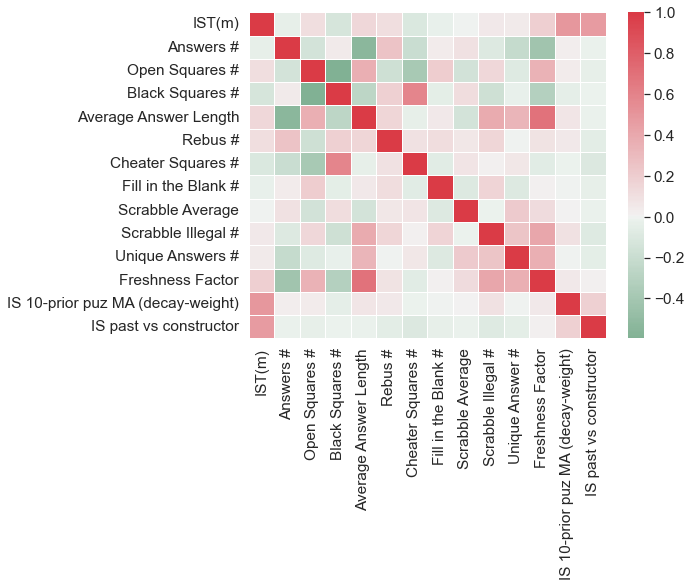

In [68]:
# Thursday Puzzles Features Correlation to Individual Solver Raw Solve Times Heat Map

IS2_df3_Thurs = IS2_df3.loc[IS2_df3["DOW"]==("Thursday")]
puzzle_features = IS2_df3_Thurs[["IST(m)", "Words", "Open_Squares", "Blocks", "AWL", "Rebus_Count", "Cheater_Squares", "FITB", "Scrabble_Avg", "Scrabble_Illegal", "Unique_Answers", "Freshness_Factor", "IS_pds_l10_dw", 'IS_per_constr_avg_past_diff_from_10pMA']]

corr = puzzle_features.corr()

labels = {
'IST(m)':'IST(m)',  
'Words':'Answers #', 
'Open_Squares':'Open Squares #',
'Blocks': 'Black Squares #',
'AWL':'Average Answer Length', 
'Rebus_Count':'Rebus #',    
'Cheater_Squares':'Cheater Squares #',
'FITB':'Fill in the Blank #',
'Scrabble_Avg':'Scrabble Average',
'Scrabble_Illegal':'Scrabble Illegal #',
'Unique_Answers':'Unique Answers #',
'Freshness_Factor':'Freshness Factor',
'IS_pds_l10_dw': 'IS 10-prior puz MA (decay-weight)',    
'IS_per_constr_avg_past_diff_from_10pMA':'IS past vs constructor'
}

corr = corr.rename(labels)

# remove the top right triange - duplicate information
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Colors
cmap = sns.diverging_palette(500, 10, as_cmap=True)

# uncomment this if want only the lower triangle matrix 
# ans=sns.heatmap(corr, mask=mask,  linewidths=1, cmap=cmap, center=0)
plt.figure(figsize=(8,6))
ans=sns.heatmap(corr,  linewidths=1, cmap=cmap, center=0, xticklabels=True, yticklabels=True)

_= ans.set_xticklabels(['IST(m)', 'Answers #', 'Open Squares #', 'Black Squares #', 'Average Answer Length', 'Rebus #', 'Cheater Squares #', 'Fill in the Blank #', 'Scrabble Average', 'Scrabble Illegal #', 'Unique Answer #', 'Freshness Factor', 'IS 10-prior puz MA (decay-weight)', 'IS past vs constructor'])
#save image 
# figure = ans.get_figure()    
# figure.savefig('correlations.png', dpi=800)

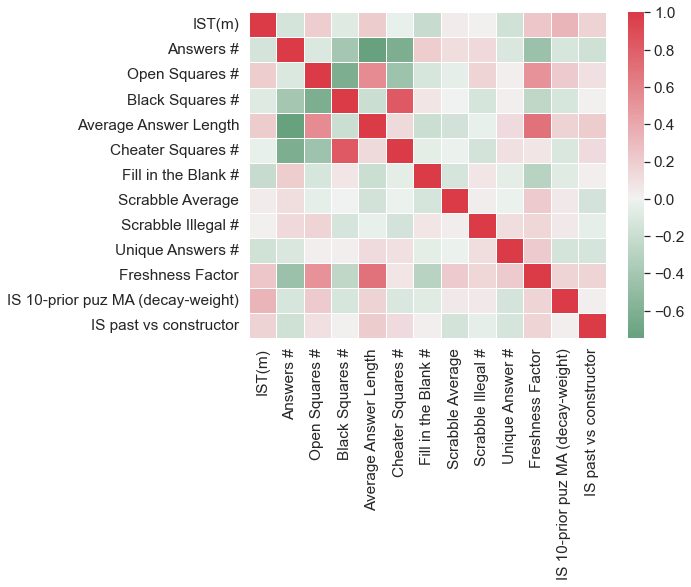

In [69]:
# Friday Puzzles Features Correlation to Individual Solver Raw Solve Times Heat Map

IS2_df3_Fri = IS2_df3.loc[IS2_df3["DOW"]==("Friday")]
puzzle_features = IS2_df3_Fri[["IST(m)", "Words", "Open_Squares", "Blocks", "AWL", "Cheater_Squares", "FITB", "Scrabble_Avg", "Scrabble_Illegal", "Unique_Answers", "Freshness_Factor", "IS_pds_l10_dw", 'IS_per_constr_avg_past_diff_from_10pMA']]

corr = puzzle_features.corr()

labels = {
'IST(m)':'IST(m)',  
'Words':'Answers #', 
'Open_Squares':'Open Squares #',
'Blocks': 'Black Squares #',
'AWL':'Average Answer Length',   
'Cheater_Squares':'Cheater Squares #',
'FITB':'Fill in the Blank #',
'Scrabble_Avg':'Scrabble Average',
'Scrabble_Illegal':'Scrabble Illegal #',
'Unique_Answers':'Unique Answers #',
'Freshness_Factor':'Freshness Factor',
'IS_pds_l10_dw': 'IS 10-prior puz MA (decay-weight)',    
'IS_per_constr_avg_past_diff_from_10pMA':'IS past vs constructor'
}

corr = corr.rename(labels)

# remove the top right triange - duplicate information
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Colors
cmap = sns.diverging_palette(500, 10, as_cmap=True)

# uncomment this if want only the lower triangle matrix 
# ans=sns.heatmap(corr, mask=mask,  linewidths=1, cmap=cmap, center=0)
plt.figure(figsize=(8,6))
ans=sns.heatmap(corr,  linewidths=1, cmap=cmap, center=0, xticklabels=True, yticklabels=True)

_= ans.set_xticklabels(['IST(m)', 'Answers #', 'Open Squares #', 'Black Squares #', 'Average Answer Length', 'Cheater Squares #', 'Fill in the Blank #', 'Scrabble Average', 'Scrabble Illegal #', 'Unique Answer #', 'Freshness Factor', 'IS 10-prior puz MA (decay-weight)', 'IS past vs constructor'])

#save image 
# figure = ans.get_figure()    
# figure.savefig('correlations.png', dpi=800)

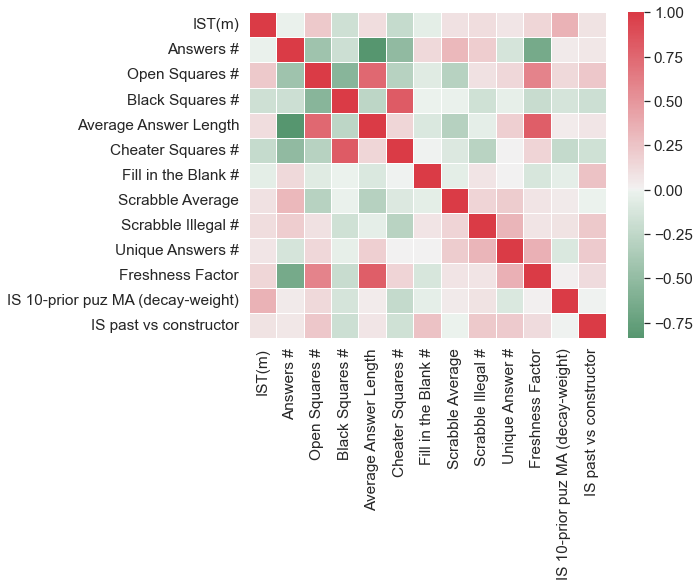

In [70]:
# Saturday Puzzles Features Correlation to Individual Solver Raw Solve Times Heat Map

IS2_df3_Sat = IS2_df3.loc[IS2_df3["DOW"]==("Saturday")]
puzzle_features = IS2_df3_Sat[["IST(m)", "Words", "Open_Squares", "Blocks", "AWL", "Cheater_Squares", "FITB", "Scrabble_Avg", "Scrabble_Illegal", "Unique_Answers", "Freshness_Factor", "IS_pds_l10_dw", 'IS_per_constr_avg_past_diff_from_10pMA']]

corr = puzzle_features.corr()

labels = {
'IST(m)':'IST(m)',  
'Words':'Answers #', 
'Open_Squares':'Open Squares #',
'Blocks': 'Black Squares #',
'AWL':'Average Answer Length',   
'Cheater_Squares':'Cheater Squares #',
'FITB':'Fill in the Blank #',
'Scrabble_Avg':'Scrabble Average',
'Scrabble_Illegal':'Scrabble Illegal #',
'Unique_Answers':'Unique Answers #',
'Freshness_Factor':'Freshness Factor',
'IS_pds_l10_dw': 'IS 10-prior puz MA (decay-weight)',    
'IS_per_constr_avg_past_diff_from_10pMA':'IS past vs constructor'
}

corr = corr.rename(labels)

# remove the top right triange - duplicate information
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Colors
cmap = sns.diverging_palette(500, 10, as_cmap=True)

# uncomment this if want only the lower triangle matrix 
# ans=sns.heatmap(corr, mask=mask,  linewidths=1, cmap=cmap, center=0)
plt.figure(figsize=(8,6))
ans=sns.heatmap(corr,  linewidths=1, cmap=cmap, center=0, xticklabels=True, yticklabels=True)

_= ans.set_xticklabels(['IST(m)', 'Answers #', 'Open Squares #', 'Black Squares #', 'Average Answer Length', 'Cheater Squares #', 'Fill in the Blank #', 'Scrabble Average', 'Scrabble Illegal #', 'Unique Answer #', 'Freshness Factor', 'IS 10-prior puz MA (decay-weight)', 'IS past vs constructor'])

#save image 
# figure = ans.get_figure()    
# figure.savefig('correlations.png', dpi=800)

### Scatterplots of Relationship of Grid and Answer Parameters to IS1 Performance

In [ ]:
IS2_df3.info()

In [71]:
# Create new df with all rows copied and placed below current rows. 
# This is so we can plot all 15x15 data together as a subplot in the figures below

IS2_df3_copy = IS2_df3.loc[(IS2_df3["DOW_num"] != 1)] #15x15 only
IS2_df3_copy["DOW_num"] = 0

IS2_df4 = pd.concat([IS2_df3, IS2_df3_copy],ignore_index=True)

In [ ]:
IS2_df4.info()

In [ ]:
IS2_df4["DOW_num"].unique()

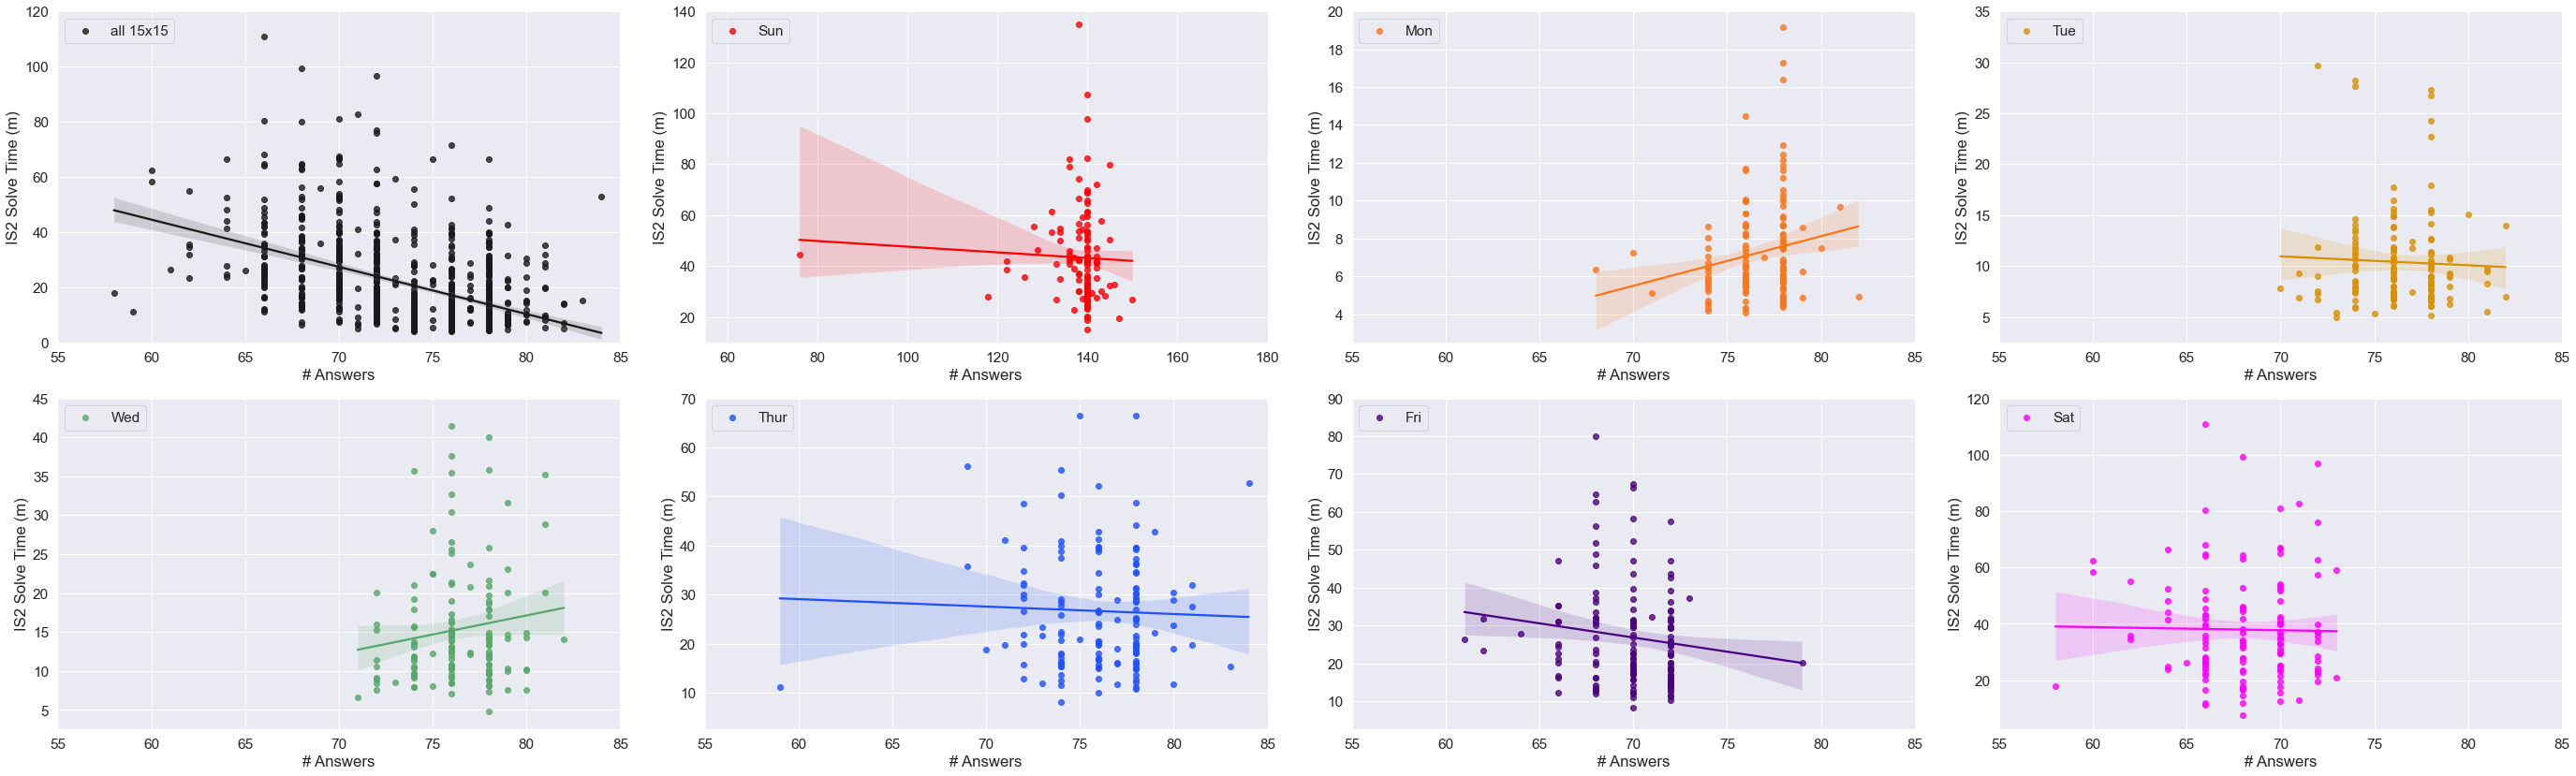

In [72]:
# Number of Answers vs IS2 Raw Solve Times

IS2_df4 = IS2_df4.sort_values(by=['DOW_num'], ascending = True)

IS2_df4['plot_seq_map'] = IS2_df4['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=IS2_df4, x="Words", y="IST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "# Answers",
    ylabel="IS2 Solve Time (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((55,85))
p.axes[1].set_xlim((55,180))
p.axes[2].set_xlim((55,85))
p.axes[3].set_xlim((55,85))
p.axes[4].set_xlim((55,85))
p.axes[5].set_xlim((55,85))
p.axes[6].set_xlim((55,85))
p.axes[7].set_xlim((55,85))

p.axes[0].set_ylim((0,120))
p.axes[1].set_ylim((10,140))
p.axes[2].set_ylim((2.5,20))
p.axes[3].set_ylim((2.5,35))
p.axes[4].set_ylim((2.5,45))
p.axes[5].set_ylim((2.5,70))
p.axes[6].set_ylim((2.5,90))
p.axes[7].set_ylim((2.5,120))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

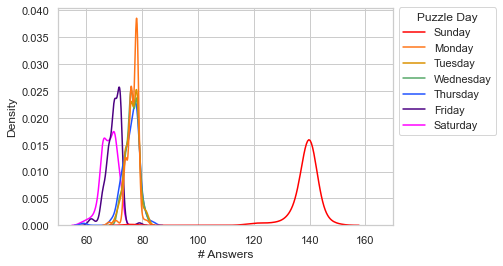

In [73]:
# Density plot of number of answers in puzzles solved by IS2
# Rememember to use df3 because df4 has the copied-in data for plotting all completed puzzles together

IS2_df3 = IS2_df3.sort_values(by=['DOW_num'], ascending = True)

sns.set(style="whitegrid")
ax = sns.kdeplot(data=IS2_df3, x = "Words", hue= "DOW", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], legend=True)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.027), title='Puzzle Day')

plt.xlim(50, 170)
ax.set_xlabel("# Answers")
plt.show()

In [ ]:
IS2_df3["Words"].agg(['min', 'max'])

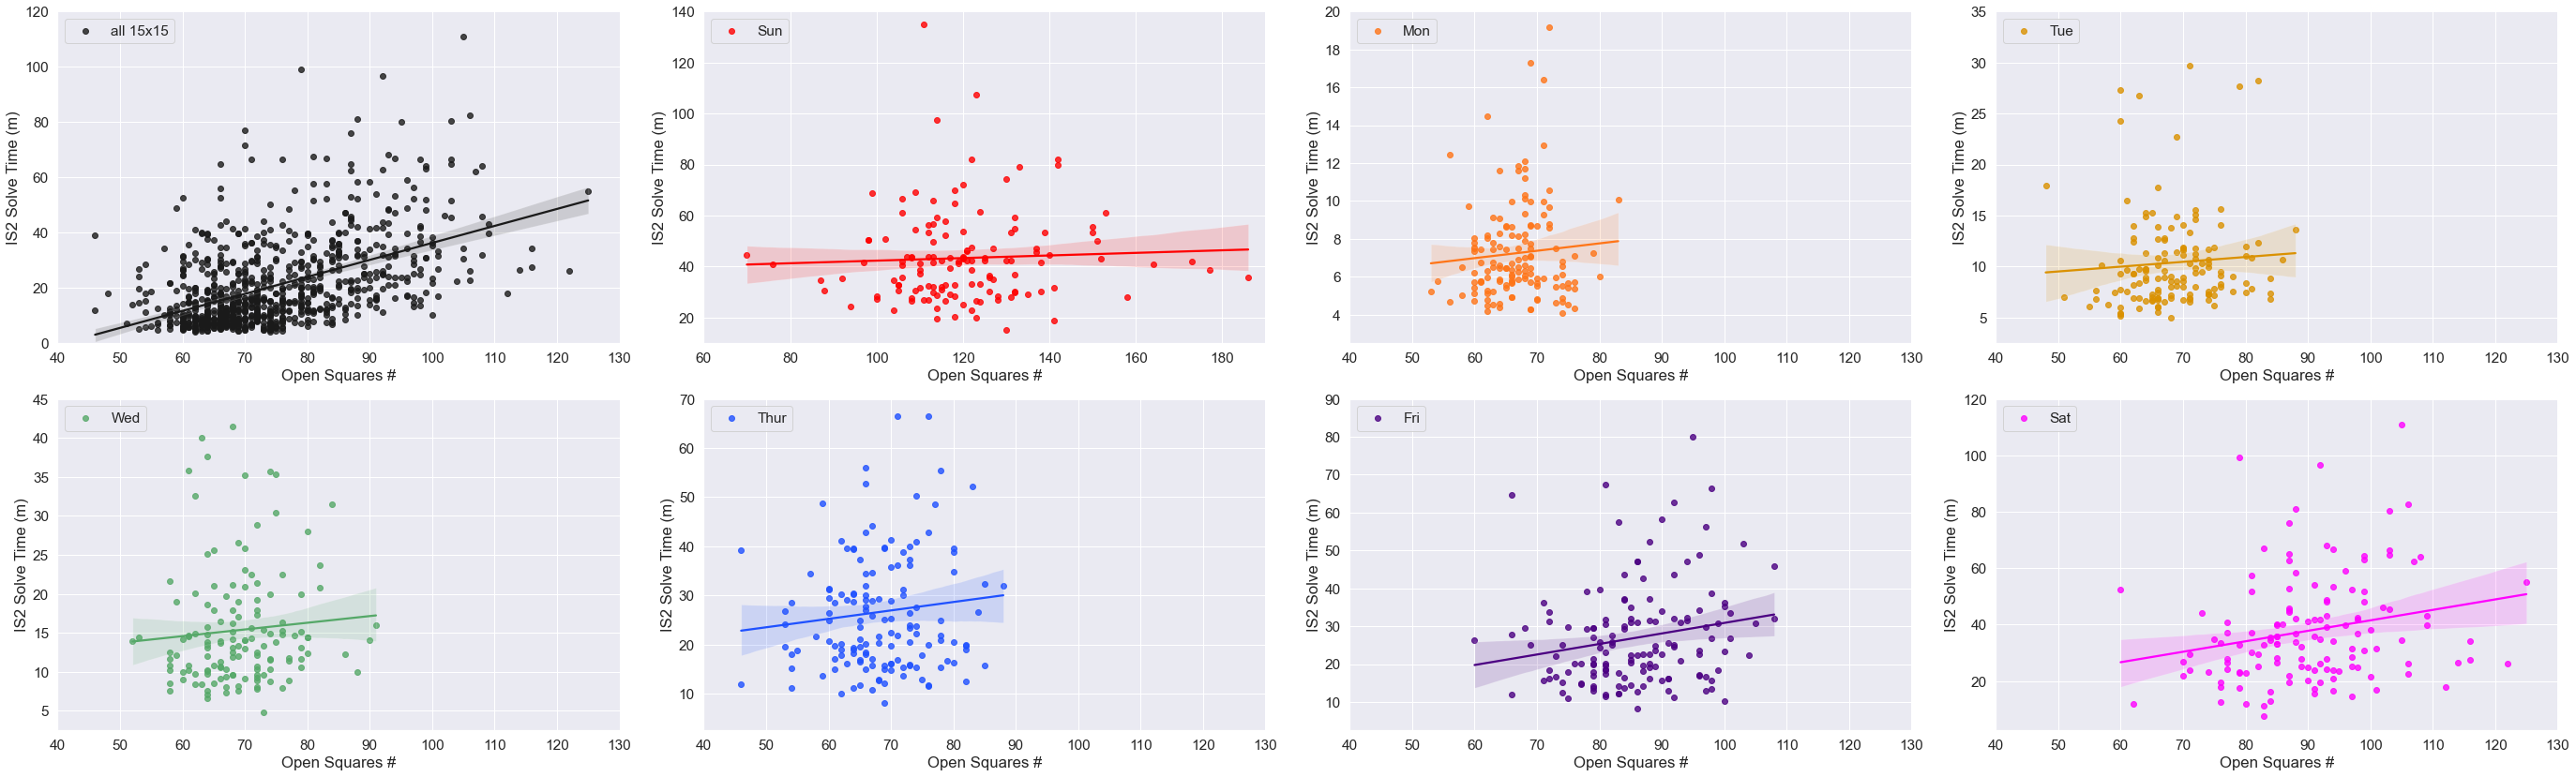

In [74]:
# Open Squares vs IS2 Raw Solve Times

IS2_df4 = IS2_df4.sort_values(by=['DOW_num'], ascending = True)

IS2_df4['plot_seq_map'] = IS2_df4['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=IS2_df4, x="Open_Squares", y="IST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "Open Squares #",
    ylabel="IS2 Solve Time (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((40,130))
p.axes[1].set_xlim((60,190))
p.axes[2].set_xlim((40,130))
p.axes[3].set_xlim((40,130))
p.axes[4].set_xlim((40,130))
p.axes[5].set_xlim((40,130))
p.axes[6].set_xlim((40,130))
p.axes[7].set_xlim((40,130))

p.axes[0].set_ylim((0,120))
p.axes[1].set_ylim((10,140))
p.axes[2].set_ylim((2.5,20))
p.axes[3].set_ylim((2.5,35))
p.axes[4].set_ylim((2.5,45))
p.axes[5].set_ylim((2.5,70))
p.axes[6].set_ylim((2.5,90))
p.axes[7].set_ylim((2.5,120))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

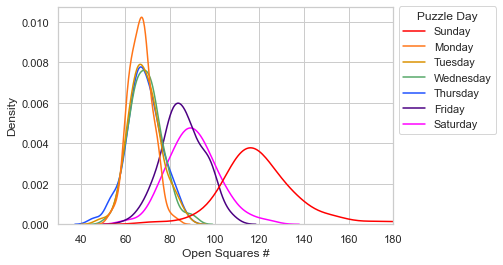

In [75]:
# Density plot of number of open squares in puzzles solved by IS1
# Rememember to use df3 because df4 has the copied-in data for plotting all completed puzzles together

IS2_df3 = IS2_df3.sort_values(by=['DOW_num'], ascending = True)

sns.set(style="whitegrid")
ax = sns.kdeplot(data=IS2_df3, x = "Open_Squares", hue= "DOW", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], legend=True)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.027), title='Puzzle Day')

plt.xlim(30, 180)
ax.set_xlabel("Open Squares #")
plt.show()

In [76]:
IS2_df3["Open_Squares"].agg(['min', 'max'])

min     46
max    186
Name: Open_Squares, dtype: int64

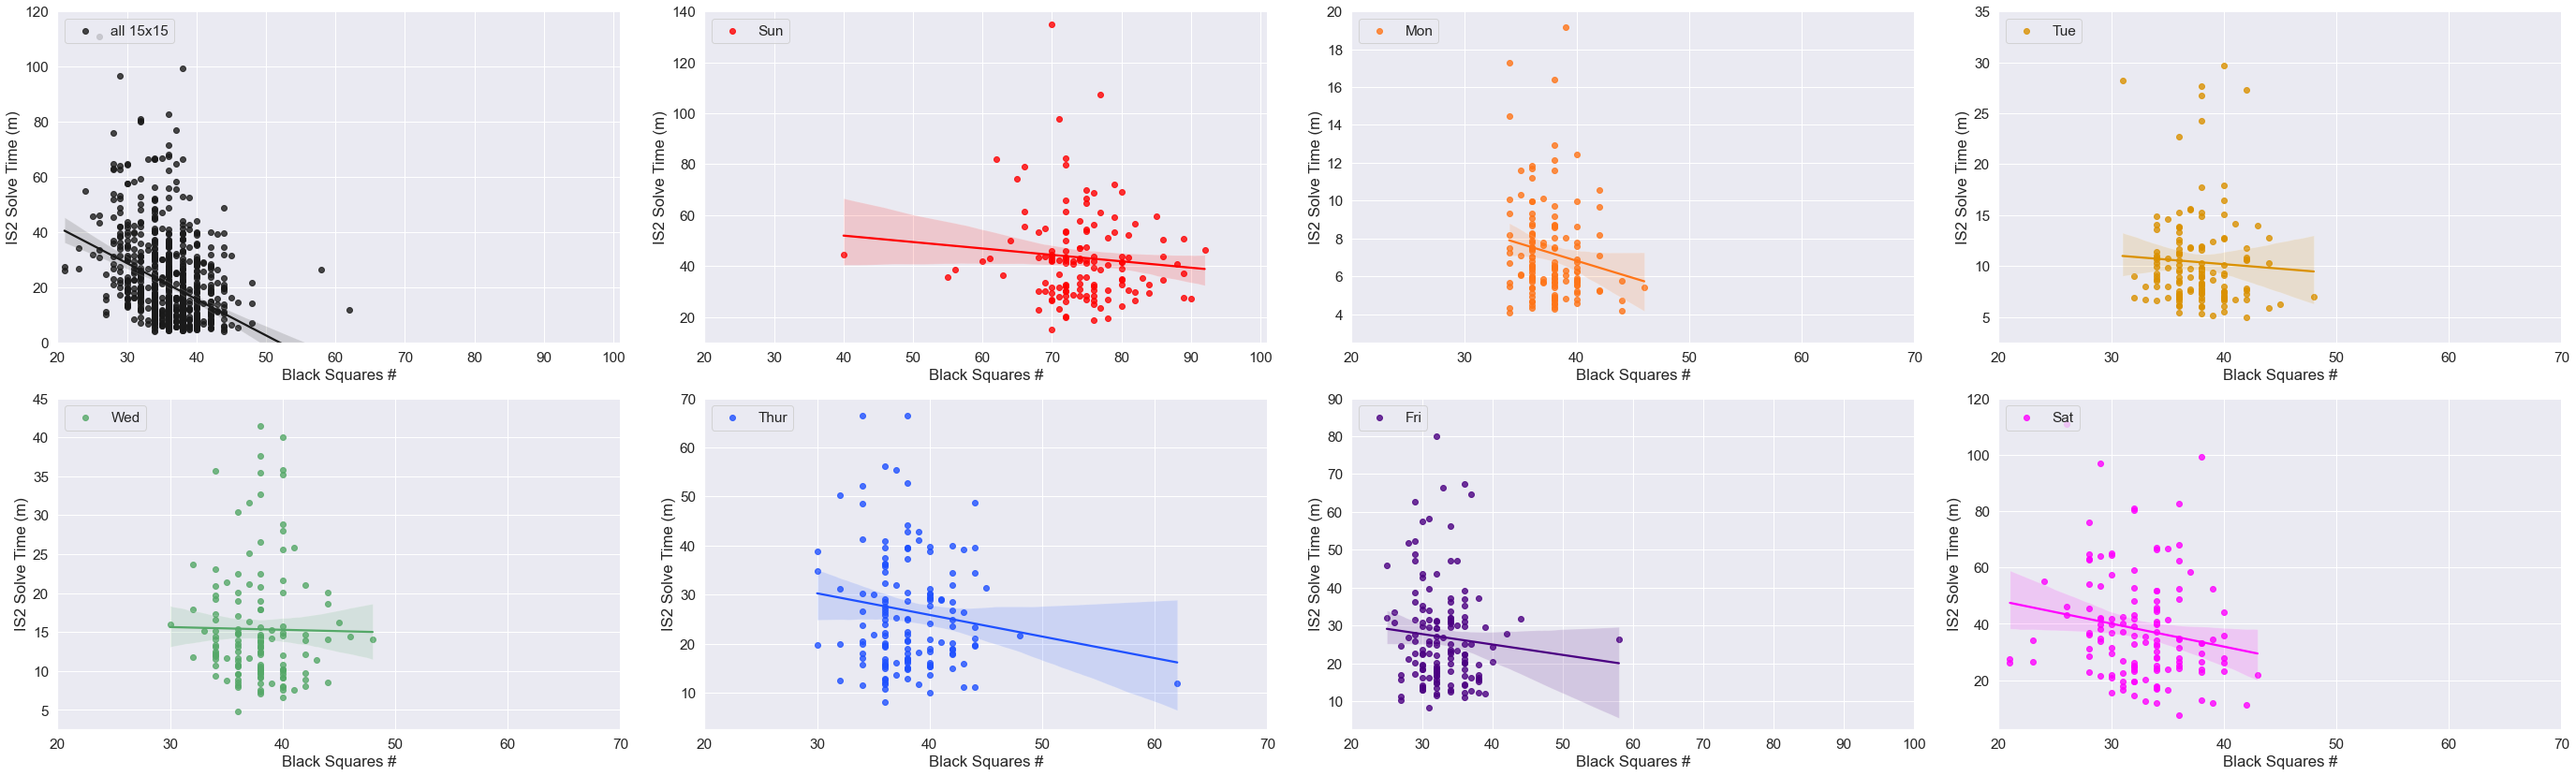

In [77]:
# Black Squares (blocks) vs IS2 Raw Solve Times

IS2_df4 = IS2_df4.sort_values(by=['DOW_num'], ascending = True)

IS2_df4['plot_seq_map'] = IS2_df4['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=IS2_df4, x="Blocks", y="IST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "Black Squares #",
    ylabel="IS2 Solve Time (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((20,101))
p.axes[1].set_xlim((20,101))
p.axes[2].set_xlim((20,70))
p.axes[3].set_xlim((20,70))
p.axes[4].set_xlim((20,70))
p.axes[5].set_xlim((20,70))
p.axes[6].set_xlim((20,100))
p.axes[7].set_xlim((20,70))

p.axes[0].set_ylim((0,120))
p.axes[1].set_ylim((10,140))
p.axes[2].set_ylim((2.5,20))
p.axes[3].set_ylim((2.5,35))
p.axes[4].set_ylim((2.5,45))
p.axes[5].set_ylim((2.5,70))
p.axes[6].set_ylim((2.5,90))
p.axes[7].set_ylim((2.5,120))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

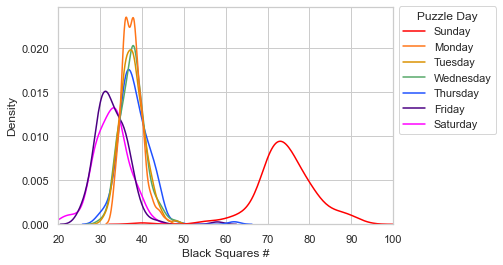

In [78]:
# Density plot of number of black squares (blocks) in puzzles solved by IS2
# Rememember to use df3 because df4 has the copied-in data for plotting all completed puzzles together

IS2_df3 = IS2_df3.sort_values(by=['DOW_num'], ascending = True)

sns.set(style="whitegrid")
ax = sns.kdeplot(data=IS2_df3, x = "Blocks", hue= "DOW", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], legend=True)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.027), title='Puzzle Day')

plt.xlim(20, 100)
ax.set_xlabel("Black Squares #")
plt.show()

In [79]:
IS2_df3["Blocks"].agg(['min', 'max'])

min    21
max    92
Name: Blocks, dtype: int64

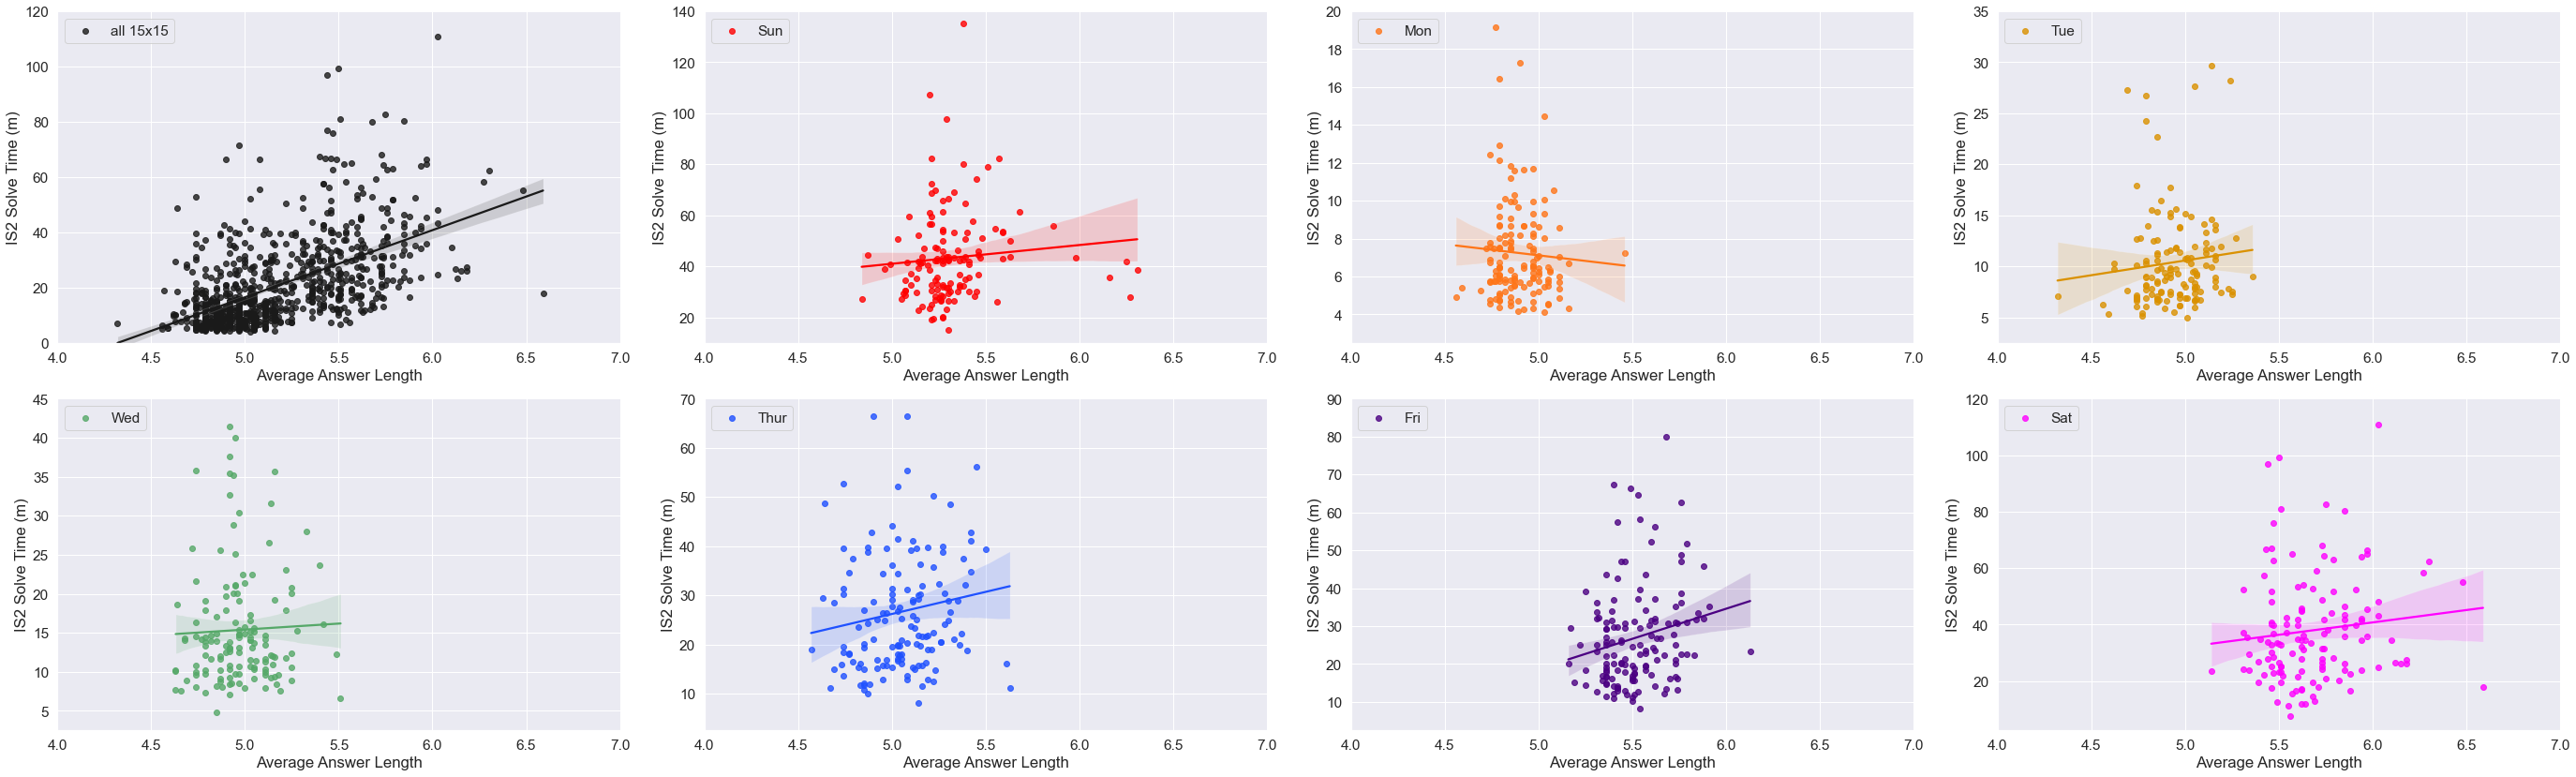

In [80]:
# Average Answer Length vs IS2 Raw Solve Times

IS2_df4 = IS2_df4.sort_values(by=['DOW_num'], ascending = True)

IS2_df4['plot_seq_map'] = IS2_df4['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=IS2_df4, x="AWL", y="IST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "Average Answer Length",
    ylabel="IS2 Solve Time (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((4,7))
p.axes[1].set_xlim((4,7))
p.axes[2].set_xlim((4,7))
p.axes[3].set_xlim((4,7))
p.axes[4].set_xlim((4,7))
p.axes[5].set_xlim((4,7))
p.axes[6].set_xlim((4,7))
p.axes[7].set_xlim((4,7))

p.axes[0].set_ylim((0,120))
p.axes[1].set_ylim((10,140))
p.axes[2].set_ylim((2.5,20))
p.axes[3].set_ylim((2.5,35))
p.axes[4].set_ylim((2.5,45))
p.axes[5].set_ylim((2.5,70))
p.axes[6].set_ylim((2.5,90))
p.axes[7].set_ylim((2.5,120))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

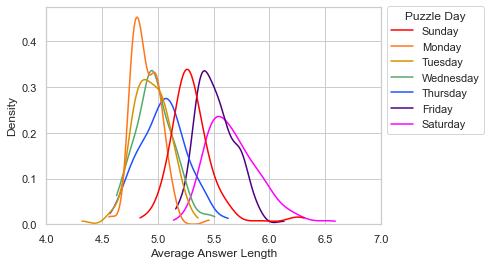

In [81]:
# Density plot of average answer length in puzzles solved by IS2
# Rememember to use df3 because df4 has the copied-in data for plotting all completed puzzles together

IS2_df3 = IS2_df3.sort_values(by=['DOW_num'], ascending = True)

sns.set(style="whitegrid")
ax = sns.kdeplot(data=IS2_df3, x = "AWL", hue= "DOW", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], legend=True, cut=0, clip=(3,7))

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.027), title='Puzzle Day')

plt.xlim(4, 7)
ax.set_xlabel("Average Answer Length")
plt.show()

In [82]:
IS2_df3["AWL"].agg(['min', 'max'])

min    4.32
max    6.59
Name: AWL, dtype: float64

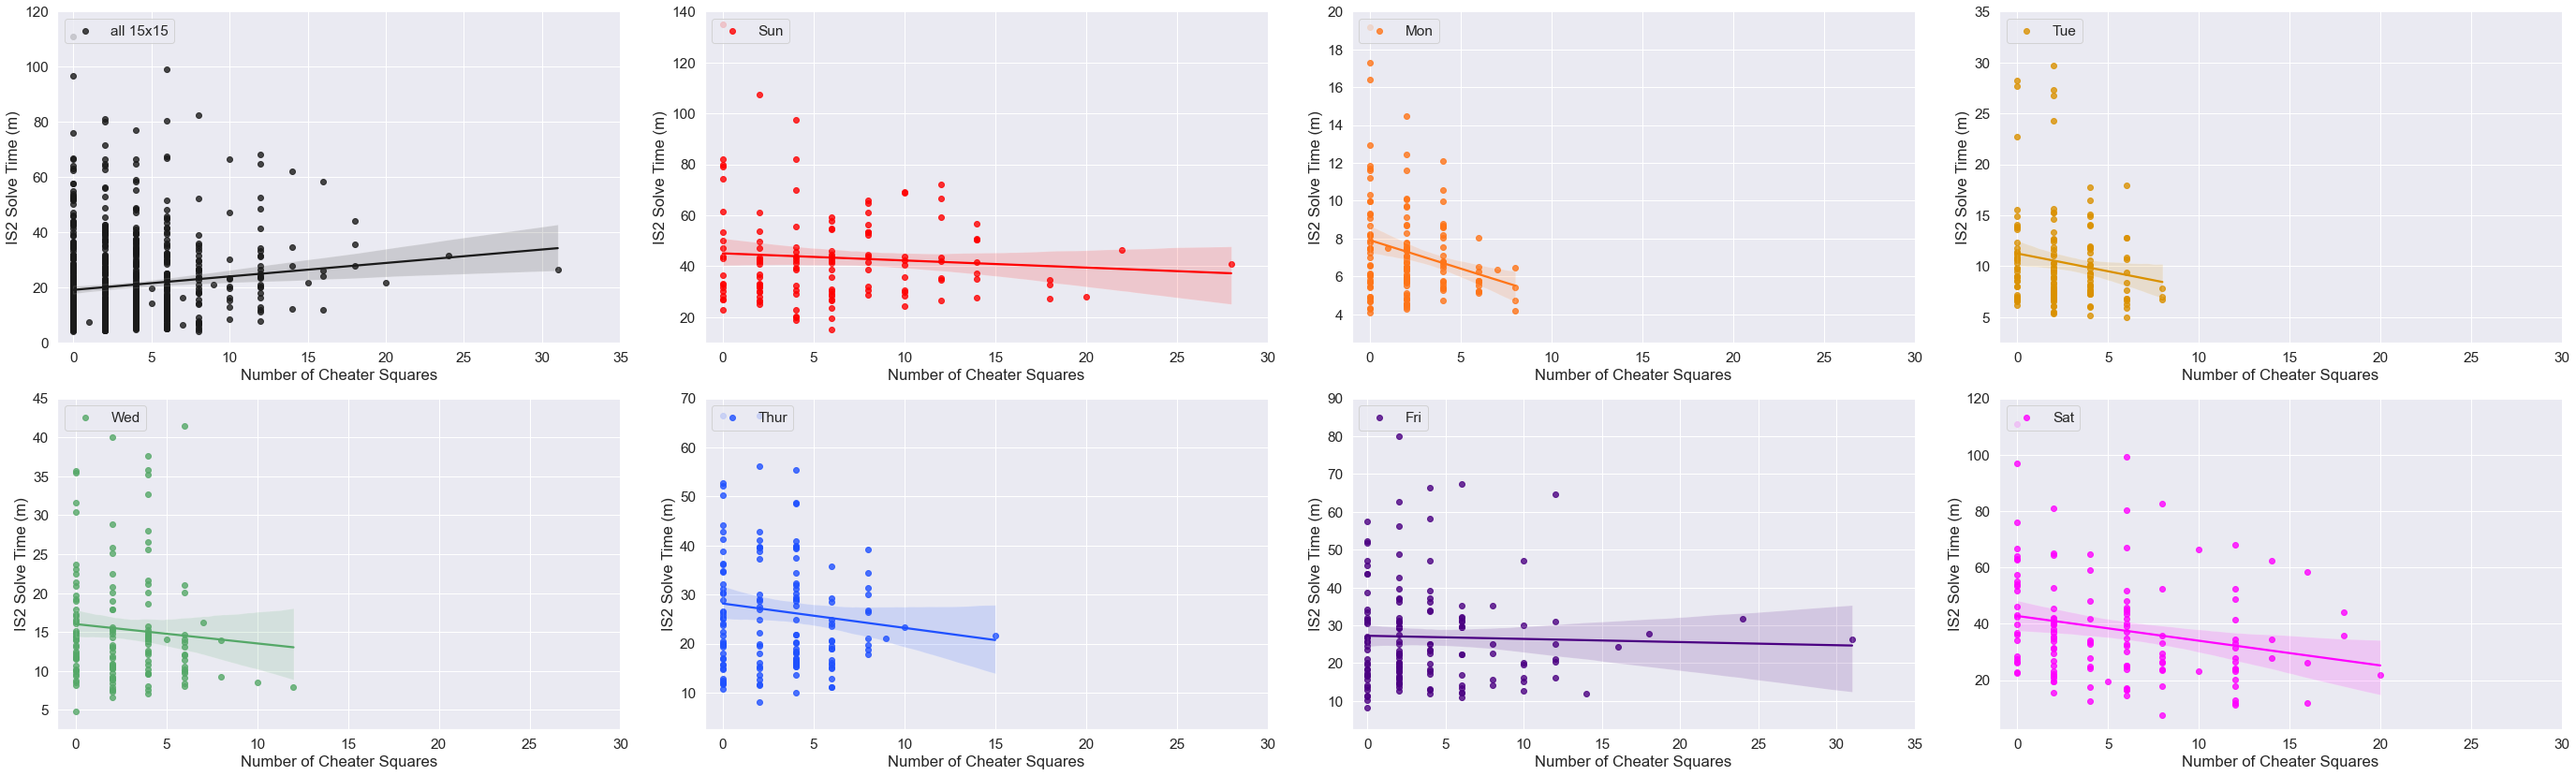

In [83]:
# Cheater Squares vs IS2 Raw Solve Times

IS2_df4 = IS2_df4.sort_values(by=['DOW_num'], ascending = True)

IS2_df4['plot_seq_map'] = IS2_df4['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=IS2_df4, x="Cheater_Squares", y="IST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "Number of Cheater Squares",
    ylabel="IS2 Solve Time (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((-1,35))
p.axes[1].set_xlim((-1,30))
p.axes[2].set_xlim((-1,30))
p.axes[3].set_xlim((-1,30))
p.axes[4].set_xlim((-1,30))
p.axes[5].set_xlim((-1,30))
p.axes[6].set_xlim((-1,35))
p.axes[7].set_xlim((-1,30))

p.axes[0].set_ylim((0,120))
p.axes[1].set_ylim((10,140))
p.axes[2].set_ylim((2.5,20))
p.axes[3].set_ylim((2.5,35))
p.axes[4].set_ylim((2.5,45))
p.axes[5].set_ylim((2.5,70))
p.axes[6].set_ylim((2.5,90))
p.axes[7].set_ylim((2.5,120))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

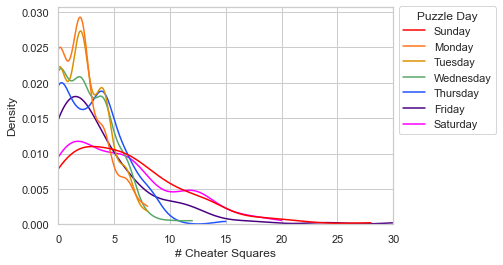

In [84]:
# Density plot of number of cheater squares in puzzles solved by IS2
# Rememember to use df3 because df4 has the copied-in data for plotting all completed puzzles together

IS2_df3 = IS2_df3.sort_values(by=['DOW_num'], ascending = True)

sns.set(style="whitegrid")
ax = sns.kdeplot(data=IS2_df3, x = "Cheater_Squares", hue= "DOW", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], legend=True, cut=0, clip=(0,30))

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.027), title='Puzzle Day')

plt.xlim(0, 30)
ax.set_xlabel("# Cheater Squares")
plt.show()

In [85]:
IS2_df3["Cheater_Squares"].agg(['min', 'max'])

min     0
max    31
Name: Cheater_Squares, dtype: int64

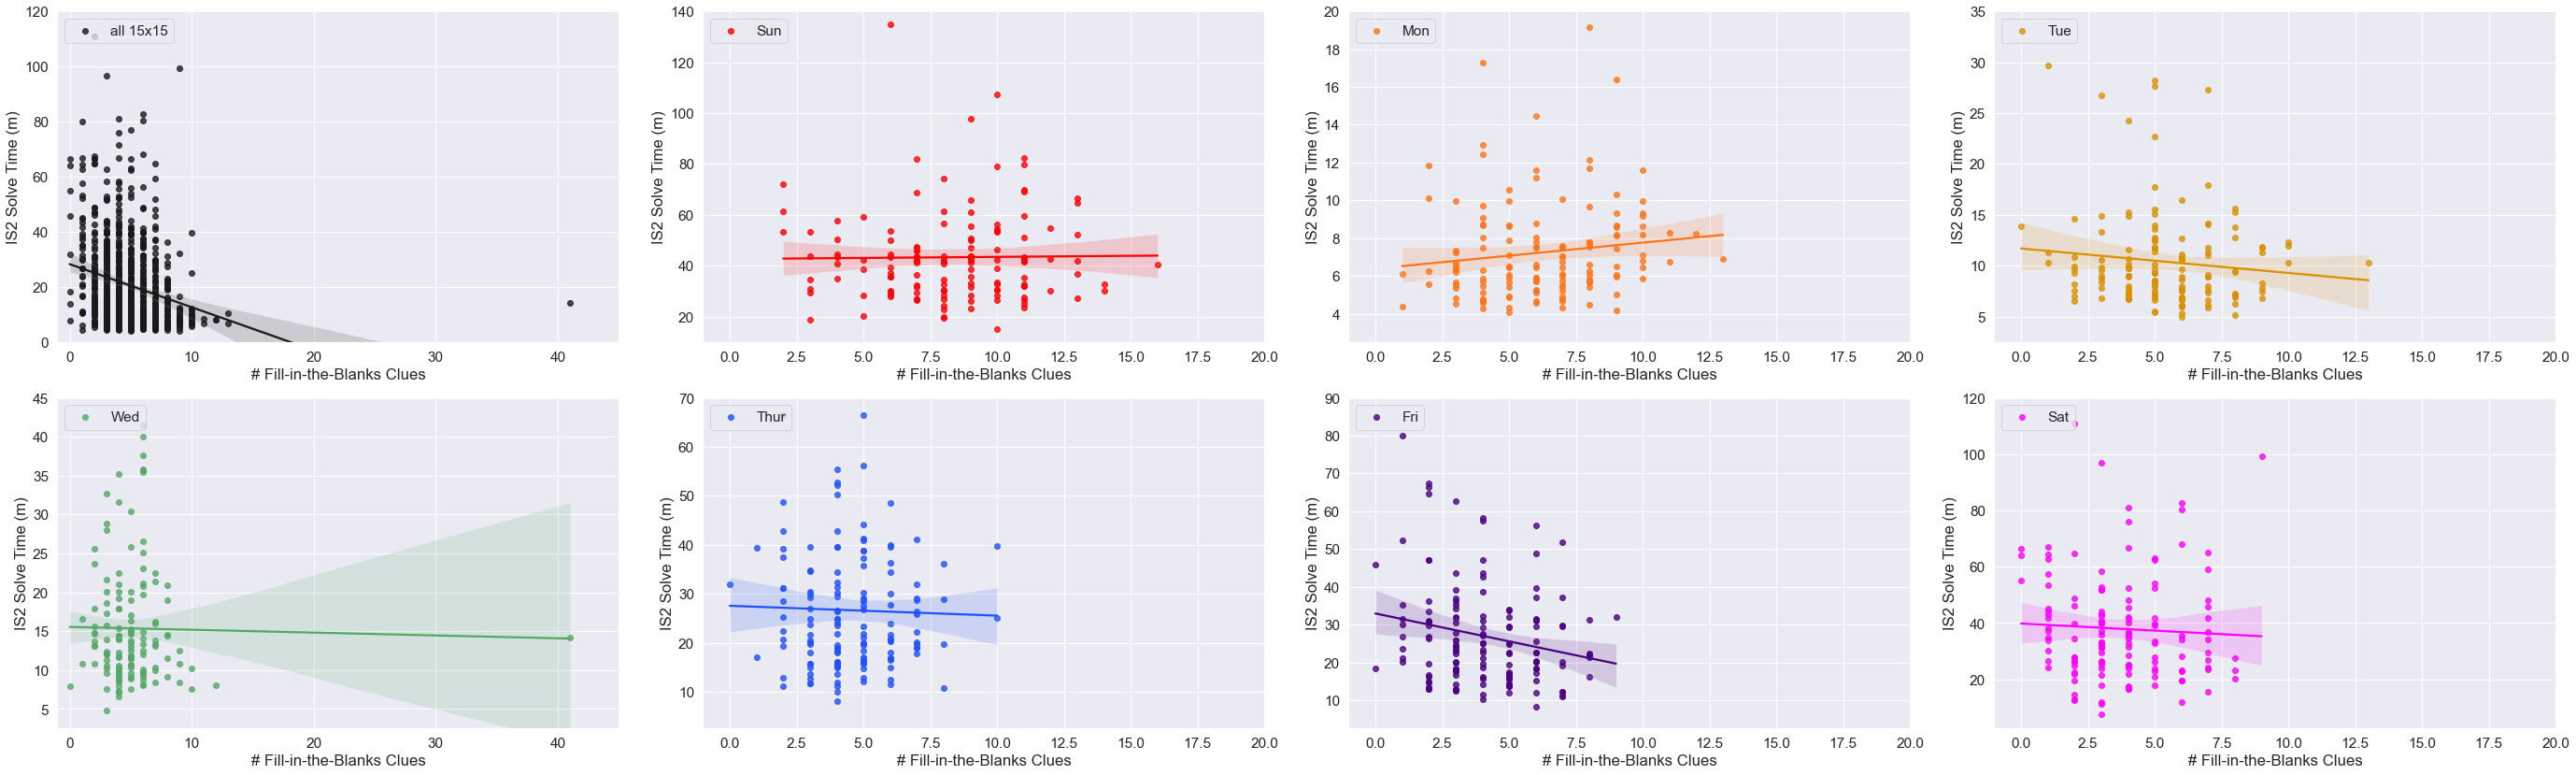

In [86]:
# Fill-in-the-blank clues vs IS2 Raw Solve Times

IS2_df4 = IS2_df4.sort_values(by=['DOW_num'], ascending = True)

IS2_df4['plot_seq_map'] = IS2_df4['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=IS2_df4, x="FITB", y="IST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "# Fill-in-the-Blanks Clues",
    ylabel="IS2 Solve Time (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((-1,45))
p.axes[1].set_xlim((-1,20))
p.axes[2].set_xlim((-1,20))
p.axes[3].set_xlim((-1,20))
p.axes[4].set_xlim((-1,45))
p.axes[5].set_xlim((-1,20))
p.axes[6].set_xlim((-1,20))
p.axes[7].set_xlim((-1,20))

p.axes[0].set_ylim((0,120))
p.axes[1].set_ylim((10,140))
p.axes[2].set_ylim((2.5,20))
p.axes[3].set_ylim((2.5,35))
p.axes[4].set_ylim((2.5,45))
p.axes[5].set_ylim((2.5,70))
p.axes[6].set_ylim((2.5,90))
p.axes[7].set_ylim((2.5,120))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

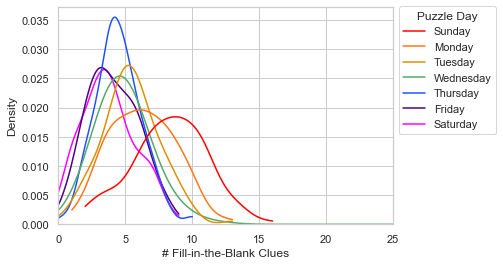

In [87]:
# Density plot of number of fill-in-the-blank clues in puzzles solved by IS1
# Rememember to use df3 because df4 has the copied-in data for plotting all completed puzzles together

IS2_df3 = IS2_df3.sort_values(by=['DOW_num'], ascending = True)

sns.set(style="whitegrid")
ax = sns.kdeplot(data=IS2_df3, x = "FITB", hue= "DOW", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], legend=True, cut=0, clip=(0,45))

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.027), title='Puzzle Day')

plt.xlim(0, 25)
ax.set_xlabel("# Fill-in-the-Blank Clues")
plt.show()

In [88]:
IS2_df3["FITB"].agg(['min', 'max'])

min     0
max    41
Name: FITB, dtype: int64

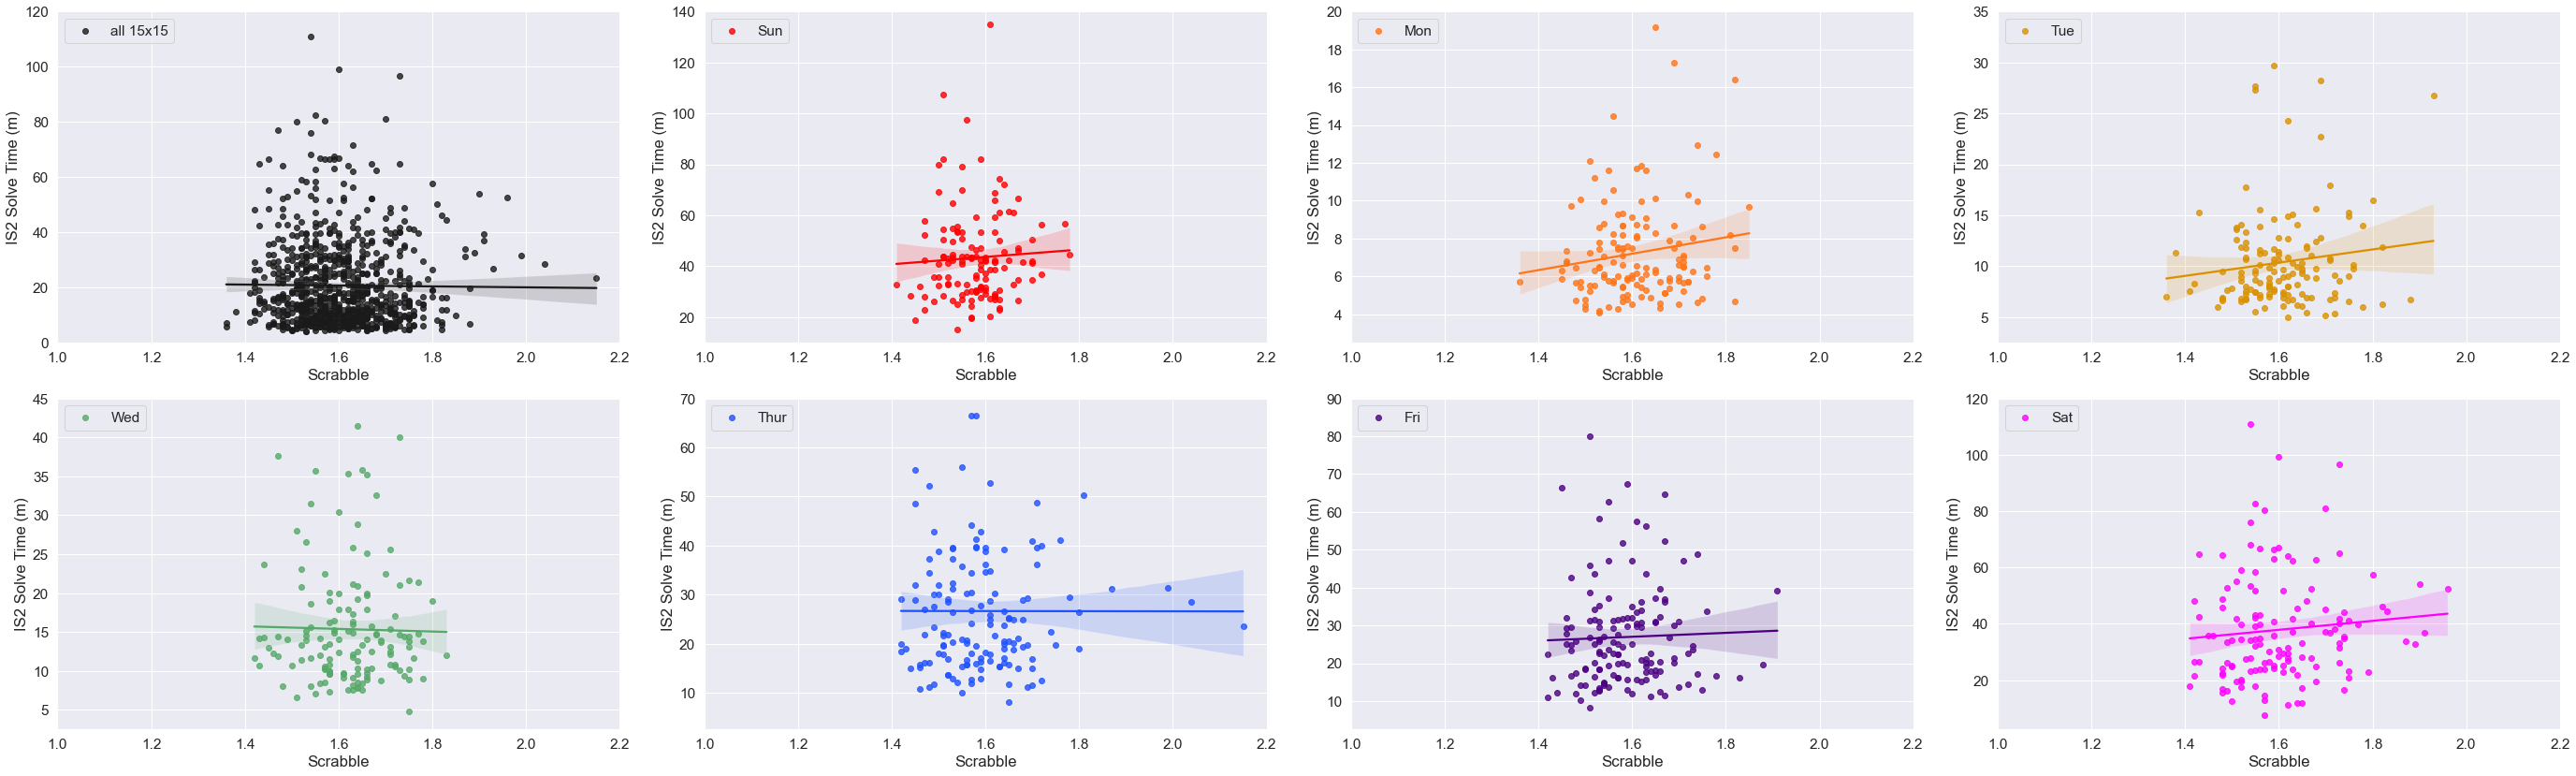

In [89]:
# Scrabble Average vs IS2 Raw Solve Times

IS2_df4 = IS2_df4.sort_values(by=['DOW_num'], ascending = True)

IS2_df4['plot_seq_map'] = IS2_df4['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=IS2_df4, x="Scrabble_Avg", y="IST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "Scrabble",
    ylabel="IS2 Solve Time (m)"
)

#Adjust subplots individually

p.axes[0].set_xlim((1,2.2))
p.axes[1].set_xlim((1,2.2))
p.axes[2].set_xlim((1,2.2))
p.axes[3].set_xlim((1,2.2))
p.axes[4].set_xlim((1,2.2))
p.axes[5].set_xlim((1,2.2))
p.axes[6].set_xlim((1,2.2))
p.axes[7].set_xlim((1,2.2))

p.axes[0].set_ylim((0,120))
p.axes[1].set_ylim((10,140))
p.axes[2].set_ylim((2.5,20))
p.axes[3].set_ylim((2.5,35))
p.axes[4].set_ylim((2.5,45))
p.axes[5].set_ylim((2.5,70))
p.axes[6].set_ylim((2.5,90))
p.axes[7].set_ylim((2.5,120))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

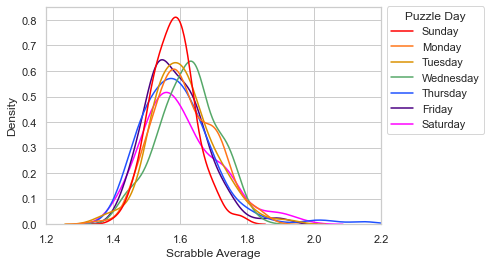

In [90]:
# Density plot of Scrabble Average in puzzles solved by IS2
# Rememember to use df3 because df4 has the copied-in data for plotting all completed puzzles together

IS2_df3 = IS2_df3.sort_values(by=['DOW_num'], ascending = True)

sns.set(style="whitegrid")
ax = sns.kdeplot(data=IS2_df3, x = "Scrabble_Avg", hue= "DOW", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], legend=True)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.027), title='Puzzle Day')

plt.xlim(1.2, 2.2)
ax.set_xlabel("Scrabble Average")
plt.show()

In [91]:
IS2_df3["Scrabble_Avg"].agg(['min', 'max'])

min    1.36
max    2.15
Name: Scrabble_Avg, dtype: float64

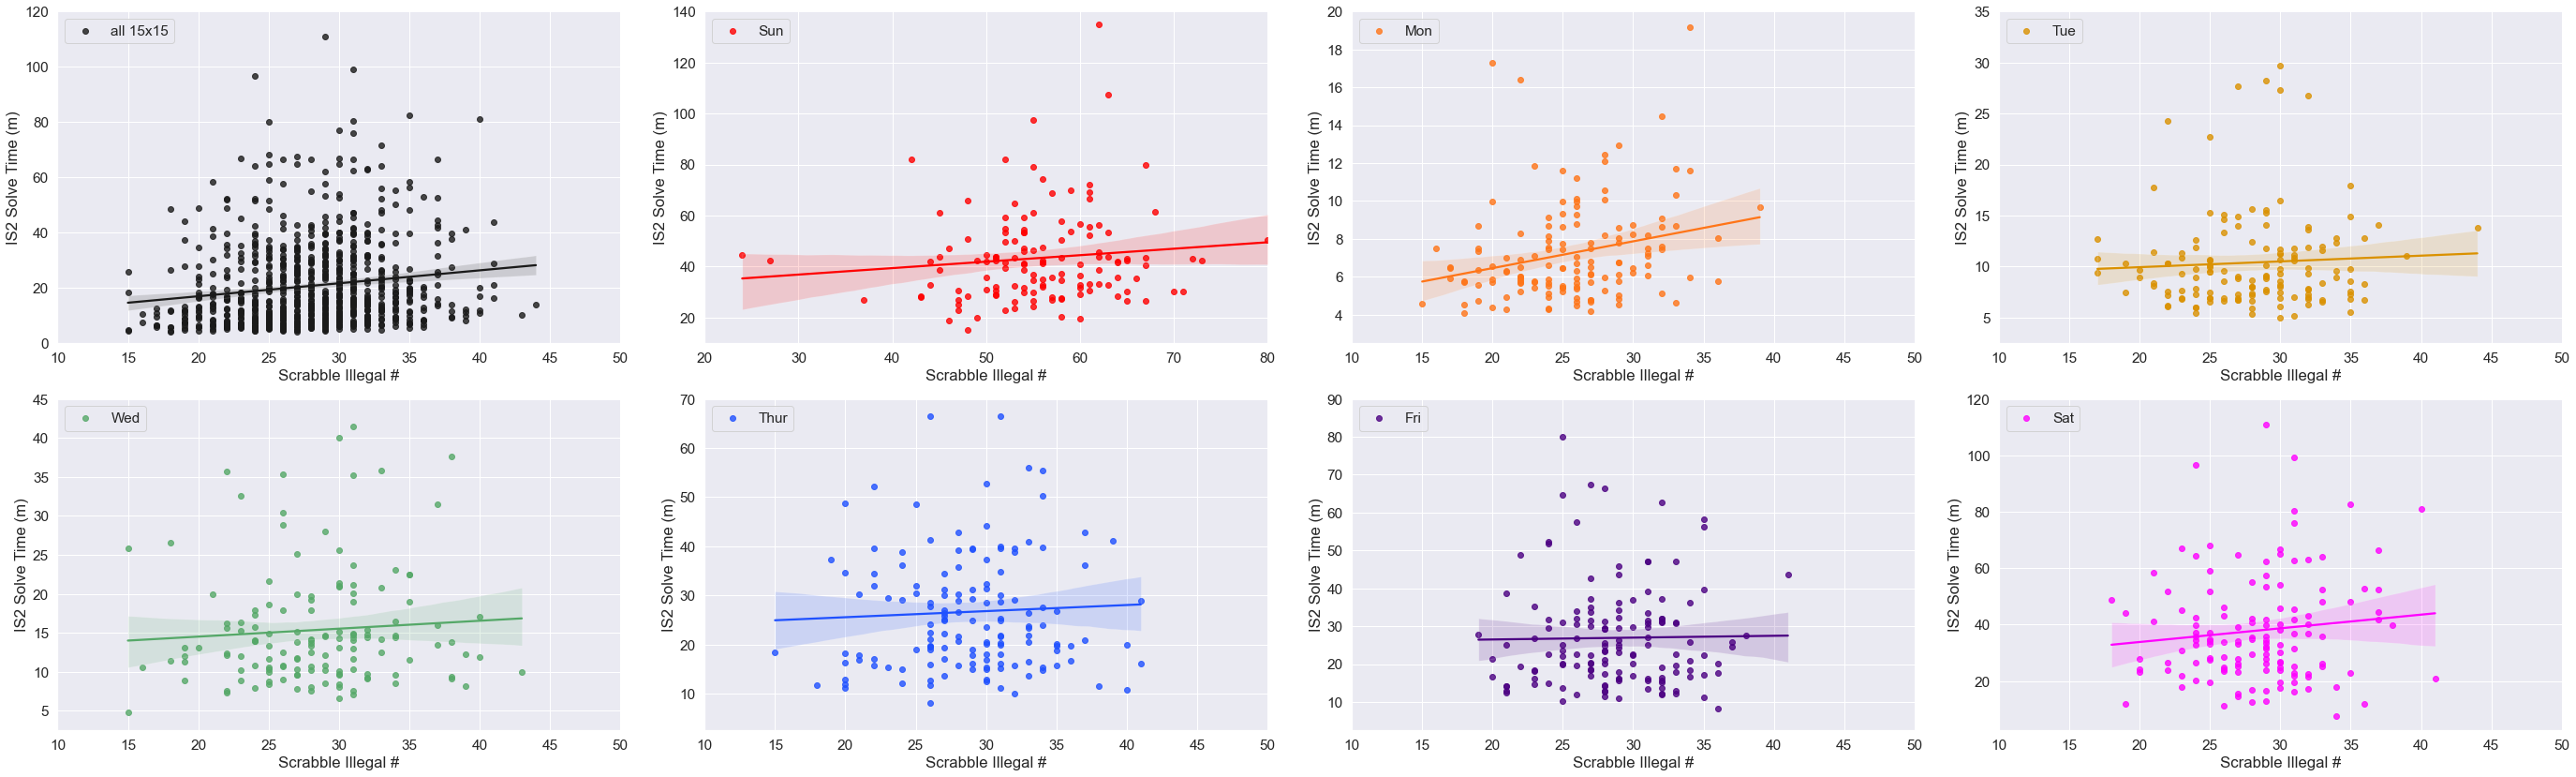

In [92]:
# Scrabble Illegal # vs IS2 Raw Solve Times

IS2_df4 = IS2_df4.sort_values(by=['DOW_num'], ascending = True)

IS2_df4['plot_seq_map'] = IS2_df4['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=IS2_df4, x="Scrabble_Illegal", y="IST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "Scrabble Illegal #",
    ylabel="IS2 Solve Time (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((10,50))
p.axes[1].set_xlim((20,80))
p.axes[2].set_xlim((10,50))
p.axes[3].set_xlim((10,50))
p.axes[4].set_xlim((10,50))
p.axes[5].set_xlim((10,50))
p.axes[6].set_xlim((10,50))
p.axes[7].set_xlim((10,50))

p.axes[0].set_ylim((0,120))
p.axes[1].set_ylim((10,140))
p.axes[2].set_ylim((2.5,20))
p.axes[3].set_ylim((2.5,35))
p.axes[4].set_ylim((2.5,45))
p.axes[5].set_ylim((2.5,70))
p.axes[6].set_ylim((2.5,90))
p.axes[7].set_ylim((2.5,120))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

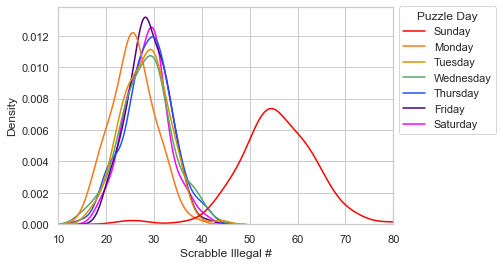

In [93]:
# Density plot of Scrabble Illegal # in puzzles solved by IS2
# Rememember to use df3 because df4 has the copied-in data for plotting all completed puzzles together

IS2_df3 = IS2_df3.sort_values(by=['DOW_num'], ascending = True)

sns.set(style="whitegrid")
ax = sns.kdeplot(data=IS2_df3, x = "Scrabble_Illegal", hue= "DOW", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], legend=True)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.027), title='Puzzle Day')

plt.xlim(10, 80)
ax.set_xlabel("Scrabble Illegal #")
plt.show()

In [94]:
IS2_df3["Scrabble_Illegal"].agg(['min', 'max'])

min    15
max    80
Name: Scrabble_Illegal, dtype: int64

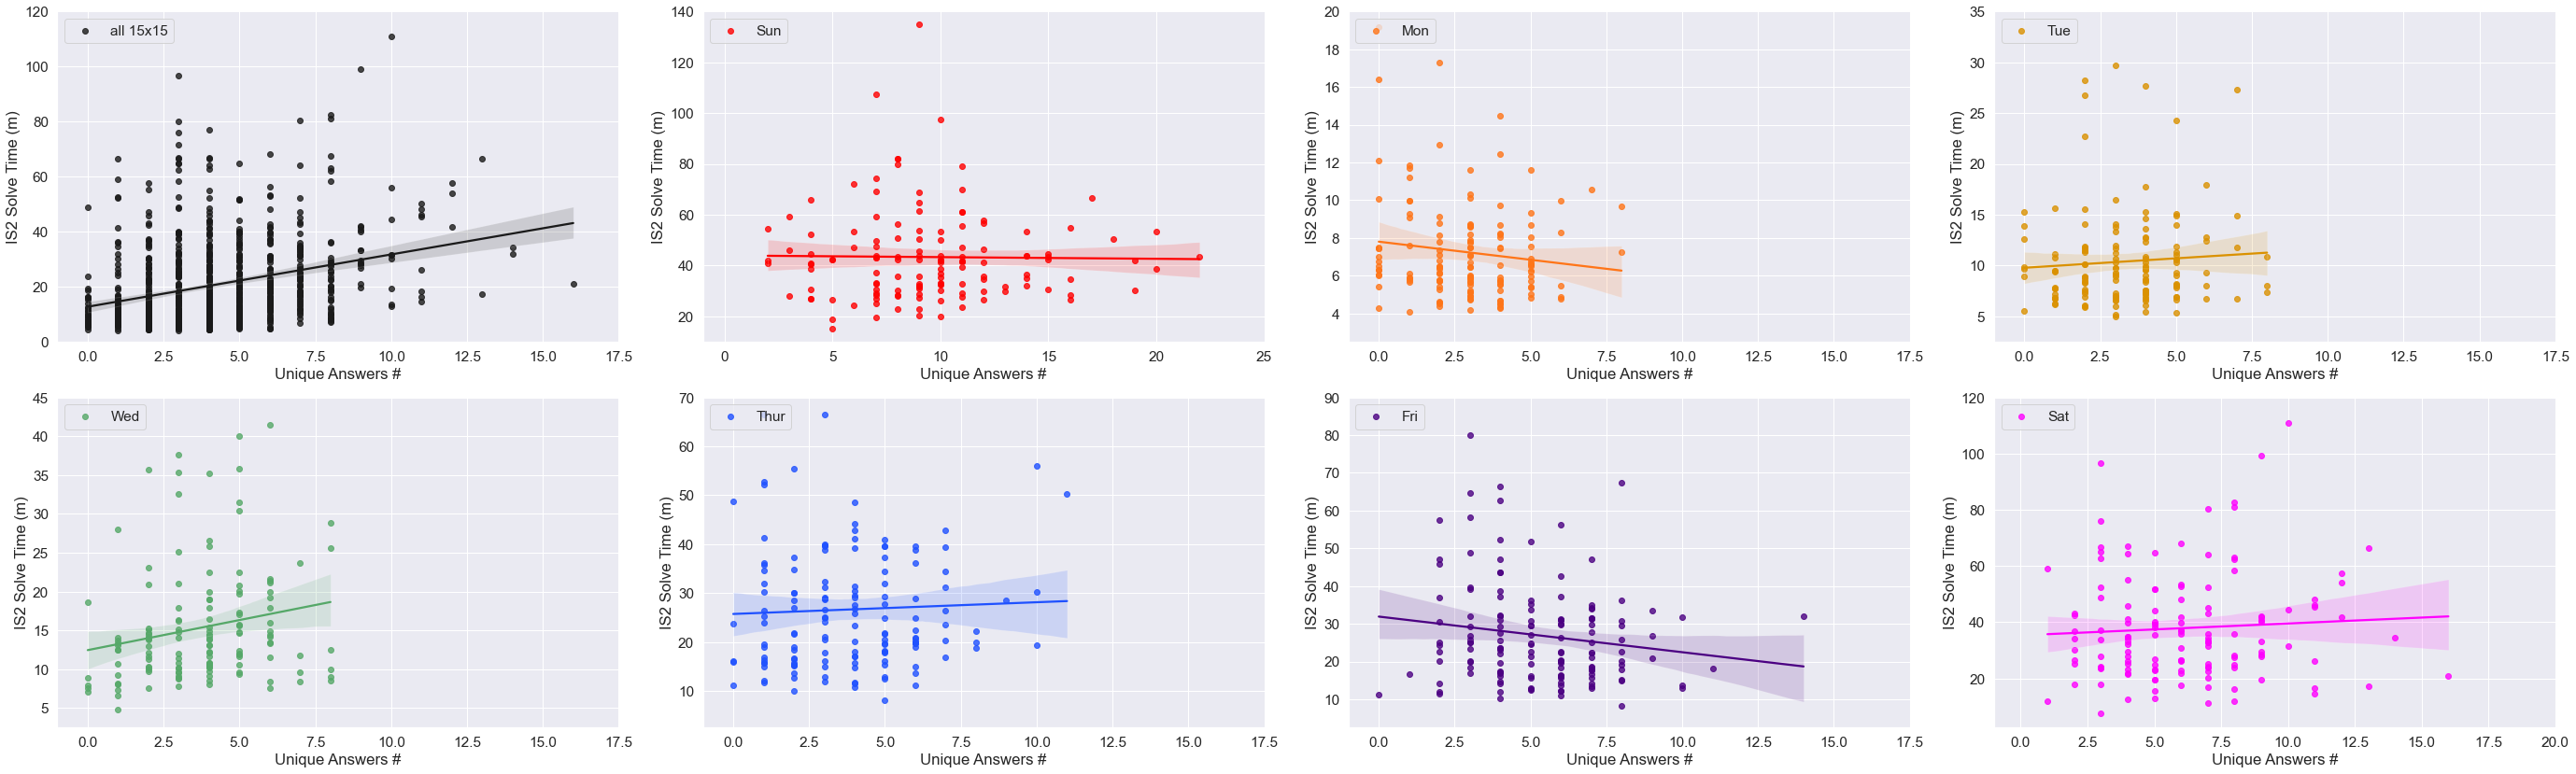

In [95]:
# Unique Answers # # vs IS2 Raw Solve Times

IS2_df4 = IS2_df4.sort_values(by=['DOW_num'], ascending = True)

IS2_df4['plot_seq_map'] = IS2_df4['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=IS2_df4, x="Unique_Answers", y="IST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "Unique Answers #",
    ylabel="IS2 Solve Time (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((-1,17.5))
p.axes[1].set_xlim((-1,25))
p.axes[2].set_xlim((-1,17.5))
p.axes[3].set_xlim((-1,17.5))
p.axes[4].set_xlim((-1,17.5))
p.axes[5].set_xlim((-1,17.5))
p.axes[6].set_xlim((-1,17.5))
p.axes[7].set_xlim((-1,20))

p.axes[0].set_ylim((0,120))
p.axes[1].set_ylim((10,140))
p.axes[2].set_ylim((2.5,20))
p.axes[3].set_ylim((2.5,35))
p.axes[4].set_ylim((2.5,45))
p.axes[5].set_ylim((2.5,70))
p.axes[6].set_ylim((2.5,90))
p.axes[7].set_ylim((2.5,120))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

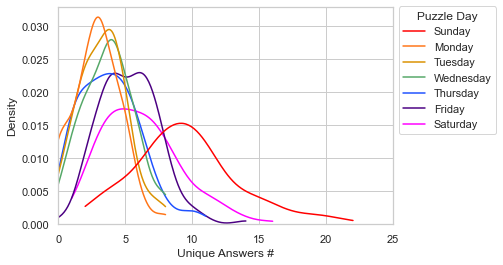

In [96]:
# Density plot of Unique Answers # in puzzles solved by IS2
# Rememember to use df3 because df4 has the copied-in data for plotting all completed puzzles together

IS2_df3 = IS2_df3.sort_values(by=['DOW_num'], ascending = True)

sns.set(style="whitegrid")
ax = sns.kdeplot(data=IS2_df3, x = "Unique_Answers", hue= "DOW", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], legend=True, cut=0, clip=(0,25))

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.027), title='Puzzle Day')

plt.xlim(0, 25)
ax.set_xlabel("Unique Answers #")
plt.show()

In [97]:
IS2_df3["Unique_Answers"].agg(['min', 'max'])

min     0
max    22
Name: Unique_Answers, dtype: int64

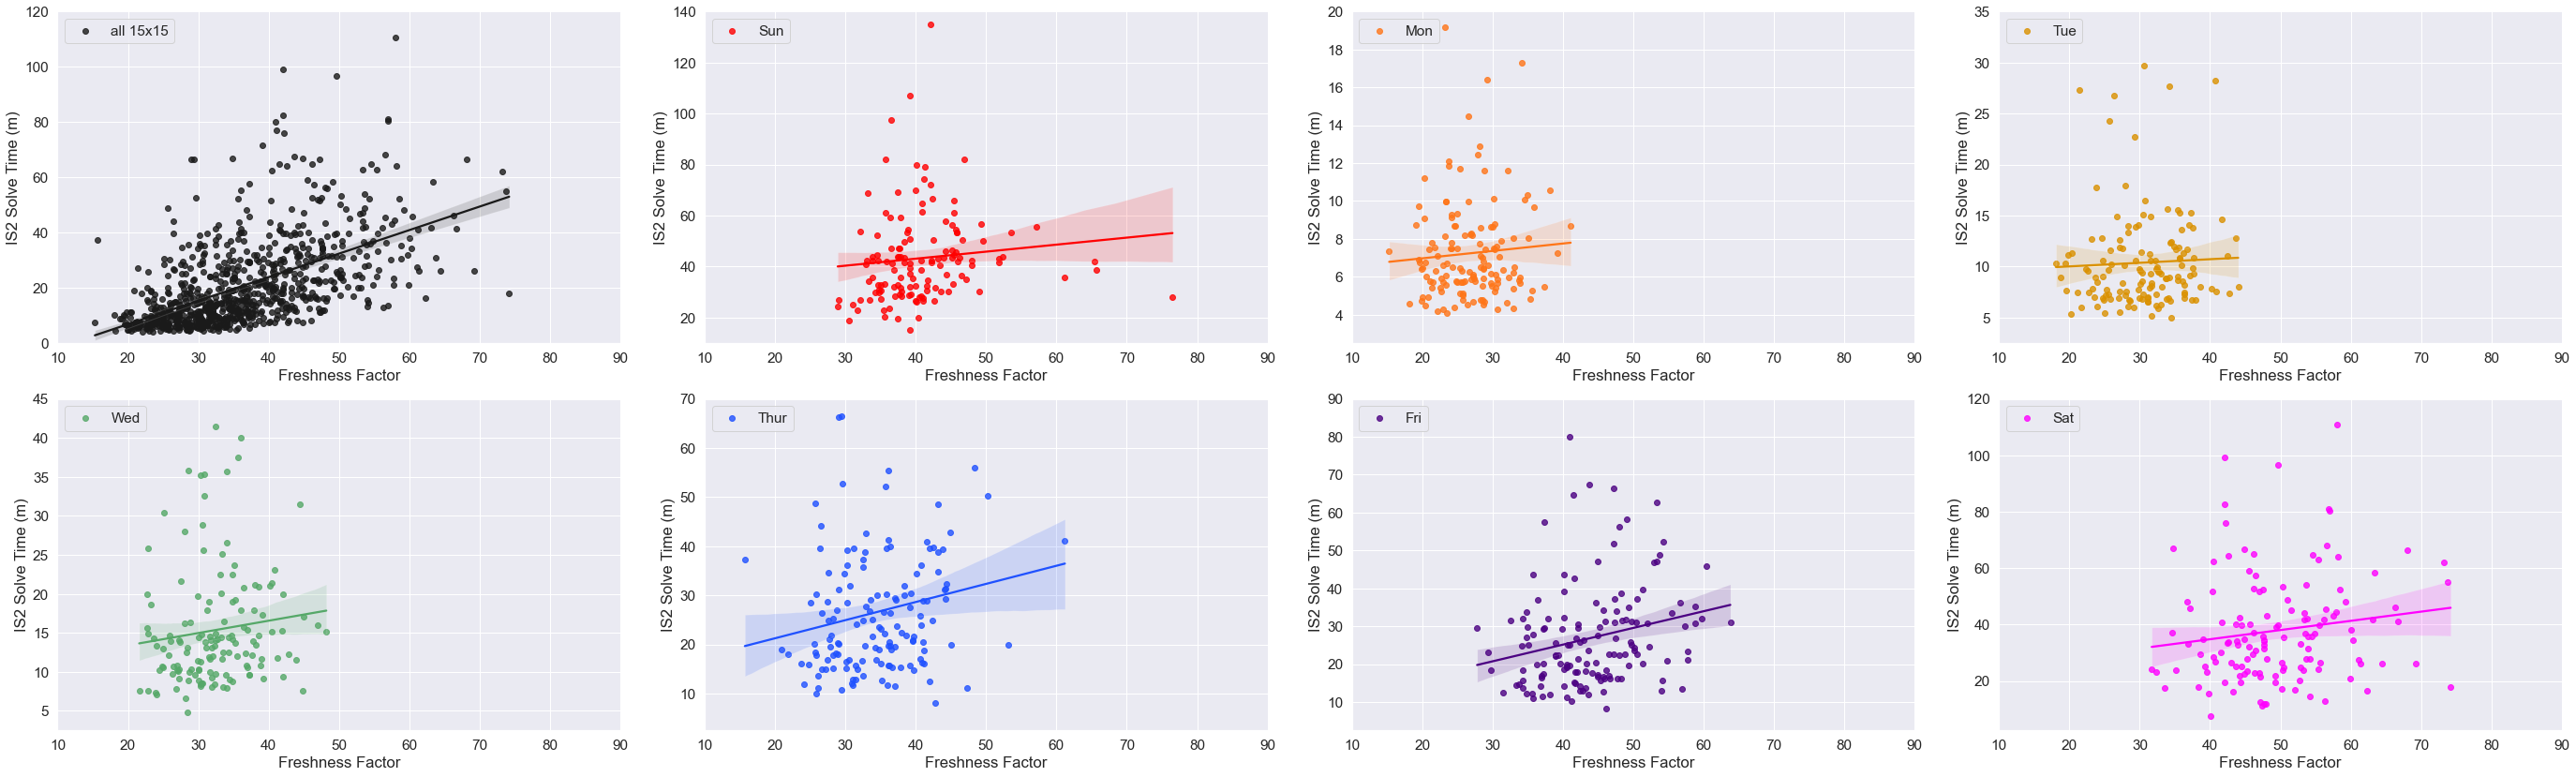

In [98]:
# Freshness Factor vs IS2 Raw Solve Times

IS2_df4 = IS2_df4.sort_values(by=['DOW_num'], ascending = True)

IS2_df4['plot_seq_map'] = IS2_df4['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=IS2_df4, x="Freshness_Factor", y="IST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "Freshness Factor",
    ylabel="IS2 Solve Time (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((10,90))
p.axes[1].set_xlim((10,90))
p.axes[2].set_xlim((10,90))
p.axes[3].set_xlim((10,90))
p.axes[4].set_xlim((10,90))
p.axes[5].set_xlim((10,90))
p.axes[6].set_xlim((10,90))
p.axes[7].set_xlim((10,90))

p.axes[0].set_ylim((0,120))
p.axes[1].set_ylim((10,140))
p.axes[2].set_ylim((2.5,20))
p.axes[3].set_ylim((2.5,35))
p.axes[4].set_ylim((2.5,45))
p.axes[5].set_ylim((2.5,70))
p.axes[6].set_ylim((2.5,90))
p.axes[7].set_ylim((2.5,120))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

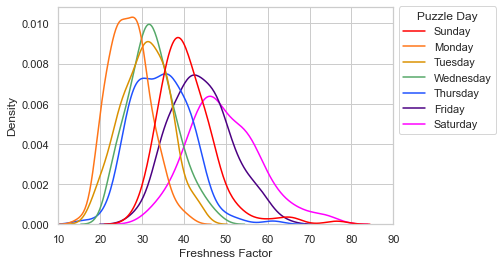

In [99]:
# Density plot of Freshness Factor in puzzles solved by IS2
# Rememember to use df3 because df4 has the copied-in data for plotting all completed puzzles together

IS2_df3 = IS2_df3.sort_values(by=['DOW_num'], ascending = True)

sns.set(style="whitegrid")
ax = sns.kdeplot(data=IS2_df3, x = "Freshness_Factor", hue= "DOW", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], legend=True)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.027), title='Puzzle Day')

plt.xlim(10, 90)
ax.set_xlabel("Freshness Factor")
plt.show()

In [100]:
IS2_df3["Freshness_Factor"].agg(['min', 'max'])

min    15.3
max    76.5
Name: Freshness_Factor, dtype: float64

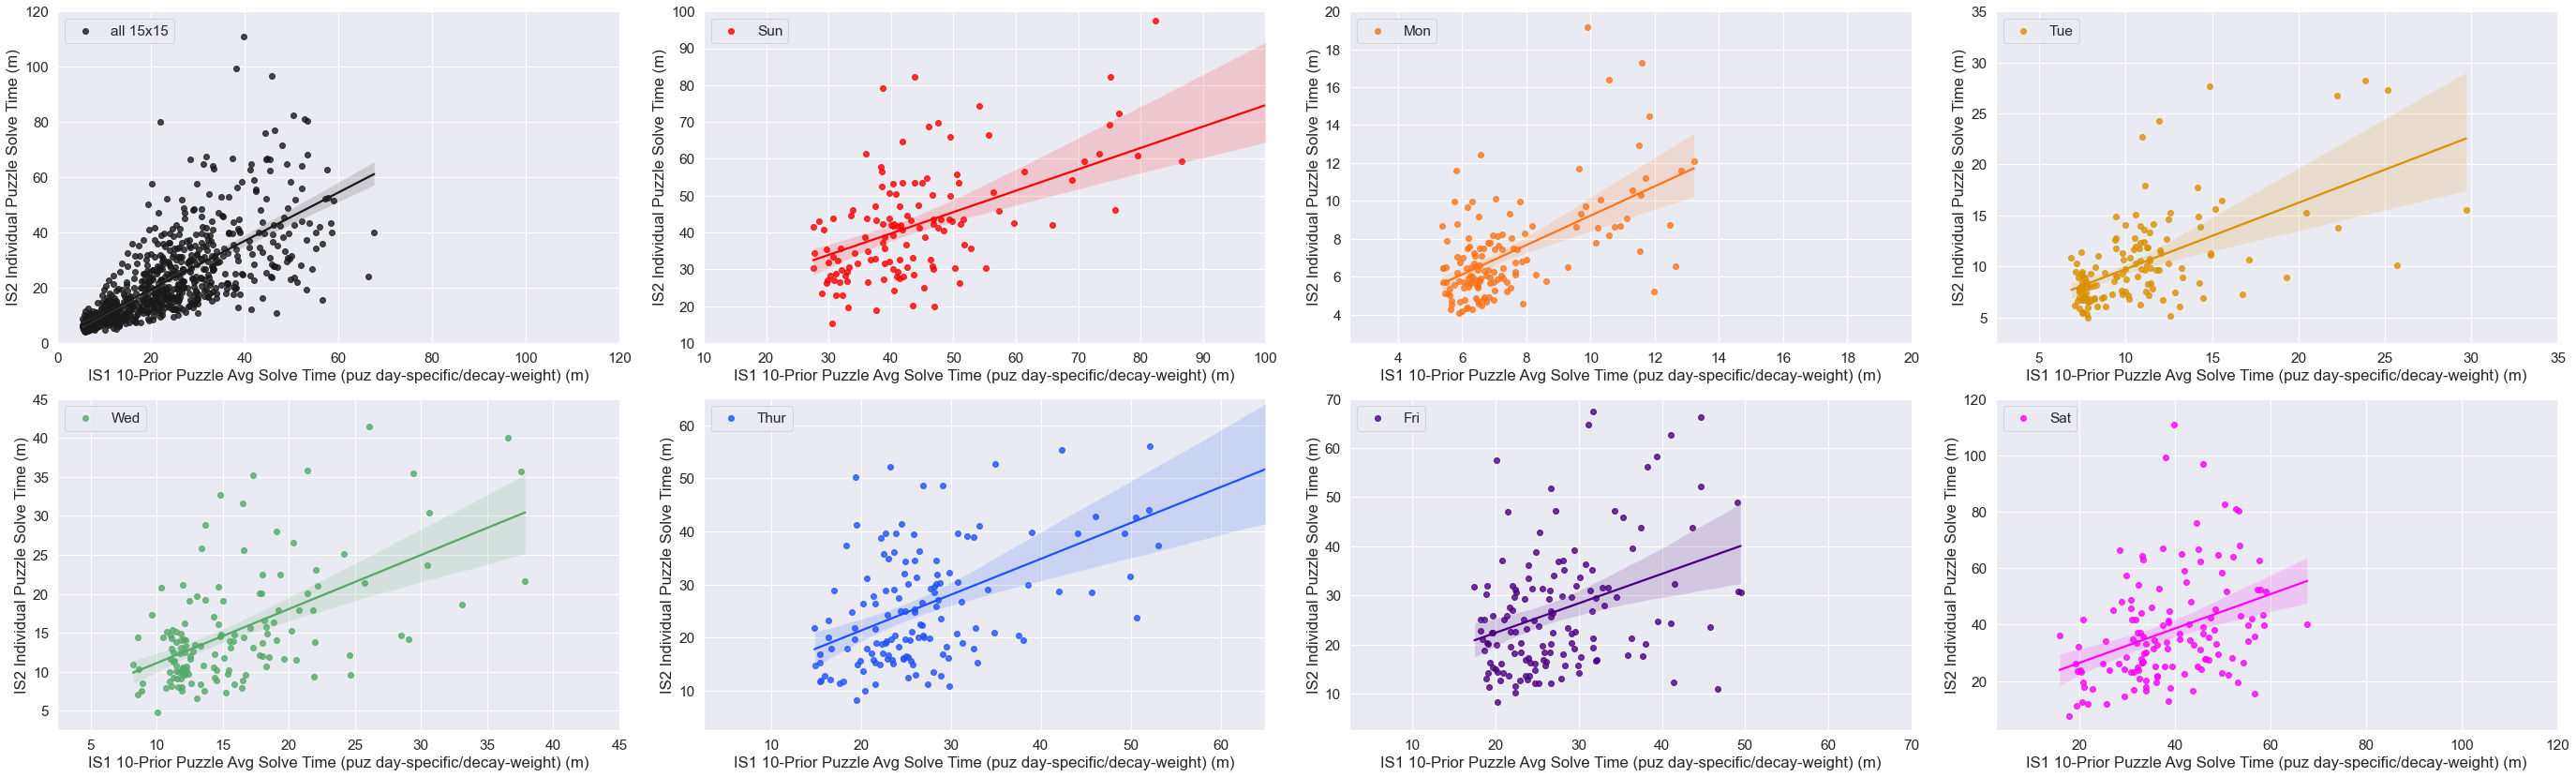

In [106]:
# IS2 Recent Past Performance (Time-Decay Weighted and Difficulty Adjusted Last 10) vs IS2 Raw Solve Times

IS2_df4 = IS2_df4.sort_values(by=['DOW_num'], ascending = True)

IS2_df4['plot_seq_map'] = IS2_df4['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=IS2_df4, x="IS_pds_l10_dw", y="IST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "IS1 10-Prior Puzzle Avg Solve Time (puz day-specific/decay-weight) (m)",
    ylabel="IS2 Individual Puzzle Solve Time (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((0,120))
p.axes[1].set_xlim((10,100))
p.axes[2].set_xlim((2.5,20))
p.axes[3].set_xlim((2.5,35))
p.axes[4].set_xlim((2.5,45))
p.axes[5].set_xlim((2.5,65))
p.axes[6].set_xlim((2.5,70))
p.axes[7].set_xlim((2.5,120))

p.axes[0].set_ylim((0,120))
p.axes[1].set_ylim((10,100))
p.axes[2].set_ylim((2.5,20))
p.axes[3].set_ylim((2.5,35))
p.axes[4].set_ylim((2.5,45))
p.axes[5].set_ylim((2.5,65))
p.axes[6].set_ylim((2.5,70))
p.axes[7].set_ylim((2.5,120))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

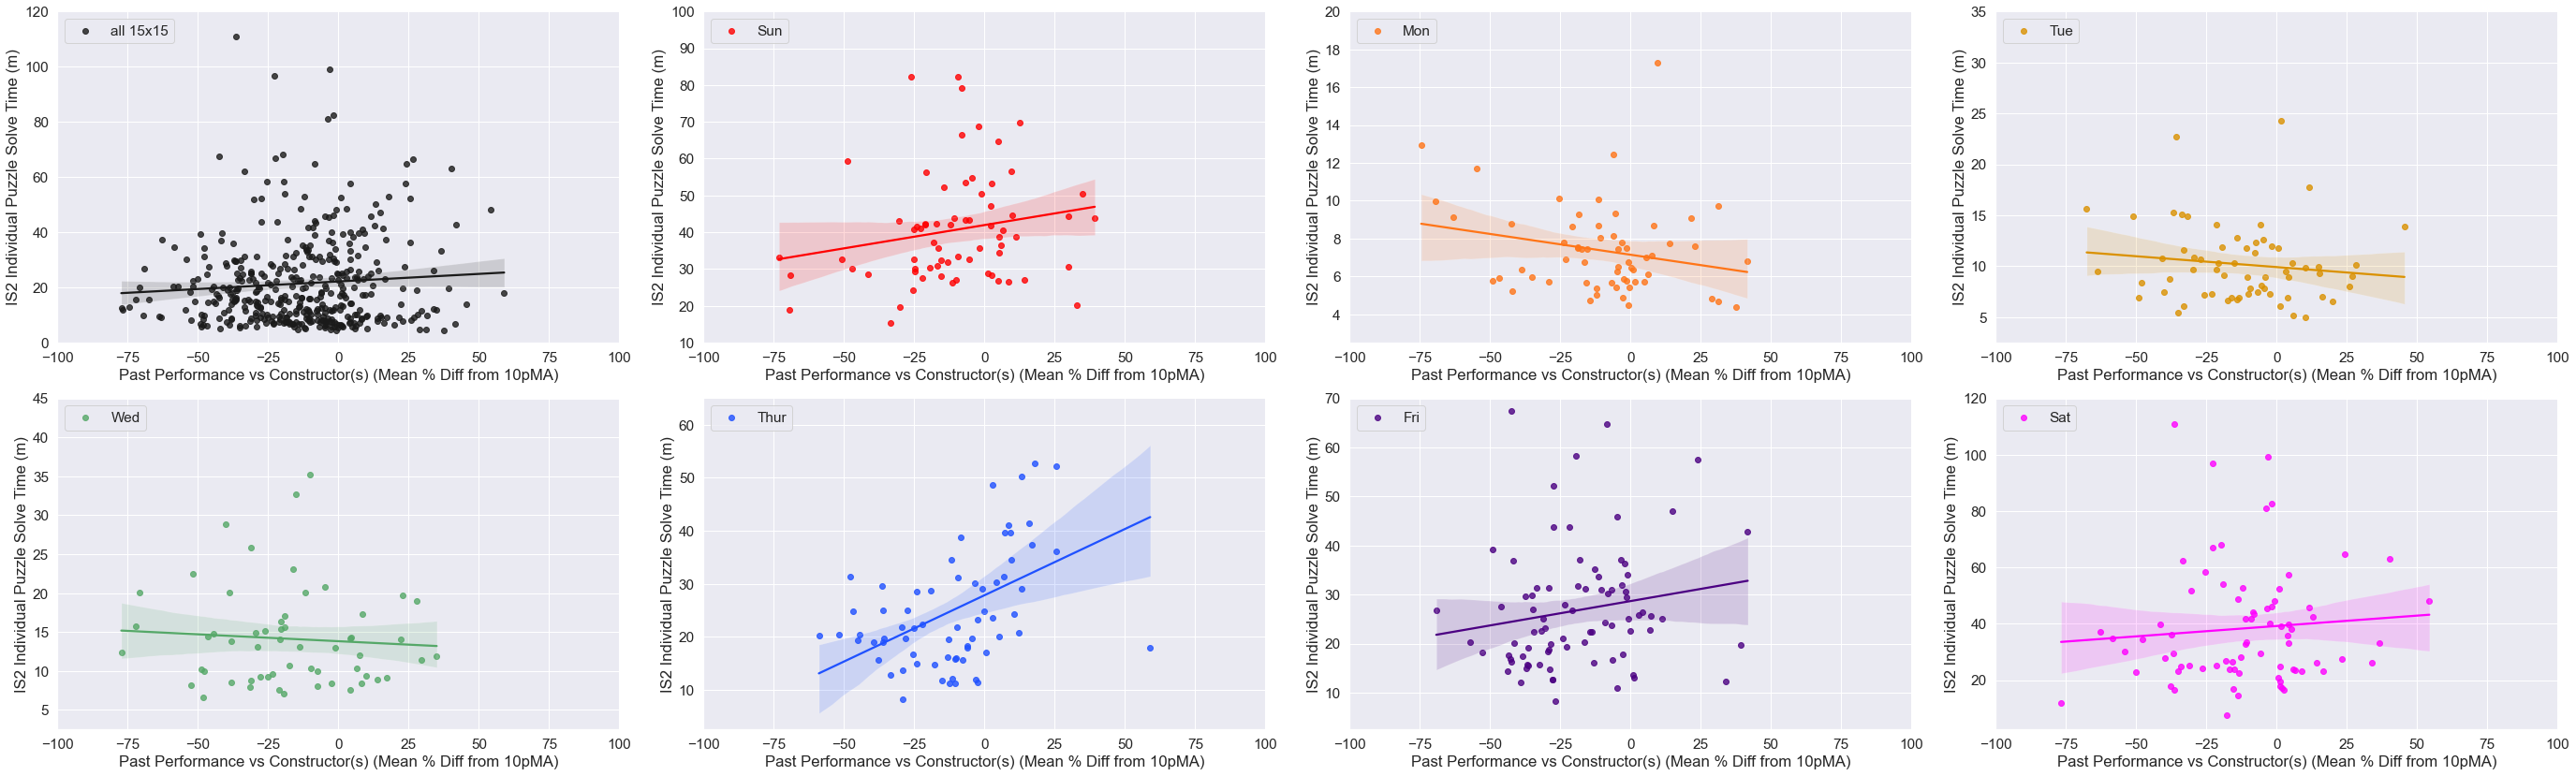

In [107]:
# Mean Past Performance vs Constructor(s) vs IS2 Raw Solve Times

IS2_df4 = IS2_df4.sort_values(by=['DOW_num'], ascending = True)

IS2_df4['plot_seq_map'] = IS2_df4['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=IS2_df4, x="IS_per_constr_avg_past_diff_from_10pMA", y="IST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "Past Performance vs Constructor(s) (Mean % Diff from 10pMA)",
    ylabel="IS2 Individual Puzzle Solve Time (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((-100,100))
p.axes[1].set_xlim((-100,100))
p.axes[2].set_xlim((-100,100))
p.axes[3].set_xlim((-100,100))
p.axes[4].set_xlim((-100,100))
p.axes[5].set_xlim((-100,100))
p.axes[6].set_xlim((-100,100))
p.axes[7].set_xlim((-100,100))

p.axes[0].set_ylim((0,120))
p.axes[1].set_ylim((10,100))
p.axes[2].set_ylim((2.5,20))
p.axes[3].set_ylim((2.5,35))
p.axes[4].set_ylim((2.5,45))
p.axes[5].set_ylim((2.5,65))
p.axes[6].set_ylim((2.5,70))
p.axes[7].set_ylim((2.5,120))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [111]:
IS2_df4["IS_per_constr_avg_past_diff_from_10pMA"].values_count

AttributeError: 'Series' object has no attribute 'values_count'